- 주제
    - 공유 오피스 이벤트 이용자의 유료전환 가능성 예측 및 전략 제안

- 사용 데이터

| 테이블명          | 테이블 설명                 | 주요컬럼                                                      |
|-------------------|-----------------------------|---------------------------------------------------------------|
| `trial_register`  | 3일 체험 신청              | `유저id`, `3일체험신청일시`                                  |
| `trial_visit_info`| 3일 체험 신청자 일자별 방문 기록 | `유저id`, `날짜`, `지점id`, `최초입실시각`, `최종퇴실시각`, `체류시간` |
| `trial_access_log`| 3일 체험 신청자 출입 기록      | `유저id`, `지점id`, `timestamp`, `출입방향`                  |
| `trial_payment`   | 3일 체험 신청자 결제 여부      | `유저id`, `결제여부`                                          |
| `site_area`       | 지점별 면적                 | `지점id`, `지점 면적`                                        |

- 사용 툴

- 결과 \
✅ 중요도 ≥ 0.06인 피처 목록: \
['avg_duration', 'max_duration', 'session_std', 'avg_stay_time'] 

📊 정확도: 0.8771266540642723

📄 분류 리포트: \
              precision    recall  f1-score   support 

           0       0.87      0.92      0.90       914 
           1       0.89      0.81      0.85       673 

    accuracy                           0.88      1587 
   macro avg       0.88      0.87      0.87      1587 \
weighted avg       0.88      0.88      0.88      1587 

중요도가 0.06이상인 데이터와 전체로 돌린 예측 모델의 성능이 크게 차이가 나지않았다.
전체를 돌린 모델보다 중요도 0.06이상인 데이터의 효율이 더 뛰어나 이를 최종 모델로 선정하였다.

# 분석 개요

- 공유오피스 출입데이터를 바탕으로 각종 비즈니스 지표의 추이를 예측하여 서비스의 개선 방향성을 제시하는 프로젝트 입니다.
    - 공유오피스 서비스의 3일체험 신청, 신청자 일자별 방문 및 출입기록, 결제 여부, 지점별 면적 정보 등의 데이터가 담긴 데이터 셋이 제공됩니다.
    - 지금까지 학습했던 데이터 분석 방법론 및 머신러닝 기법을 활용하여 서비스의 현재 상태를 분석하고, 향후 사업적인 관점에서의 개선점을 제안해보세요.
        - ex1. 무료 유저의 유료 결제 전환율 예측 결과를 바탕으로 한 비즈니스 액션 제안
        - ex2. 유저의 오피스 이용량 시간 예측 결과로부터 도출한 개선안 제안
        - ex3. 유저의 방문일자 및 출입시간에 따른 방문 패턴 예측, 신규 상품 제안
- 프로젝트의 큰 주제 내에서 팀 별로 좀 더 관심이 있는 주제를 선정하고, 선정한 주제를 연구하는데 있어 필요한 정보가 무엇인지 파악하여 결론을 도출해보세요.

#환경설정

In [ ]:
!pip install koreanize-matplotlib

In [ ]:
import pandas as pd
from pandas import Series
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import koreanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

#데이터 불러오기

In [ ]:
site_area = pd.read_csv('/content/site_area.csv')
trial_access_log = pd.read_csv('/content/trial_access_log.csv')
trial_payment = pd.read_csv('/content/trial_payment.csv')
trial_register = pd.read_csv('/content/trial_register.csv')
trial_visit_info = pd.read_csv('/content/trial_visit_info.csv')

## 전처리

### trial_acess_log

In [ ]:
trial_access_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63708 entries, 0 to 63707
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         63708 non-null  int64 
 1   checkin    63708 non-null  int64 
 2   cdate      63708 non-null  object
 3   site_id    63708 non-null  int64 
 4   user_uuid  63708 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.4+ MB


In [ ]:
trial_access_log.head()

id  checkin                       cdate  site_id  \
0  1719038        1  2023-07-07 07:11:55.201673       49   
1  1716702        2  2023-07-06 15:15:58.761284       49   
2  1719956        2  2023-07-07 14:10:41.848998       49   
3  1716588        1  2023-07-06 13:09:48.758097       49   
4  1719649        1  2023-07-07 10:12:42.083352       49   

                              user_uuid  
0  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89  
1  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89  
2  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89  
3  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89  
4  cacd0adb-2c87-450f-8a00-2b2ea6b8fa89

In [ ]:
# 데이터 형변환
trial_access_log['site_id'] = trial_access_log['site_id'].astype('category')
trial_access_log['cdate'] = pd.to_datetime(trial_access_log['cdate'].astype(str).str.split('.').str[0])

In [ ]:
trial_access_log['checkin'] = trial_access_log['checkin'].astype('category')

In [ ]:
trial_access_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63708 entries, 0 to 63707
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         63708 non-null  int64         
 1   checkin    63708 non-null  category      
 2   cdate      63708 non-null  datetime64[ns]
 3   site_id    63708 non-null  category      
 4   user_uuid  63708 non-null  object        
dtypes: category(2), datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ MB


- 00시에 시스템상 일괄적으로 처리된 것으로 보이는 유저추적 및 처리

In [ ]:
from datetime import time
users_at_00 =trial_access_log[(trial_access_log['cdate'].dt.hour == 0) & (trial_access_log['cdate'].dt.minute == 0)]
users_at_00.head()

id checkin               cdate site_id  \
4289    511272       1 2022-03-08 00:00:30       1   
4294    511273       1 2022-03-08 00:00:31       1   
12387   319392       2 2021-12-03 00:00:20       2   
13447  1952003       1 2023-10-07 00:00:51       2   
13677   162321       2 2021-08-13 00:00:29       3   

                                  user_uuid  
4289   00b27799-6ef2-4eda-a714-c31a03531672  
4294   00b27799-6ef2-4eda-a714-c31a03531672  
12387  5a8723ea-4207-4d94-ab06-d7f7d7de8b61  
13447  736247c4-f76d-4155-b831-ecdde6b403a3  
13677  7d2e1084-23a9-44af-b813-72c4d140cbc6

In [ ]:
print(f'유저 수: {users_at_00["user_uuid"].nunique()} 명')

유저 수: 22 명


In [ ]:
print(f'중복 유저 수: {users_at_00["user_uuid"].duplicated().sum()} 명')

중복 유저 수: 2 명


In [ ]:
# 원본 복사
trial_access_copy = trial_access_log.copy()

- 아래 코드 설명 (첫 로그가 NaN인 이유)
> - 각 사용자(user_uuid)별로 cdate 기준으로 시간 순으로 정렬한 뒤
> - `바로 앞 로그와의 시간 차이(초 단위)`를 계산합니다.
> - 이때 가장 첫 번째 로그는 비교 대상이 없기 때문에 NaN (결측값)이 나옵니다.

- keep 조건
> - NaN인 로그는 삭제하지 않고 유지한다
> - 바로 전 로그와의 시간 차이가 60초 넘는 것도 진짜 방문으로 간주하고 유지한다
> - 즉, 60초 이내에 또 찍힌 로그만 중복으로 보고 제거하는 거예요.

In [ ]:
# 3. 00시 00분에 찍힌 로그 찾기
mask_midnight = (trial_access_copy['cdate'].dt.hour == 0) & (trial_access_copy['cdate'].dt.minute == 0)
users_with_midnight_logs = trial_access_copy.loc[mask_midnight, 'user_uuid'].nunique()

print(f"00시00분 로그를 가진 유저 수: {users_with_midnight_logs}")

# 해당 로그 제거
trial_access_copy = trial_access_copy[~mask_midnight].copy()

# 4. checkin == 1 인 로그만 추출
trial_access_log_checkin = trial_access_copy[trial_access_copy['checkin'] == 1].copy()

# 5. 유저별로 시간 순 정렬 후 1분 이내 중복 제거
trial_access_log_checkin.sort_values(by=['user_uuid', 'cdate'], inplace=True)
trial_access_log_checkin['time_diff'] = trial_access_log_checkin.groupby('user_uuid')['cdate'].diff().dt.total_seconds()

# 첫 로그는 NaN 이므로 무조건 keep, 이후 60초 이하인 경우는 중복으로 판단
trial_access_log_checkin_filtered = trial_access_log_checkin[(trial_access_log_checkin['time_diff'].isna()) | (trial_access_log_checkin['time_diff'] > 60)].copy()

# 6. 나머지 checkin != 1 데이터와 합치기
trial_access_log_rest = trial_access_copy[trial_access_copy['checkin'] != 1]
trial_access_log_final = pd.concat([trial_access_log_checkin_filtered, trial_access_log_rest], ignore_index=True).sort_values(by='cdate')

# 결과 확인
print(f"최종 로그 수: {len(trial_access_log_final)}")
print(f"최종 유저 수: {trial_access_log_final['user_uuid'].nunique()}")

00시00분 로그를 가진 유저 수: 22
최종 로그 수: 62585
최종 유저 수: 6026


In [ ]:
print(f"원본 로그 수: {len(trial_access_log)}")
print(f"삭제 로그 수: {len(trial_access_log) - len(trial_access_log_final)}")
print(f"기존 유저 수: {trial_access_log['user_uuid'].nunique()}")

원본 로그 수: 63708
삭제 로그 수: 1123
기존 유저 수: 6026


### trial_payment

- 중복값 확인

In [ ]:
pay_0 = trial_payment[trial_payment['is_payment'] == 0]

In [ ]:
pay_1 = trial_payment[trial_payment['is_payment'] == 1]

In [ ]:
pay_0_g = pay_0.groupby('user_uuid').count().sort_values('is_payment', ascending=False)

In [ ]:
pay_1_g = pay_1.groupby('user_uuid').count().sort_values('is_payment', ascending=False)

In [ ]:
pay_0_g[pay_0_g['is_payment'] == 2]

is_payment
user_uuid                                       
b981ed1d-7695-4a31-b0e8-347ec0011de9           2
19c8e329-9654-4178-989d-c93617655650           2
56231301-3408-4206-962d-aaa25a342821           2
42f99cf7-b801-4413-aec3-18595a0aea48           2
acf3e288-4487-492b-9477-df149fb72e83           2
66fc8afa-ba4f-44dd-b882-f62d6bb98d39           2
969e4e79-950b-4608-90da-ac26aed52d55           2
2c76e1c0-4996-48c0-9d80-1f3bd206a23d           2
948ae0cc-bc5a-4bd3-89ce-92b2a5c34710           2
533e00f2-e2c4-4adb-961b-2836184320f3           2
c3d1d351-5b79-4504-a52e-f9bcf4cd28bb           2
dd1be3ad-85a9-43e1-87c4-c4b9fff73b83           2
204ecb60-f9e3-42b4-ae7a-f1f00c939894           2
e4ca475f-5ab7-4615-b0e0-8e64792afb9b           2
906b191d-ccfe-45ab-9233-6445f631d1d1           2
d9fc9841-6383-410e-9d76-2862f1b6e1af           2
14872783-3af7-492a-b51c-12f3003b76f1           2
4c5b26a3-24d4-4b8f-a591-be80271c0aeb           2
d4016d9a-992b-424c-80e9-5203d0e303cd           2
eff4950f-de9f-449b-8a18-eb1d1019acf5           2
039fa563-fc65-4b0c-9087-4beb5cd17fd7           2
4008307f-486f-408f-b90b-e01398972029           2
b8b00c14-f550-49a4-8800-114ee4cfd51b           2

In [ ]:
pay_1_g[pay_1_g['is_payment'] == 2]

is_payment
user_uuid                                       
bf620970-e3f2-4b54-9620-86171299d08b           2
ffd880d5-0200-44e1-91db-7df9483f2a39           2
f655be50-4b26-46cb-823b-bcc01108b3cc           2
dceba5c8-20c2-497a-829a-74099f7ee5a8           2
bd3ed6c2-f139-4e0c-b53e-b956101b2822           2
06e78cdd-c7f0-4b45-af6d-9126125d0686           2
c6f9f925-b346-42ef-9fb8-b95e7c18824a           2
02458b10-7f2b-4030-950b-ba650ce2fb49           2
5b16f32b-3344-4b39-b2bf-8cf1caac78fa           2
7c5f0d06-2b1a-4a47-8961-3f93813b4eb7           2
6a88014b-fbbd-4e73-8036-04435c062a97           2
091cdea5-fc99-47fd-a722-3fe190f9cb26           2

In [ ]:
# 중복 행 제거하기
payment_df = trial_payment.drop_duplicates().copy() # 원본 데이터 보존용
payment_df.duplicated().sum()

np.int64(0)

### tiral_register

In [ ]:
register_group = trial_register.groupby('user_uuid').count().sort_values('trial_date', ascending=False)

In [ ]:
register_group

trial_date
user_uuid                                       
948ae0cc-bc5a-4bd3-89ce-92b2a5c34710           2
42f99cf7-b801-4413-aec3-18595a0aea48           2
b8b00c14-f550-49a4-8800-114ee4cfd51b           2
14872783-3af7-492a-b51c-12f3003b76f1           2
d9fc9841-6383-410e-9d76-2862f1b6e1af           2
...                                          ...
53fba035-4db8-4a03-927d-7976bba666bf           1
53fc8545-9861-4887-a5d2-4d82675cf920           1
53fe203d-c226-4ef1-a713-205cc6d04a48           1
54109800-9e13-4556-be28-dd452bf7e253           1
53de5960-f46a-4561-8c18-03e69c50f762           1

[9624 rows x 1 columns]

In [ ]:
# 중복 행 제거하기
register_df = trial_register.drop_duplicates().copy() # 원본 데이터 보존용
register_df.duplicated().sum()

np.int64(0)

In [ ]:
register_df

trial_date                             user_uuid
0     2023-12-21  2b251333-8676-4c11-a736-dcf2350f8821
1     2023-12-21  e111619a-0975-451b-9a4a-bc8aea7b7b84
2     2023-12-21  4a184795-b056-4572-a874-644f68609ea3
3     2023-12-21  2ba8ab19-2d40-4423-ad04-f0f9ca814871
4     2023-12-21  1d49ba36-6c23-405b-9514-aa7f4aeceff0
...          ...                                   ...
9654  2023-11-17  d7599df4-1e5a-4f5e-97ce-c42047bfd87c
9655  2023-11-17  43263092-3b28-4817-9fa9-4205ad3097fe
9656  2023-11-17  51a40f33-1027-4544-9b95-45bca7c104fb
9657  2023-11-18  3e649531-bf5b-4b99-84e5-ca3e0e647d0c
9658  2023-11-18  b7633cc2-bde9-4dff-9c8f-33dac3c976c2

[9631 rows x 2 columns]

In [ ]:
register_df['trial_date'] = pd.to_datetime(register_df['trial_date'])
register_df = register_df.rename(columns={'trial_date': 'timestamp'})

In [ ]:
register_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9631 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  9631 non-null   datetime64[ns]
 1   user_uuid  9631 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 483.8+ KB


### trial_visit_info

In [ ]:
# 데이터 형변환
trial_visit_info['site_id'] = trial_visit_info['site_id'].astype('category')
trial_visit_info['date'] = pd.to_datetime(trial_visit_info['date'])
trial_visit_info['stay_time'] = pd.to_datetime(trial_visit_info['stay_time'])
trial_visit_info['first_enter_time'] = pd.to_datetime(trial_visit_info['first_enter_time'].astype(str).str.split('.').str[0])
trial_visit_info['last_leave_time'] = pd.to_datetime(trial_visit_info['last_leave_time'].astype(str).str.split('.').str[0])

In [ ]:
# 결측치 있는 행 찾기
missing_rows = trial_visit_info[trial_visit_info.isnull().any(axis=1)]
missing_rows

site_id       date                  stay_time  stay_time_second  \
342        1 2021-06-03 2025-06-18 03:43:06.377172             13386   
343        4 2021-06-01 2025-06-18 06:51:00.013723             24660   
344        4 2021-06-02 2025-06-18 00:19:07.855184              1147   
736        3 2021-06-25 2025-06-18 01:24:23.577860              5063   
737        3 2021-06-24 2025-06-18 02:17:26.786498              8246   
...      ...        ...                        ...               ...   
7911       4 2021-06-11 2025-06-18 02:24:32.228295              8672   
7919       4 2021-06-01 2025-06-18 06:40:46.952049             24046   
7920       4 2021-06-15 2025-06-18 02:23:31.030548              8611   
7921       4 2021-05-28 2025-06-18 03:43:24.066792             13404   
7922       4 2021-05-29 2025-06-18 10:45:17.238999             38717   

     first_enter_time last_leave_time                             user_uuid  
342               NaT             NaT  91bded23-9587-46f8-91bf-62872c06f95e  
343               NaT             NaT  91bded23-9587-46f8-91bf-62872c06f95e  
344               NaT             NaT  91bded23-9587-46f8-91bf-62872c06f95e  
736               NaT             NaT  67a52b62-0441-4b12-94a5-3e601bf0f4c0  
737               NaT             NaT  67a52b62-0441-4b12-94a5-3e601bf0f4c0  
...               ...             ...                                   ...  
7911              NaT             NaT  3e074769-5679-4203-abd0-af6ed7434ae3  
7919              NaT             NaT  1186287e-6157-4407-ba71-c1906dafd8da  
7920              NaT             NaT  6d91f4d4-2bc2-423b-9576-176b6c1ae367  
7921              NaT             NaT  f45a5e3d-8305-42ab-8947-1343cc706002  
7922              NaT             NaT  f45a5e3d-8305-42ab-8947-1343cc706002  

[555 rows x 7 columns]

In [ ]:
missing_ratio = trial_visit_info['last_leave_time'].isnull().mean()
print(f'결측치 비율: {missing_ratio * 100:.2f}%')

결측치 비율: 4.84%


In [ ]:
# 결측치 제거하기
visit_df = trial_visit_info.dropna(subset=['first_enter_time', 'last_leave_time']).copy() # 원본 데이터 보존용
visit_df.isna().sum()

site_id             0
date                0
stay_time           0
stay_time_second    0
first_enter_time    0
last_leave_time     0
user_uuid           0
dtype: int64

In [ ]:
visit_df.duplicated().sum()

np.int64(48)

In [ ]:
visit_df = visit_df.dropna().copy()
visit_df.head()

site_id       date                  stay_time  stay_time_second  \
0       1 2023-12-23 2025-06-18 01:11:19.983486              4279   
1       1 2023-12-24 2025-06-18 04:35:10.361341             16510   
2       1 2023-12-25 2025-06-18 02:09:54.117163              7794   
3       1 2023-12-23 2025-06-18 04:37:36.134901             16656   
4       3 2023-12-26 2025-06-18 04:32:05.289251             16325   

     first_enter_time     last_leave_time  \
0 2023-12-23 16:11:25 2023-12-23 17:25:32   
1 2023-12-24 16:10:45 2023-12-24 20:53:34   
2 2023-12-25 10:19:47 2023-12-25 12:39:51   
3 2023-12-23 14:49:40 2023-12-23 19:27:39   
4 2023-12-26 14:57:10 2023-12-26 19:34:36   

                              user_uuid  
0  939fc566-61cd-47f0-a3ce-e2936fdcff73  
1  939fc566-61cd-47f0-a3ce-e2936fdcff73  
2  939fc566-61cd-47f0-a3ce-e2936fdcff73  
3  ba49324f-d317-4053-adf9-2b17b3f07594  
4  ba49324f-d317-4053-adf9-2b17b3f07594

- 지점별 사용량을 보기위한 전처리 과정 추가 진행

In [ ]:
df_visit_payment_merge = pd.merge(trial_visit_info, payment_df, how='left', on='user_uuid')

In [ ]:
df_visit_payment = df_visit_payment_merge[['user_uuid','site_id', 'is_payment']]

In [ ]:
df_visit_payment.head()

user_uuid site_id  is_payment
0  939fc566-61cd-47f0-a3ce-e2936fdcff73       1           1
1  939fc566-61cd-47f0-a3ce-e2936fdcff73       1           1
2  939fc566-61cd-47f0-a3ce-e2936fdcff73       1           1
3  ba49324f-d317-4053-adf9-2b17b3f07594       1           1
4  ba49324f-d317-4053-adf9-2b17b3f07594       3           1

In [ ]:
df_visit_1 = df_visit_payment[df_visit_payment['site_id'] == 1]

In [ ]:
df_visit_1['site_1'] = 1

In [ ]:
df_visit_2 = df_visit_payment[df_visit_payment['site_id'] == 2]

In [ ]:
df_visit_2['site_2'] = 1

In [ ]:
df_visit_3 = df_visit_payment[df_visit_payment['site_id'] == 3]

In [ ]:
df_visit_3['site_3'] = 1

In [ ]:
df_visit_4 = df_visit_payment[df_visit_payment['site_id'] == 4]

In [ ]:
df_visit_4['site_4'] = 1

In [ ]:
df_visit_4

user_uuid site_id  is_payment  site_4
25     e80f7f66-f24a-4637-95c9-20288fd811ee       4           1       1
28     d16cd121-9802-4880-8879-2eaf09fe99c5       4           1       1
92     e9b1a5df-d70c-4ccf-af22-64fdae98d3a2       4           0       1
93     e9b1a5df-d70c-4ccf-af22-64fdae98d3a2       4           0       1
94     e9b1a5df-d70c-4ccf-af22-64fdae98d3a2       4           0       1
...                                     ...     ...         ...     ...
11313  e50e8c49-a691-4c4b-bcf6-f93361caf371       4           1       1
11314  e50e8c49-a691-4c4b-bcf6-f93361caf371       4           1       1
11315  ca2469d9-a4a8-4be9-8320-2df4dd4cd996       4           1       1
11316  ab96db67-b398-4bb8-a79c-a41a1ae938cc       4           1       1
11317  83e1e932-97c1-435d-9eed-b5483fb5d126       4           1       1

[863 rows x 4 columns]

In [ ]:
df_visit_5 = df_visit_payment[df_visit_payment['site_id'] == 5]

In [ ]:
df_visit_5['site_5'] = 1

In [ ]:
df_visit_6 = df_visit_payment[df_visit_payment['site_id'] == 6]

In [ ]:
df_visit_6['site_6'] = 1

In [ ]:
df_visit_17 = df_visit_payment[df_visit_payment['site_id'] == 17]

In [ ]:
df_visit_17['site_17'] = 1

In [ ]:
df_visit_47 = df_visit_payment[df_visit_payment['site_id'] == 47]

In [ ]:
df_visit_47['site_47'] = 1

In [ ]:
df_visit_49 = df_visit_payment[df_visit_payment['site_id'] == 49]

In [ ]:
df_visit_49['site_49'] = 1

In [ ]:
total = pd.concat([df_visit_1, df_visit_2], axis=0)

In [ ]:
total = pd.concat([total, df_visit_3], axis=0)

In [ ]:
total = pd.concat([total, df_visit_4], axis=0)

In [ ]:
total = pd.concat([total, df_visit_5], axis=0)

In [ ]:
total = pd.concat([total, df_visit_6], axis=0)

In [ ]:
total = pd.concat([total, df_visit_17], axis=0)

In [ ]:
total = pd.concat([total, df_visit_47], axis=0)

In [ ]:
total = pd.concat([total, df_visit_49], axis=0)

In [ ]:
total.head()

user_uuid site_id  is_payment  site_1  site_2  \
0  939fc566-61cd-47f0-a3ce-e2936fdcff73       1           1     1.0     NaN   
1  939fc566-61cd-47f0-a3ce-e2936fdcff73       1           1     1.0     NaN   
2  939fc566-61cd-47f0-a3ce-e2936fdcff73       1           1     1.0     NaN   
3  ba49324f-d317-4053-adf9-2b17b3f07594       1           1     1.0     NaN   
6  4c5b26a3-24d4-4b8f-a591-be80271c0aeb       1           0     1.0     NaN   

   site_3  site_4  site_5  site_6  site_17  site_47  site_49  
0     NaN     NaN     NaN     NaN      NaN      NaN      NaN  
1     NaN     NaN     NaN     NaN      NaN      NaN      NaN  
2     NaN     NaN     NaN     NaN      NaN      NaN      NaN  
3     NaN     NaN     NaN     NaN      NaN      NaN      NaN  
6     NaN     NaN     NaN     NaN      NaN      NaN      NaN

In [ ]:
total_1 = total[['user_uuid', 'is_payment', 'site_1', 'site_2', 'site_3', 'site_4','site_5','site_6','site_17', 'site_47', 'site_49']]

In [ ]:
total_1.fillna(0, inplace=True)

In [ ]:
total_g = total_1.groupby('user_uuid').sum()

In [ ]:
total_g.head()

is_payment  site_1  site_2  site_3  \
user_uuid                                                                  
000590dc-046f-462b-8225-4c81a97b7166           0     0.0     0.0     0.0   
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c           3     0.0     0.0     3.0   
0018e22d-a2cc-4e06-bca2-d6a041770f3b           0     0.0     0.0     0.0   
002606d9-38ca-48f3-910c-cbfada9a9109           0     0.0     0.0     0.0   
002a7570-90dd-4cab-b0aa-b0e40f7ef27a           2     0.0     0.0     0.0   

                                      site_4  site_5  site_6  site_17  \
user_uuid                                                               
000590dc-046f-462b-8225-4c81a97b7166     0.0     0.0     1.0      0.0   
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c     0.0     0.0     0.0      0.0   
0018e22d-a2cc-4e06-bca2-d6a041770f3b     0.0     0.0     2.0      0.0   
002606d9-38ca-48f3-910c-cbfada9a9109     0.0     0.0     0.0      2.0   
002a7570-90dd-4cab-b0aa-b0e40f7ef27a     0.0     2.0     0.0      0.0   

                                      site_47  site_49  
user_uuid                                               
000590dc-046f-462b-8225-4c81a97b7166      0.0      0.0  
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c      0.0      0.0  
0018e22d-a2cc-4e06-bca2-d6a041770f3b      0.0      0.0  
002606d9-38ca-48f3-910c-cbfada9a9109      0.0      0.0  
002a7570-90dd-4cab-b0aa-b0e40f7ef27a      0.0      0.0

In [ ]:
total_site = total_g[['site_1', 'site_2', 'site_3', 'site_4','site_5','site_6','site_17', 'site_47', 'site_49']]

In [ ]:
total_pay_1 = total_g[['is_payment']]

In [ ]:
total_pay_2 = total_g[['is_payment']]

In [ ]:
total_site.head()

site_1  site_2  site_3  site_4  site_5  \
user_uuid                                                                      
000590dc-046f-462b-8225-4c81a97b7166     0.0     0.0     0.0     0.0     0.0   
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c     0.0     0.0     3.0     0.0     0.0   
0018e22d-a2cc-4e06-bca2-d6a041770f3b     0.0     0.0     0.0     0.0     0.0   
002606d9-38ca-48f3-910c-cbfada9a9109     0.0     0.0     0.0     0.0     0.0   
002a7570-90dd-4cab-b0aa-b0e40f7ef27a     0.0     0.0     0.0     0.0     2.0   

                                      site_6  site_17  site_47  site_49  
user_uuid                                                                
000590dc-046f-462b-8225-4c81a97b7166     1.0      0.0      0.0      0.0  
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c     0.0      0.0      0.0      0.0  
0018e22d-a2cc-4e06-bca2-d6a041770f3b     2.0      0.0      0.0      0.0  
002606d9-38ca-48f3-910c-cbfada9a9109     0.0      2.0      0.0      0.0  
002a7570-90dd-4cab-b0aa-b0e40f7ef27a     0.0      0.0      0.0      0.0

In [ ]:
total_pay_1.head()

is_payment
user_uuid                                       
000590dc-046f-462b-8225-4c81a97b7166           0
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c           3
0018e22d-a2cc-4e06-bca2-d6a041770f3b           0
002606d9-38ca-48f3-910c-cbfada9a9109           0
002a7570-90dd-4cab-b0aa-b0e40f7ef27a           2

# EDA

## 프로그램 실질적 체험 여부

In [ ]:
# 1. 시간 정보 전처리
visit_df['enter_hour'] = visit_df['first_enter_time'].dt.hour

# 2. 유저-시간대만 추출
visit_hourly = visit_df[['user_uuid', 'enter_hour']].drop_duplicates()

# 3. 결제 여부 정리
payment_status = payment_df[['user_uuid', 'is_payment']].drop_duplicates()

In [ ]:
# 1. 날짜형 변환 및 월/시즌 파생
visit_df['month'] = visit_df['first_enter_time'].dt.month

# 시즌 매핑 함수 정의
def map_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

visit_df['season'] = visit_df['month'].apply(map_season)

# 2. 방문 유저 기준 파생
visit_summary = visit_df[['user_uuid', 'month', 'season']].drop_duplicates()

# 3. 결제 여부 병합
df = pd.merge(visit_summary, payment_status, on='user_uuid', how='left')
df['is_payment'] = df['is_payment'].fillna(0).astype(int)

# 4. 월별 전환율 계산
monthly_summary = df.groupby('month').agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()
monthly_summary['conversion_rate'] = monthly_summary['payers'] / monthly_summary['visitors']

# 5. 시즌별 전환율 계산
season_summary = df.groupby('season').agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()
season_summary['conversion_rate'] = season_summary['payers'] / season_summary['visitors']

In [ ]:
trial_participant_uuids = register_df['user_uuid'].unique()

# access에서 모든 고유 user_uuid를 가져옵니다.
all_users_uuids = trial_access_log_final['user_uuid'].unique()

# user_uuid를 담을 데이터프레임 생성
user_classification_df = pd.DataFrame({'user_uuid': all_users_uuids})


user_classification_df['is_trial_participant'] = user_classification_df['user_uuid'].isin(trial_participant_uuids)

# True/False 값을 1/0으로 변환 (선택 사항)
user_classification_df['is_trial_participant'] = user_classification_df['is_trial_participant'].astype(int)
user_classification_df['is_trial_participant'].value_counts()

is_trial_participant
1    6026
Name: count, dtype: int64

### 재분석

### 재정규화

In [ ]:
monthly_summary

month  visitors  payers  conversion_rate
0       1       467     190         0.406852
1       2       430     163         0.379070
2       3       426     161         0.377934
3       4       342     131         0.383041
4       5       316     150         0.474684
5       6       413     176         0.426150
6       7       584     239         0.409247
7       8       652     253         0.388037
8       9       807     307         0.380421
9      10       589     240         0.407470
10     11       598     227         0.379599
11     12       786     267         0.339695

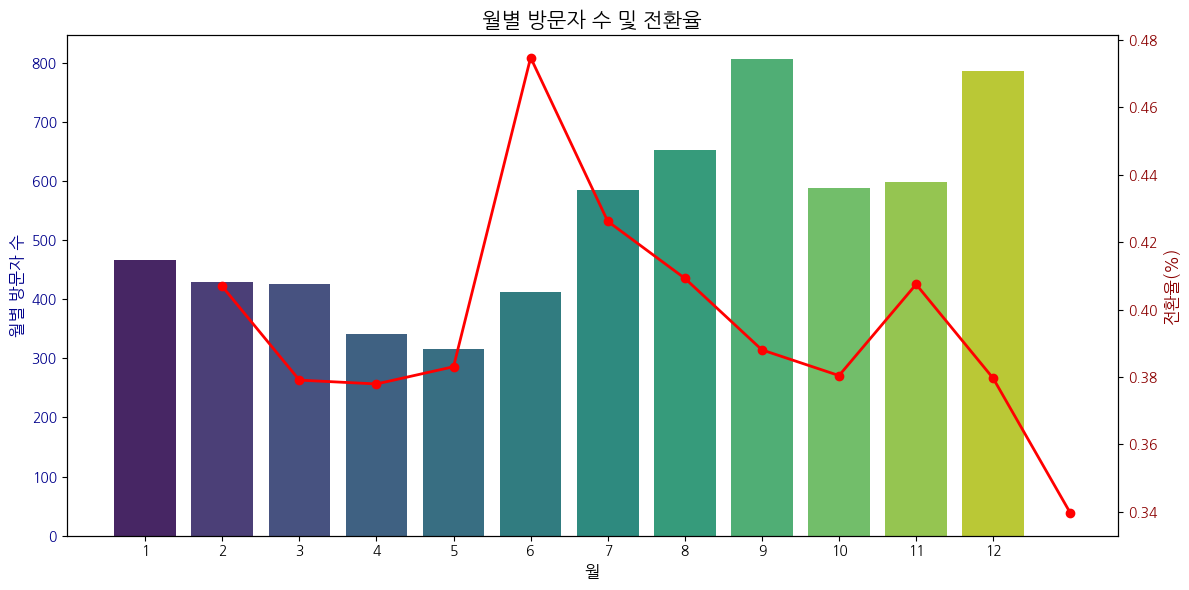

In [ ]:
# 월별 방문자 수와 전환율 이중 Y축 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

# 방문자 수
sns.barplot(x='month', y='visitors', data=monthly_summary, ax=ax1, palette='viridis')
ax1.set_xlabel('월', fontsize=12)
ax1.set_ylabel('월별 방문자 수', color='darkblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='darkblue')

# 전환율
ax2 = ax1.twinx() # x축을 공유하는 두 번째 y축 생성
ax2.plot(monthly_summary['month'], monthly_summary['conversion_rate'], color='red', marker='o', linewidth=2)
ax2.set_ylabel('전환율(%)', color='darkred', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkred')

plt.title('월별 방문자 수 및 전환율', fontsize=15)
fig.tight_layout()
plt.show()

## 사용시간별 전환율

### 유료 전환율

In [ ]:
# 유저별 파생 변수 집계
user_visit_summary = visit_df.groupby('user_uuid').agg(
    total_stay_time=('stay_time_second', 'sum'),           # 3일치 총 체류 시간 (초)
    visit_count=('date', 'count'),                         # 방문 횟수
    active_days=('date', pd.Series.nunique),               # 방문한 고유 날짜 수
    first_visit_date=('date', 'min'),                      # 첫 방문일
    last_visit_date=('date', 'max')                        # 마지막 방문일
).reset_index()

# 평균 체류 시간 (초)
user_visit_summary['avg_stay_time'] = user_visit_summary['total_stay_time'] / user_visit_summary['visit_count']

# 방문 기간 (며칠 간 방문했는지)
user_visit_summary['trial_days_span'] = (user_visit_summary['last_visit_date'] - user_visit_summary['first_visit_date']).dt.days + 1

# 누적 체류 시간(시간 단위) 추가
user_visit_summary['total_stay_hours'] = user_visit_summary['total_stay_time'] / 3600

# 확인
user_visit_summary.head()

user_uuid  total_stay_time  visit_count  \
0  000590dc-046f-462b-8225-4c81a97b7166            21417            1   
1  000be14f-ba0f-4af6-bc2c-7b00dfcbc98c            45569            3   
2  0018e22d-a2cc-4e06-bca2-d6a041770f3b            77372            2   
3  002606d9-38ca-48f3-910c-cbfada9a9109            25024            2   
4  002a7570-90dd-4cab-b0aa-b0e40f7ef27a            23609            2   

   active_days first_visit_date last_visit_date  avg_stay_time  \
0            1       2023-09-05      2023-09-05   21417.000000   
1            3       2021-09-30      2021-10-02   15189.666667   
2            2       2023-11-15      2023-11-16   38686.000000   
3            2       2023-01-07      2023-01-08   12512.000000   
4            2       2021-09-08      2021-09-10   11804.500000   

   trial_days_span  total_stay_hours  
0                1          5.949167  
1                3         12.658056  
2                2         21.492222  
3                2          6.951111  
4                3          6.558056

In [ ]:
# 결제 정보 없는 유저 0, 있는 유저는 1
merged_df = pd.merge(user_visit_summary, payment_df[['user_uuid', 'is_payment']], on='user_uuid', how='left')
merged_df['is_payment'] = merged_df['is_payment'].fillna(0).astype(int)

# 확인
merged_df.head()

user_uuid  total_stay_time  visit_count  \
0  000590dc-046f-462b-8225-4c81a97b7166            21417            1   
1  000be14f-ba0f-4af6-bc2c-7b00dfcbc98c            45569            3   
2  0018e22d-a2cc-4e06-bca2-d6a041770f3b            77372            2   
3  002606d9-38ca-48f3-910c-cbfada9a9109            25024            2   
4  002a7570-90dd-4cab-b0aa-b0e40f7ef27a            23609            2   

   active_days first_visit_date last_visit_date  avg_stay_time  \
0            1       2023-09-05      2023-09-05   21417.000000   
1            3       2021-09-30      2021-10-02   15189.666667   
2            2       2023-11-15      2023-11-16   38686.000000   
3            2       2023-01-07      2023-01-08   12512.000000   
4            2       2021-09-08      2021-09-10   11804.500000   

   trial_days_span  total_stay_hours  is_payment  
0                1          5.949167           0  
1                3         12.658056           1  
2                2         21.492222           0  
3                2          6.951111           0  
4                3          6.558056           1

In [ ]:
# 시간별 유료 전환율 분석
# 누적 체류시간 기준 구간화
bins = [0, 1, 3, 6, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]
labels = ['0~1', '1~3', '3~6', '6~10', '10~15', '15~20', '20~25', '25~30', '30~35', '35~40', '40~45', '45~50', '50+']
merged_df['stay_bin'] = pd.cut(merged_df['total_stay_hours'], bins=bins, labels=labels, right=False)

# 전환율 계산
conversion_by_bin = merged_df.groupby('stay_bin')['is_payment'].agg(['count', 'sum'])
conversion_by_bin['conversion_rate'] = conversion_by_bin['sum'] / conversion_by_bin['count']
conversion_by_bin

count  sum  conversion_rate
stay_bin                             
0~1         522  189         0.362069
1~3        1083  446         0.411819
3~6        1476  574         0.388889
6~10       1280  485         0.378906
10~15       870  352         0.404598
15~20       500  197         0.394000
20~25       266   83         0.312030
25~30       127   38         0.299213
30~35        52   23         0.442308
35~40        19    7         0.368421
40~45         6    3         0.500000
45~50         4    0         0.000000
50+           2    2         1.000000

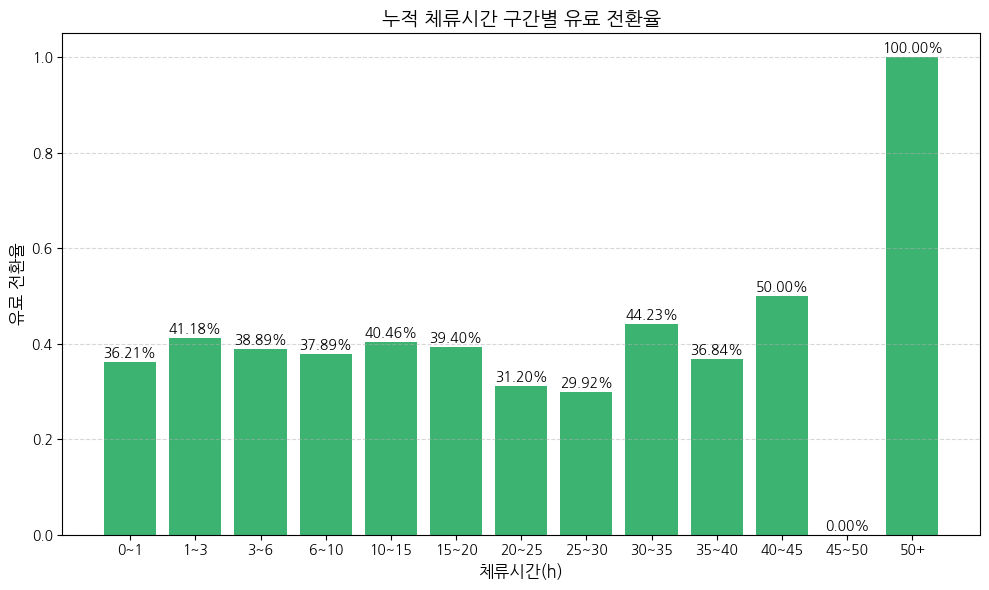

In [ ]:
# 시각화
# 'stay_bin'을 컬럼으로 변환
conversion_by_bin = conversion_by_bin.reset_index()

plt.figure(figsize=(10, 6))
plt.bar(conversion_by_bin['stay_bin'], conversion_by_bin['conversion_rate'], color='mediumseagreen')

# 값 표시
for i, rate in enumerate(conversion_by_bin['conversion_rate']):
    plt.text(i, rate + 0.01, f"{rate:.2%}", ha='center', fontsize=10)

plt.title('누적 체류시간 구간별 유료 전환율', fontsize=14)
plt.xlabel('체류시간(h)', fontsize=12)
plt.ylabel('유료 전환율', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
conversion_by_bin

stay_bin  count  sum  conversion_rate
0       0~1    522  189         0.362069
1       1~3   1083  446         0.411819
2       3~6   1476  574         0.388889
3      6~10   1280  485         0.378906
4     10~15    870  352         0.404598
5     15~20    500  197         0.394000
6     20~25    266   83         0.312030
7     25~30    127   38         0.299213
8     30~35     52   23         0.442308
9     35~40     19    7         0.368421
10    40~45      6    3         0.500000
11    45~50      4    0         0.000000
12      50+      2    2         1.000000

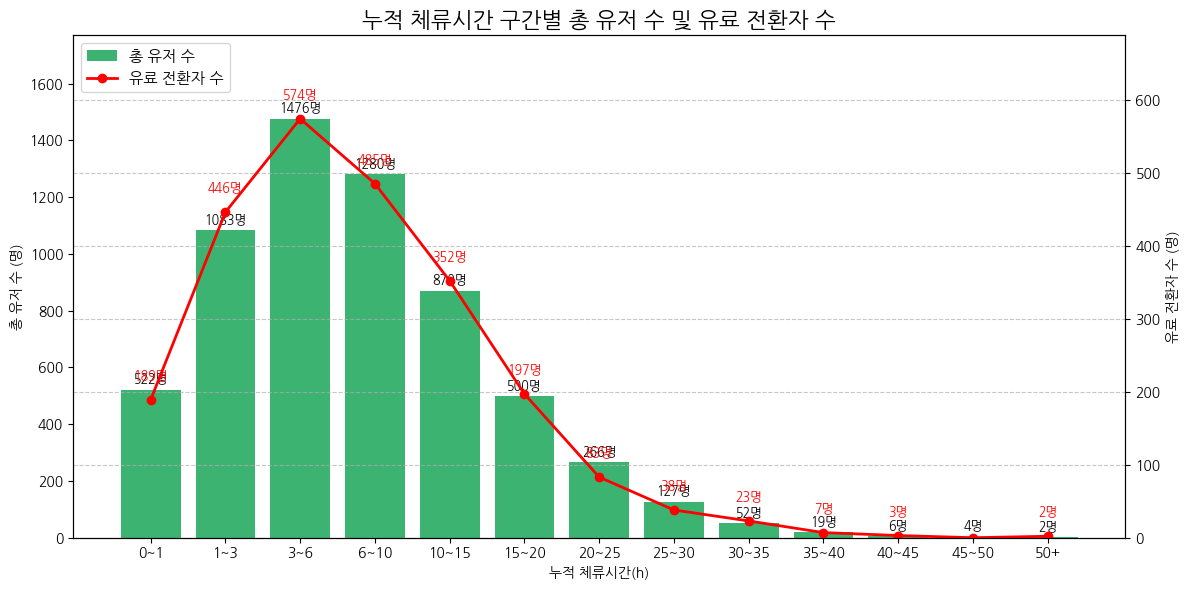

In [ ]:
# 'count' 컬럼을 'users'로, 'sum' 컬럼을 'payers'로 이름 변경
conversion_by_bin = conversion_by_bin.rename(columns={'count': 'users', 'sum': 'payers'})

# --- 비전환자 수 ('non_payers') 계산 (선택 사항이지만, 데이터 일관성을 위해 유지) ---
conversion_by_bin['non_payers'] = conversion_by_bin['users'] - conversion_by_bin['payers']

# --- NaN 값 처리 ---
# 숫자 컬럼에 대해 fillna(0) 적용
numeric_cols_to_fill = ['users', 'payers', 'conversion_rate', 'non_conversion_rate', 'non_payers']
for col in numeric_cols_to_fill:
    if col in conversion_by_bin.columns:
        conversion_by_bin[col] = conversion_by_bin[col].fillna(0)

# 'stay_bin'이 인덱스가 아니라 컬럼임을 확인 (사용자 요청에 따라 reset_index() 추가)
# 이미 컬럼으로 로드되었거나 이전에 reset_index()를 했다면 불필요하지만, 안전하게 추가.
if not isinstance(conversion_by_bin.index, pd.RangeIndex): # 인덱스가 기본 정수 인덱스가 아니라면
    conversion_by_bin = conversion_by_bin.reset_index()


# --- 시각화 ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대: 총 유저 수
bars = ax1.bar(conversion_by_bin['stay_bin'], conversion_by_bin['users'], color='mediumseagreen', label='총 유저 수')
ax1.set_ylabel('총 유저 수 (명)')
ax1.set_xlabel('누적 체류시간(h)')
ax1.tick_params(axis='y')
# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    if height > 0: # 값이 0이 아닐 때만 표시
        ax1.annotate(f'{int(height)}명',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)
ax1.set_ylim(0, conversion_by_bin['users'].max() * 1.2)


# 선: 유료 전환자 수
ax2 = ax1.twinx()
line, = ax2.plot(conversion_by_bin['stay_bin'], conversion_by_bin['payers'], color='red', marker='o', linestyle='-', linewidth=2, label='유료 전환자 수')
ax2.set_ylabel('유료 전환자 수 (명)')
ax2.tick_params(axis='y')

# 선 위에 값 표시
for i, num_payers in enumerate(conversion_by_bin['payers']):
    if num_payers > 0: # 0인 경우는 표시하지 않거나, 다르게 처리
        ax2.annotate(f'{int(num_payers)}명', (i, num_payers),
                     textcoords="offset points", xytext=(0,15), ha='center', color='red', fontsize=9)

ax2.set_ylim(0, conversion_by_bin['payers'].max() * 1.2)


plt.title('누적 체류시간 구간별 총 유저 수 및 유료 전환자 수', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 범례를 두 축 모두에서 가져와 통합적으로 표시
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

site_id       date                  stay_time  stay_time_second  \
86          3 2023-12-29 2025-06-18 15:20:42.919489             55242   
130         6 2023-12-30 2025-06-18 19:35:03.337942             70503   
199         1 2022-08-02 2025-06-18 17:56:06.271040             64566   
330         1 2021-11-18 2025-06-18 22:04:40.807170             79480   
352         1 2022-03-30 2025-06-18 16:48:01.772459             60481   
...       ...        ...                        ...               ...   
11230       2 2022-06-10 2025-06-18 14:00:18.126752             50418   
11261       3 2022-07-17 2025-06-18 22:28:19.943506             80899   
11406       6 2022-06-30 2025-06-18 13:22:01.961594             48121   
11407       6 2022-07-01 2025-06-18 14:09:03.219481             50943   
11458       2 2022-07-14 2025-06-18 13:00:29.228210             46829   

         first_enter_time     last_leave_time  \
86    2023-12-29 00:00:00 2023-12-29 15:26:42   
130   2023-12-30 00:00:00 2023-12-30 20:38:07   
199   2022-08-02 00:00:00 2022-08-02 17:56:06   
330   2021-11-18 00:00:00 2021-11-18 22:04:40   
352   2022-03-30 06:37:55 2022-03-30 23:59:59   
...                   ...                 ...   
11230 2022-06-10 07:25:40 2022-06-10 23:16:13   
11261 2022-07-17 00:00:00 2022-07-17 22:35:30   
11406 2022-06-30 09:31:21 2022-06-30 23:59:59   
11407 2022-07-01 00:00:00 2022-07-01 23:58:32   
11458 2022-07-14 10:28:43 2022-07-14 23:59:59   

                                  user_uuid  enter_hour  month season  \
86     f70fa4ed-8364-499c-8c49-6d232e6c271b           0     12     겨울   
130    fa06b23d-3a20-448f-8791-557beff8df9f           0     12     겨울   
199    25830a77-5fae-412d-9764-dfcdb4cb3455           0      8     여름   
330    44690217-a350-4a1d-a6cc-9d64a908a8a1           0     11     가을   
352    d3723d40-da43-4b44-91cf-0c7aed46da0b           6      3      봄   
...                                     ...         ...    ...    ...   
11230  dd96c84e-3f42-46ae-92ad-ea5a12ab3e46           7      6     여름   
11261  c344f112-416b-43b3-8386-488370edd392           0      7     여름   
11406  dc6cb3d3-b79d-491a-9bcc-0fbab83cea16           9      6     여름   
11407  dc6cb3d3-b79d-491a-9bcc-0fbab83cea16           0      7     여름   
11458  3568e924-df65-4819-ad59-10837033cf73          10      7     여름   

       stay_time_hour  
86          15.345000  
130         19.584167  
199         17.935000  
330         22.077778  
352         16.800278  
...               ...  
11230       14.005000  
11261       22.471944  
11406       13.366944  
11407       14.150833  
11458       13.008056  

[199 rows x 11 columns]

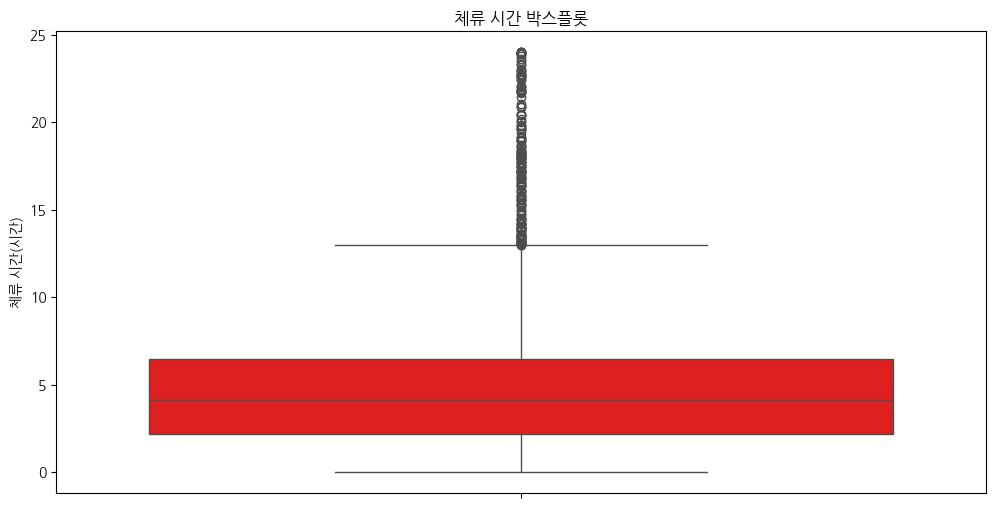

In [ ]:
# stay_time_second 이상치 확인
# stay_time_second 분포 시각화
visit_df = visit_df.dropna()
visit_df['stay_time_hour'] = visit_df['stay_time_second'] / 3600

plt.figure(figsize=(12, 6))
sns.boxplot(y=visit_df['stay_time_hour'], color='red')
plt.title('체류 시간 박스플롯')
plt.ylabel('체류 시간(시간)')

# IQR을 이용한 이상치 감지
Q1 = visit_df['stay_time_hour'].quantile(0.25)
Q3 = visit_df['stay_time_hour'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = visit_df[(visit_df['stay_time_hour'] < lower_bound) | (visit_df['stay_time_hour'] > upper_bound)]
outliers

### 일일 체류시간별 유료 전환율

In [ ]:
# 일별 체류 시간 요약 (user + date 단위)
daily_stay_summary = visit_df.groupby(['user_uuid', 'date']).agg(
    daily_stay_time=('stay_time_second', 'sum')  # 하루 체류 시간 (초)
).reset_index()

# 시간 단위로 변환
daily_stay_summary['daily_stay_hours'] = daily_stay_summary['daily_stay_time'] / 3600

In [ ]:
# 유저별 일평균 체류시간 계산
avg_daily_stay = daily_stay_summary.groupby('user_uuid').agg(
    avg_daily_stay_hours=('daily_stay_hours', 'mean')
).reset_index()

In [ ]:
# payment_df와 병합
user_daily_conversion = pd.merge(avg_daily_stay, payment_df[['user_uuid', 'is_payment']], on='user_uuid', how='left')
user_daily_conversion['is_payment'] = user_daily_conversion['is_payment'].fillna(0).astype(int)

In [ ]:
# 구간 설정 (0~1, 1~2, ..., 5시간 이상은 5+)
bins = list(range(25)) + [float('inf')]
labels = [f'{i}-{i+1}h' for i in range(24)] + ['24h+']

user_daily_conversion['stay_group'] = pd.cut(user_daily_conversion['avg_daily_stay_hours'], bins=bins, labels=labels, right=False)

# 전환율 집계
stay_conversion = user_daily_conversion.groupby('stay_group').agg(
    users=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()

stay_conversion['conversion_rate'] = stay_conversion['payers'] / stay_conversion['users']

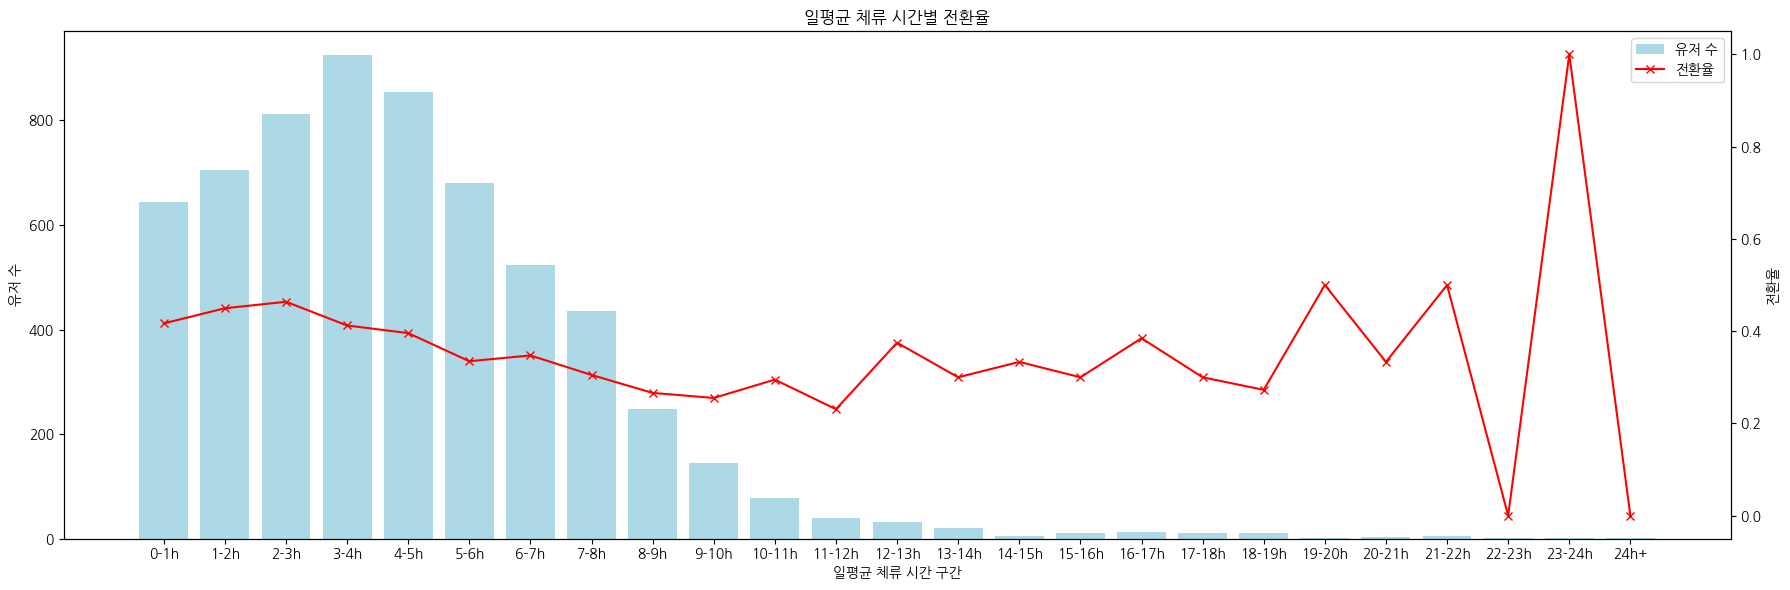

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 6))

# 막대: 유저 수
ax1.bar(stay_conversion['stay_group'], stay_conversion['users'], color='lightblue', label='유저 수')
ax1.set_ylabel('유저 수')
ax1.set_xlabel('일평균 체류 시간 구간')

# 선: 전환율
ax2 = ax1.twinx()
ax2.plot(stay_conversion['stay_group'], stay_conversion['conversion_rate'], color='red', marker='x', label='전환율')
ax2.set_ylabel('전환율')

plt.title('일평균 체류 시간별 전환율')
plt.grid(axis='x', linestyle='--', alpha=0.5)
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()

In [ ]:
stay_conversion

stay_group  users  payers  conversion_rate
0        0-1h    643     268         0.416796
1        1-2h    705     317         0.449645
2        2-3h    813     377         0.463715
3        3-4h    924     381         0.412338
4        4-5h    854     338         0.395785
5        5-6h    681     228         0.334802
6        6-7h    524     182         0.347328
7        7-8h    436     133         0.305046
8        8-9h    248      66         0.266129
9       9-10h    145      37         0.255172
10     10-11h     78      23         0.294872
11     11-12h     39       9         0.230769
12     12-13h     32      12         0.375000
13     13-14h     20       6         0.300000
14     14-15h      6       2         0.333333
15     15-16h     10       3         0.300000
16     16-17h     13       5         0.384615
17     17-18h     10       3         0.300000
18     18-19h     11       3         0.272727
19     19-20h      2       1         0.500000
20     20-21h      3       1         0.333333
21     21-22h      6       3         0.500000
22     22-23h      2       0         0.000000
23     23-24h      1       1         1.000000
24       24h+      1       0         0.000000

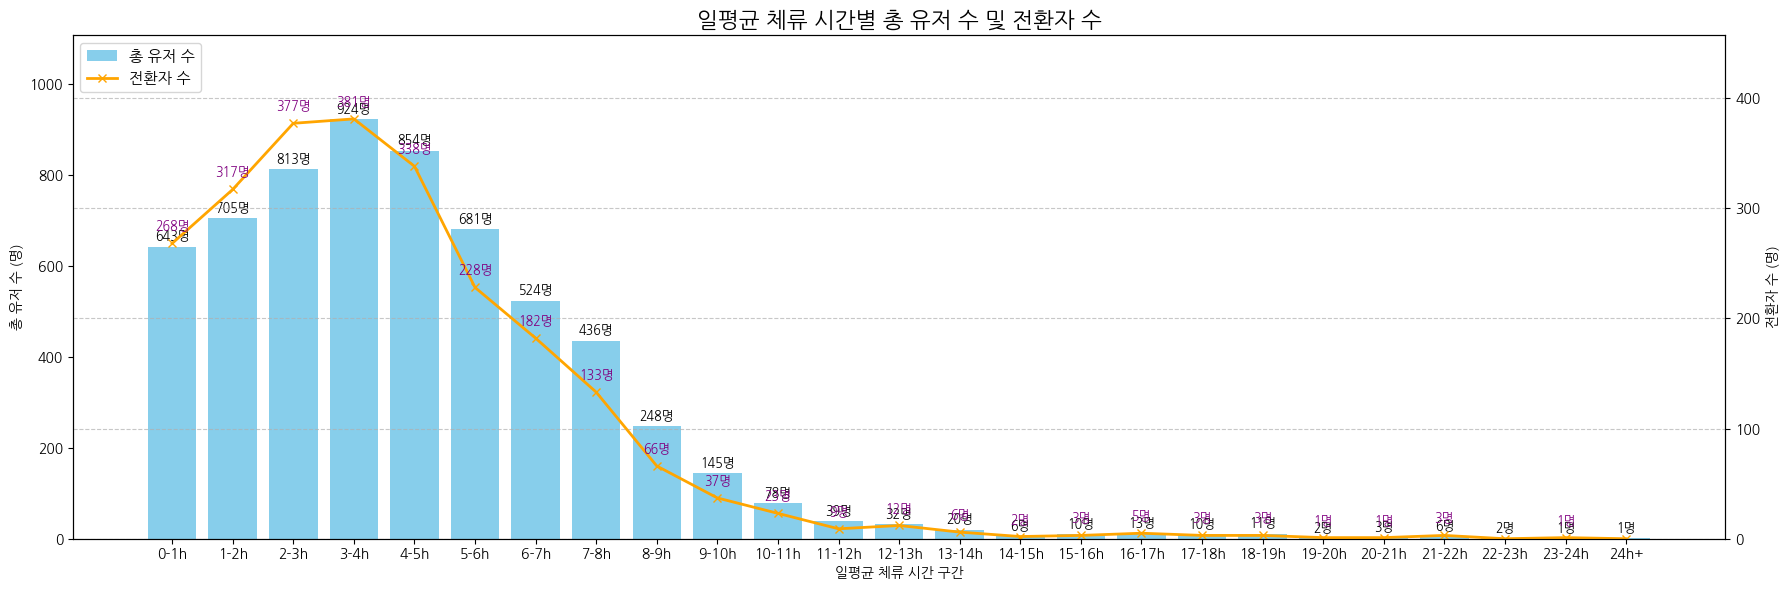

In [ ]:
numeric_cols_to_fill = ['users', 'payers', 'conversion_rate', 'non_conversion_rate', 'non_payers']
for col in numeric_cols_to_fill:
    if col in stay_conversion.columns:
        stay_conversion[col] = stay_conversion[col].fillna(0)

#  시각화 코드
fig, ax1 = plt.subplots(figsize=(18, 6))

# 막대: 유저 수
bars = ax1.bar(stay_conversion['stay_group'], stay_conversion['users'], color='skyblue', label='총 유저 수')
ax1.set_ylabel('총 유저 수 (명)')
ax1.set_xlabel('일평균 체류 시간 구간')
ax1.tick_params(axis='y') # y축 레이블 색상 통일
ax1.bar_label(bars, labels=[f'{int(v)}명' for v in stay_conversion['users']], padding=3, fontsize=9)
ax1.set_ylim(0, stay_conversion['users'].max() * 1.2) # y축 범위 조정


# 선: 전환자 수
ax2 = ax1.twinx()
# 'conversion_rate' 대신 'payers' 컬럼을 사용합니다.
line, = ax2.plot(stay_conversion['stay_group'], stay_conversion['payers'], color='orange', marker='x', linestyle='-', linewidth=2, label='전환자 수')
ax2.set_ylabel('전환자 수 (명)') # y축 레이블 변경
ax2.tick_params(axis='y') # y축 레이블 색상 통일

# 전환자 수 값을 선 위에 표시
for i, num_payers in enumerate(stay_conversion['payers']):
    if num_payers > 0: # 0인 경우는 표시하지 않거나, 다르게 처리
        ax2.annotate(f'{int(num_payers)}명', (i, num_payers), textcoords="offset points", xytext=(0,10), ha='center', color='purple', fontsize=9)

# ax2의 y축 범위도 설정해주는 것이 좋습니다.
ax2.set_ylim(0, stay_conversion['payers'].max() * 1.2)


plt.title('일평균 체류 시간별 총 유저 수 및 전환자 수', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7) # y축 그리드만 표시

# 범례를 두 축 모두에서 가져와 통합적으로 표시
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

### 유료 비전환율

In [ ]:
conversion_by_bin['non_conversion_rate'] = 1 - conversion_by_bin['conversion_rate']

In [ ]:
conversion_by_bin

stay_bin  users  payers  conversion_rate  non_payers  non_conversion_rate
0       0~1    522     189         0.362069         333             0.637931
1       1~3   1083     446         0.411819         637             0.588181
2       3~6   1476     574         0.388889         902             0.611111
3      6~10   1280     485         0.378906         795             0.621094
4     10~15    870     352         0.404598         518             0.595402
5     15~20    500     197         0.394000         303             0.606000
6     20~25    266      83         0.312030         183             0.687970
7     25~30    127      38         0.299213          89             0.700787
8     30~35     52      23         0.442308          29             0.557692
9     35~40     19       7         0.368421          12             0.631579
10    40~45      6       3         0.500000           3             0.500000
11    45~50      4       0         0.000000           4             1.000000
12      50+      2       2         1.000000           0             0.000000

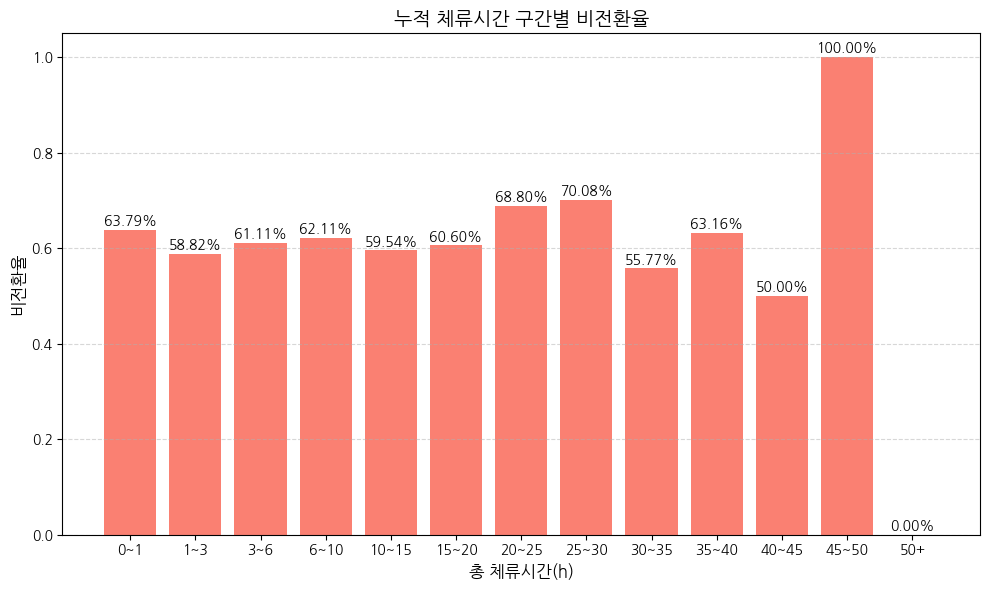

In [ ]:
# 시각화
plt.figure(figsize=(10, 6))
plt.bar(conversion_by_bin['stay_bin'], conversion_by_bin['non_conversion_rate'], color='salmon')

for i, rate in enumerate(conversion_by_bin['non_conversion_rate']):
    plt.text(i, rate + 0.01, f"{rate:.2%}", ha='center', fontsize=10)

plt.title('누적 체류시간 구간별 비전환율', fontsize=14)
plt.xlabel('총 체류시간(h)', fontsize=12)
plt.ylabel('비전환율', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

--- 'conversion_by_bin' 데이터프레임 (비전환자 수 계산 후) ---
  stay_bin  users  payers  non_payers  non_conversion_rate
0      0~1    522     189         333             0.637931
1      1~3   1083     446         637             0.588181
2      3~6   1476     574         902             0.611111
3     6~10   1280     485         795             0.621094
4    10~15    870     352         518             0.595402




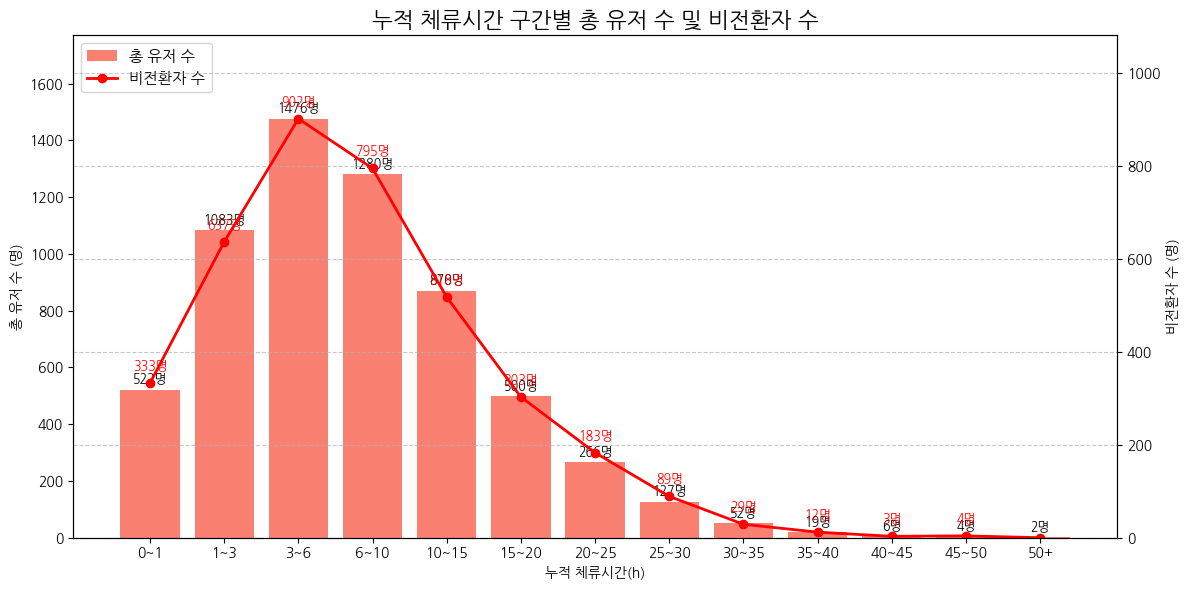

In [ ]:

# 'count' 컬럼을 'users'로, 'sum' 컬럼을 'payers'로 이름 변경
conversion_by_bin = conversion_by_bin.rename(columns={'count': 'users', 'sum': 'payers'})

# --- 비전환자 수 ('non_payers') 계산 ---
# 'non_payers' = 'users' - 'payers'
conversion_by_bin['non_payers'] = conversion_by_bin['users'] - conversion_by_bin['payers']


# --- NaN 값 처리 ---
# 숫자 컬럼 (새로 생성된 'non_payers' 포함)에 대해 fillna(0) 적용
numeric_cols_to_fill = ['users', 'payers', 'conversion_rate', 'non_conversion_rate', 'non_payers']
for col in numeric_cols_to_fill:
    if col in conversion_by_bin.columns:
        conversion_by_bin[col] = conversion_by_bin[col].fillna(0)

# 계산된 데이터 확인
print("--- 'conversion_by_bin' 데이터프레임 (비전환자 수 계산 후) ---")
print(conversion_by_bin[['stay_bin', 'users', 'payers', 'non_payers', 'non_conversion_rate']].head())
print("\n")

# --- 시각화 ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대: 총 유저 수
bars = ax1.bar(conversion_by_bin['stay_bin'], conversion_by_bin['users'], color='salmon', label='총 유저 수')
ax1.set_ylabel('총 유저 수 (명)')
ax1.set_xlabel('누적 체류시간(h)')
ax1.tick_params(axis='y')
# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    if height > 0: # 값이 0이 아닐 때만 표시
        ax1.annotate(f'{int(height)}명',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)
ax1.set_ylim(0, conversion_by_bin['users'].max() * 1.2)


# 선: 비전환자 수
ax2 = ax1.twinx()
line, = ax2.plot(conversion_by_bin['stay_bin'], conversion_by_bin['non_payers'], color='red', marker='o', linestyle='-', linewidth=2, label='비전환자 수')
ax2.set_ylabel('비전환자 수 (명)')
ax2.tick_params(axis='y')

# 선 위에 값 표시
for i, num_non_payers in enumerate(conversion_by_bin['non_payers']):
    if num_non_payers > 0: # 0인 경우는 표시하지 않거나, 다르게 처리
        ax2.annotate(f'{int(num_non_payers)}명', (i, num_non_payers),
                     textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=9)

ax2.set_ylim(0, conversion_by_bin['non_payers'].max() * 1.2)


plt.title('누적 체류시간 구간별 총 유저 수 및 비전환자 수', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 범례를 두 축 모두에서 가져와 통합적으로 표시
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

### 일일 체류시간별 비전환율

In [ ]:
stay_conversion['non_conversion_rate'] = 1 - stay_conversion['conversion_rate']

In [ ]:
stay_conversion['non_payers'] = stay_conversion['users'] - stay_conversion['payers']
stay_conversion['non_conversion_rate'] = stay_conversion['non_payers'] / stay_conversion['users']

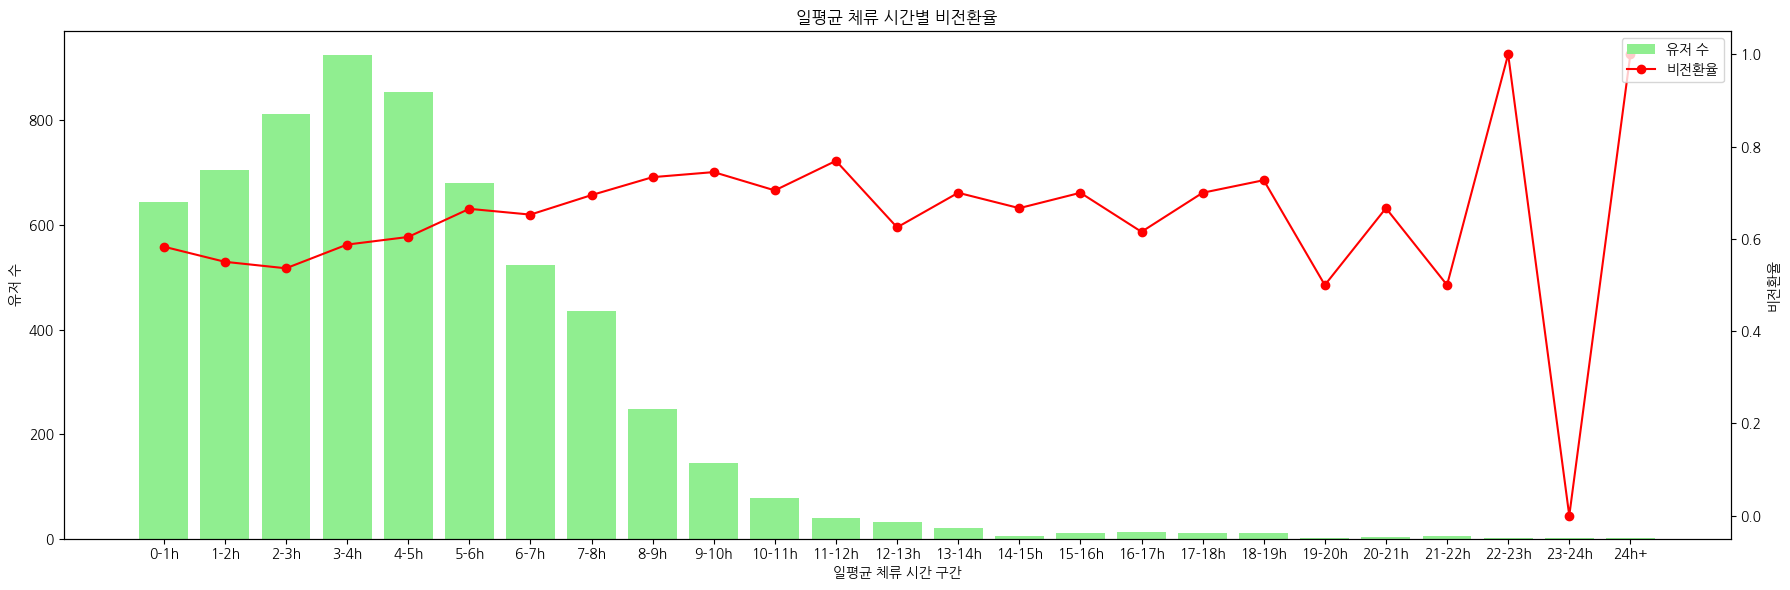

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 6))

# 막대: 유저 수
ax1.bar(stay_conversion['stay_group'], stay_conversion['users'], color='lightgreen', label='유저 수')
ax1.set_ylabel('유저 수')
ax1.set_xlabel('일평균 체류 시간 구간')

# 선: 비전환율
ax2 = ax1.twinx()
ax2.plot(stay_conversion['stay_group'], stay_conversion['non_conversion_rate'], color='red', marker='o', label='비전환율')
ax2.set_ylabel('비전환율')

plt.title('일평균 체류 시간별 비전환율')
plt.grid(axis='x', linestyle='--', alpha=0.5)
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()

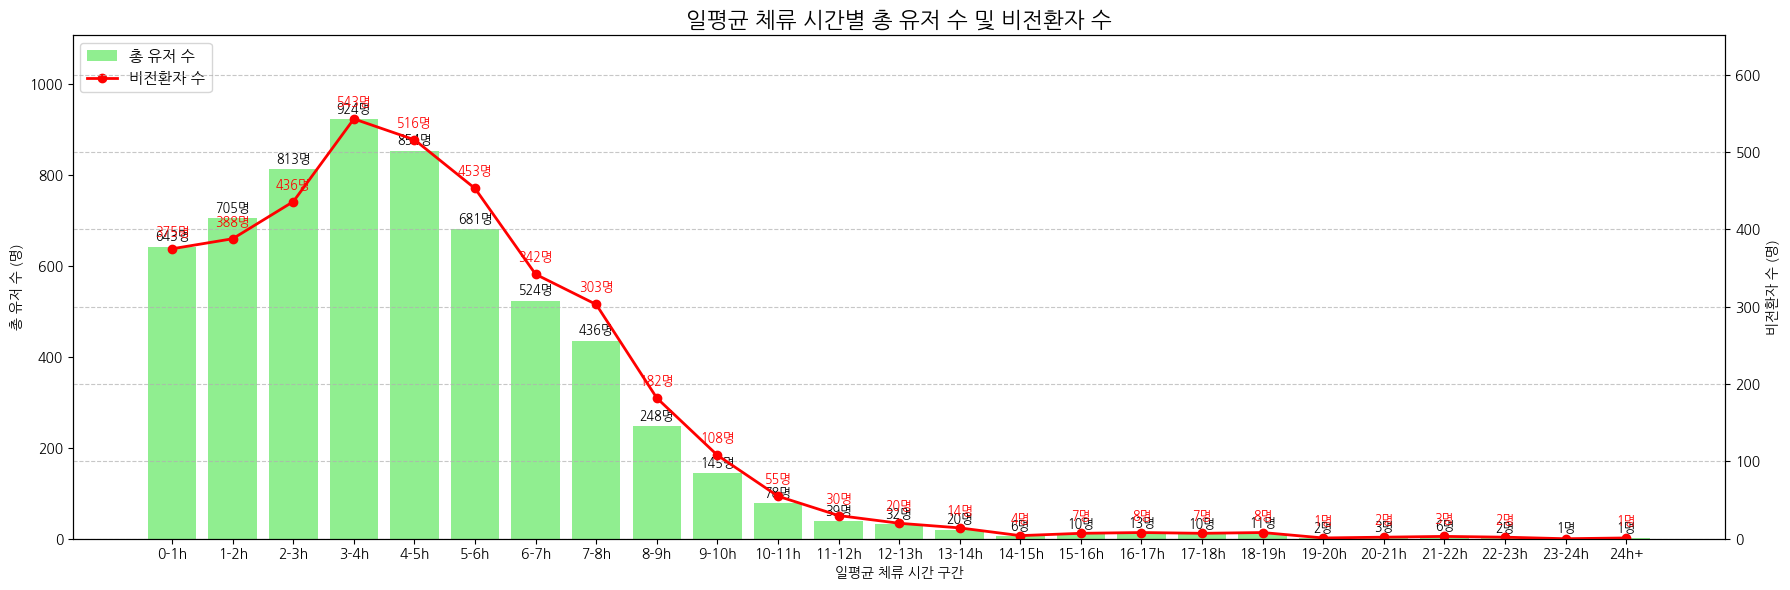

In [ ]:
# --- NaN 값 처리 (이전과 동일하게 특정 컬럼만 처리) ---
numeric_cols_to_fill = ['users', 'payers', 'conversion_rate', 'non_conversion_rate', 'non_payers']
for col in numeric_cols_to_fill:
    if col in stay_conversion.columns:
        stay_conversion[col] = stay_conversion[col].fillna(0)


# --- 시각화 코드 ---
fig, ax1 = plt.subplots(figsize=(18, 6))

# 막대: 유저 수 (총 유저 수로 레이블 변경)
bars = ax1.bar(stay_conversion['stay_group'], stay_conversion['users'], color='lightgreen', label='총 유저 수')
ax1.set_ylabel('총 유저 수 (명)')
ax1.set_xlabel('일평균 체류 시간 구간')
ax1.tick_params(axis='y')
ax1.bar_label(bars, labels=[f'{int(v)}명' for v in stay_conversion['users']], padding=3, fontsize=9)
ax1.set_ylim(0, stay_conversion['users'].max() * 1.2)


# 선: 비전환자 수
ax2 = ax1.twinx()
# 'non_conversion_rate' 대신 'non_payers' 컬럼을 사용합니다.
line, = ax2.plot(stay_conversion['stay_group'], stay_conversion['non_payers'], color='red', marker='o', linestyle='-', linewidth=2, label='비전환자 수')
ax2.set_ylabel('비전환자 수 (명)') # y축 레이블 변경
ax2.tick_params(axis='y')

# 비전환자 수 값을 선 위에 표시
for i, num_non_payers in enumerate(stay_conversion['non_payers']):
    if num_non_payers > 0: # 0인 경우는 표시하지 않거나, 다르게 처리
        ax2.annotate(f'{int(num_non_payers)}명', (i, num_non_payers), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=9)

# ax2의 y축 범위도 설정해주는 것이 좋습니다.
ax2.set_ylim(0, stay_conversion['non_payers'].max() * 1.2)


plt.title('일평균 체류 시간별 총 유저 수 및 비전환자 수', fontsize=16) # 제목 변경
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 범례를 두 축 모두에서 가져와 통합적으로 표시
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

## 입실/퇴실 시간대별 전환율

In [ ]:
visit_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10922 entries, 0 to 11476
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   site_id           10922 non-null  category      
 1   date              10922 non-null  datetime64[ns]
 2   stay_time         10922 non-null  datetime64[ns]
 3   stay_time_second  10922 non-null  int64         
 4   first_enter_time  10922 non-null  datetime64[ns]
 5   last_leave_time   10922 non-null  datetime64[ns]
 6   user_uuid         10922 non-null  object        
 7   enter_hour        10922 non-null  int32         
 8   month             10922 non-null  int32         
 9   season            10922 non-null  object        
 10  stay_time_hour    10922 non-null  float64       
dtypes: category(1), datetime64[ns](4), float64(1), int32(2), int64(1), object(2)
memory usage: 864.3+ KB


In [ ]:
# 시간대 추출
visit_df['enter_hour'] = visit_df['first_enter_time'].dt.hour
visit_df['leave_hour'] = visit_df['last_leave_time'].dt.hour

In [ ]:
# 등록 및 결제 데이터 병합
user_df = pd.merge(register_df, payment_df, on='user_uuid', how='inner')

# 방문 정보와 병합 (user_uuid 기준)
merged_df1 = pd.merge(visit_df, user_df, on='user_uuid', how='inner')

# 결측값 제거
merged_df1 = merged_df1.dropna(subset=['enter_hour', 'leave_hour'])

In [ ]:
# 입실 시간
enter_stats = merged_df1.groupby('enter_hour')['is_payment'].agg(
    total_users='count',
    total_paid='sum'
).reset_index()

enter_stats['total_unpaid'] = enter_stats['total_users'] - enter_stats['total_paid']
enter_stats['conversion_rate'] = enter_stats['total_paid'] / enter_stats['total_users']
enter_stats['non_conversion_rate'] = enter_stats['total_unpaid'] / enter_stats['total_users']

In [ ]:
# 퇴실 시간대
leave_stats = merged_df1.groupby('leave_hour')['is_payment'].agg(
    total_users='count',
    total_paid='sum'
).reset_index()

leave_stats['total_unpaid'] = leave_stats['total_users'] - leave_stats['total_paid']
leave_stats['conversion_rate'] = leave_stats['total_paid'] / leave_stats['total_users']
leave_stats['non_conversion_rate'] = leave_stats['total_unpaid'] / leave_stats['total_users']

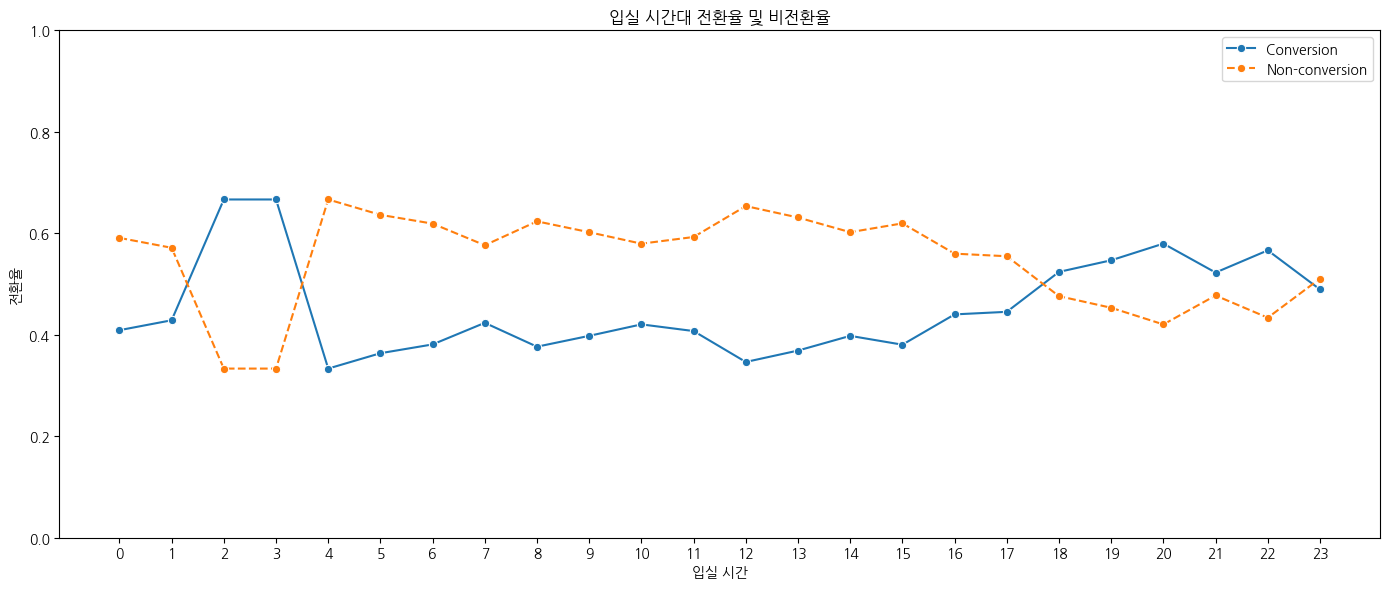

In [ ]:
# 입실 시간대 전환율
plt.figure(figsize=(14, 6))
sns.lineplot(data=enter_stats, x='enter_hour', y='conversion_rate', label='Conversion', marker='o')
sns.lineplot(data=enter_stats, x='enter_hour', y='non_conversion_rate', label='Non-conversion', marker='o', linestyle='--')
plt.title('입실 시간대 전환율 및 비전환율')
plt.xlabel('입실 시간')
plt.ylabel('전환율')
plt.xticks(range(0, 24))
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
enter_stats

enter_hour  total_users  total_paid  total_unpaid  conversion_rate  \
0            0          863         353           510         0.409038   
1            1           28          12            16         0.428571   
2            2            6           4             2         0.666667   
3            3            9           6             3         0.666667   
4            4            6           2             4         0.333333   
5            5           11           4             7         0.363636   
6            6           21           8            13         0.380952   
7            7          170          72            98         0.423529   
8            8          425         160           265         0.376471   
9            9          842         335           507         0.397862   
10          10          880         370           510         0.420455   
11          11          739         301           438         0.407307   
12          12          947         328           619         0.346357   
13          13         1239         457           782         0.368846   
14          14         1199         477           722         0.397832   
15          15          920         350           570         0.380435   
16          16          543         239           304         0.440147   
17          17          438         195           243         0.445205   
18          18          502         263           239         0.523904   
19          19          470         257           213         0.546809   
20          20          314         182           132         0.579618   
21          21          199         104            95         0.522613   
22          22          113          64            49         0.566372   
23          23           47          23            24         0.489362   

    non_conversion_rate  
0              0.590962  
1              0.571429  
2              0.333333  
3              0.333333  
4              0.666667  
5              0.636364  
6              0.619048  
7              0.576471  
8              0.623529  
9              0.602138  
10             0.579545  
11             0.592693  
12             0.653643  
13             0.631154  
14             0.602168  
15             0.619565  
16             0.559853  
17             0.554795  
18             0.476096  
19             0.453191  
20             0.420382  
21             0.477387  
22             0.433628  
23             0.510638

In [ ]:
leave_stats

leave_hour  total_users  total_paid  total_unpaid  conversion_rate  \
0            0          118          55            63         0.466102   
1            1           68          29            39         0.426471   
2            2           47          25            22         0.531915   
3            3           27          11            16         0.407407   
4            4           28          12            16         0.428571   
5            5           14           6             8         0.428571   
6            6           20           6            14         0.300000   
7            7           19           5            14         0.263158   
8            8           46          24            22         0.521739   
9            9           48          19            29         0.395833   
10          10           89          43            46         0.483146   
11          11          166          62           104         0.373494   
12          12          253         127           126         0.501976   
13          13          239         107           132         0.447699   
14          14          260         118           142         0.453846   
15          15          479         209           270         0.436326   
16          16          798         310           488         0.388471   
17          17         1250         495           755         0.396000   
18          18         1393         579           814         0.415650   
19          19         1064         436           628         0.409774   
20          20          865         355           510         0.410405   
21          21          998         457           541         0.457916   
22          22         1010         386           624         0.382178   
23          23         1632         690           942         0.422794   

    non_conversion_rate  
0              0.533898  
1              0.573529  
2              0.468085  
3              0.592593  
4              0.571429  
5              0.571429  
6              0.700000  
7              0.736842  
8              0.478261  
9              0.604167  
10             0.516854  
11             0.626506  
12             0.498024  
13             0.552301  
14             0.546154  
15             0.563674  
16             0.611529  
17             0.604000  
18             0.584350  
19             0.590226  
20             0.589595  
21             0.542084  
22             0.617822  
23             0.577206

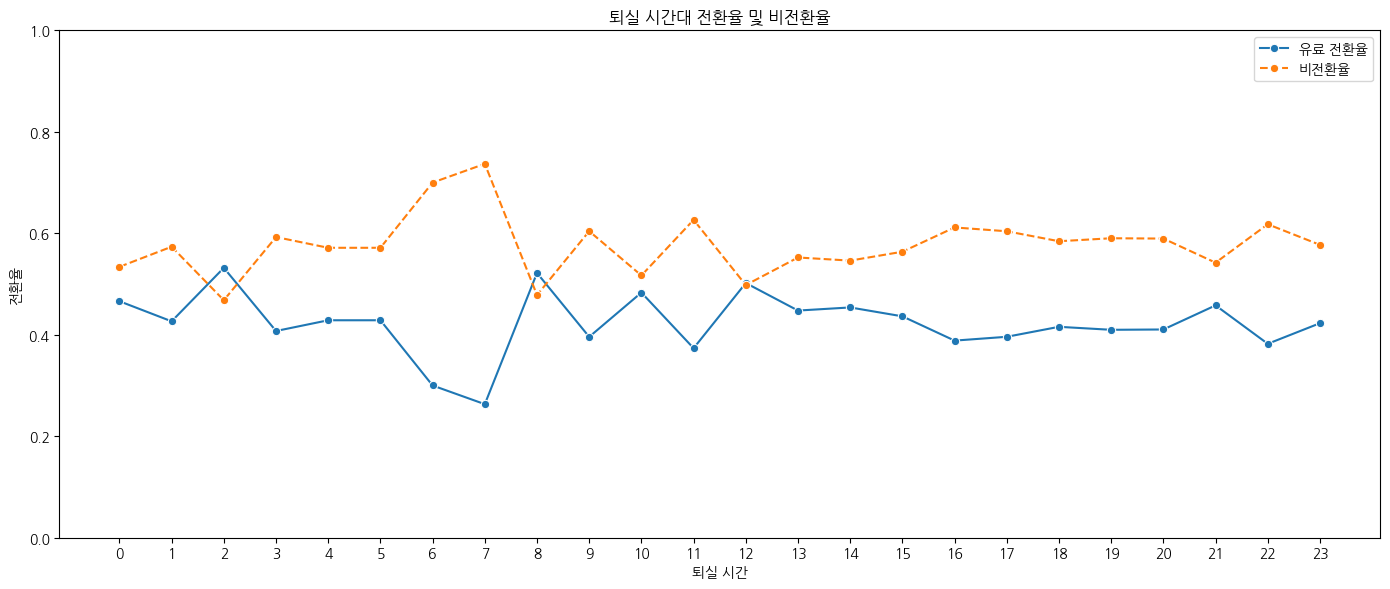

In [ ]:
# 퇴실 시간대 전환율
plt.figure(figsize=(14, 6))
sns.lineplot(data=leave_stats, x='leave_hour', y='conversion_rate', label='유료 전환율', marker='o')
sns.lineplot(data=leave_stats, x='leave_hour', y='non_conversion_rate', label='비전환율', marker='o', linestyle='--')
plt.title('퇴실 시간대 전환율 및 비전환율')
plt.xlabel('퇴실 시간')
plt.ylabel('전환율')
plt.xticks(range(0, 24))
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

### 입실 시간

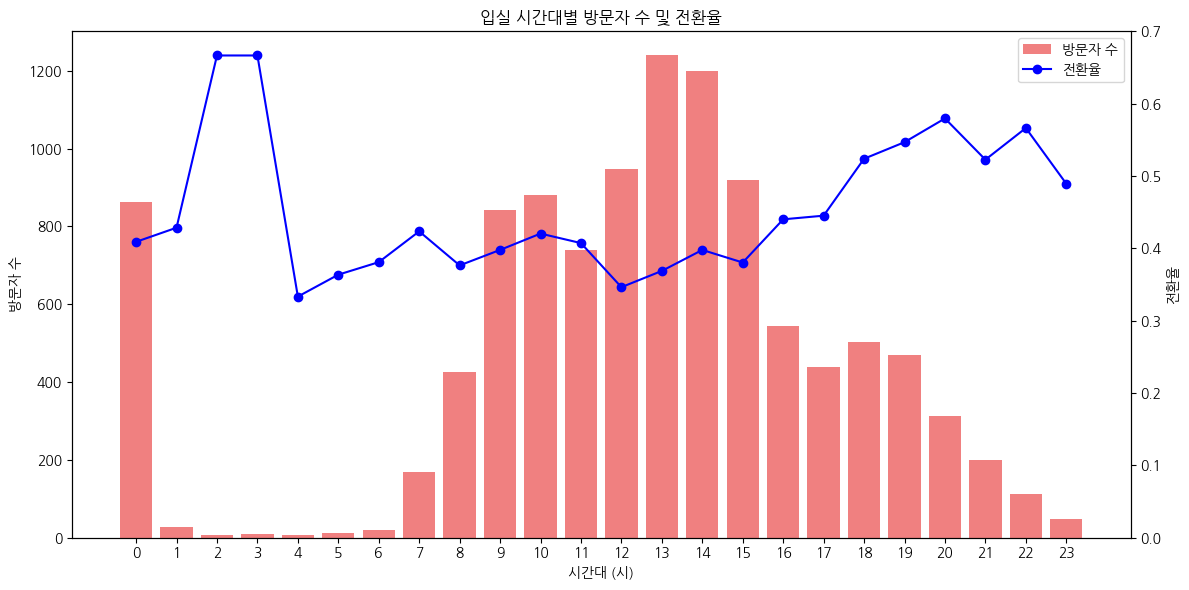

In [ ]:
# 입실 시간대
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(enter_stats['enter_hour'], enter_stats['total_users'], color='lightcoral', label='방문자 수')
ax1.set_xlabel('시간대 (시)')
ax1.set_ylabel('방문자 수')
ax1.tick_params(axis='y')
ax1.set_xticks(range(0, 24))

ax2 = ax1.twinx()
ax2.plot(enter_stats['enter_hour'], enter_stats['conversion_rate'], color='blue', marker='o', label='전환율')
ax2.set_ylabel('전환율')
ax2.tick_params(axis='y')
ax2.set_ylim(0, 0.7)

plt.title('입실 시간대별 방문자 수 및 전환율')

# 범례 합치기
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()

### 퇴실 시간

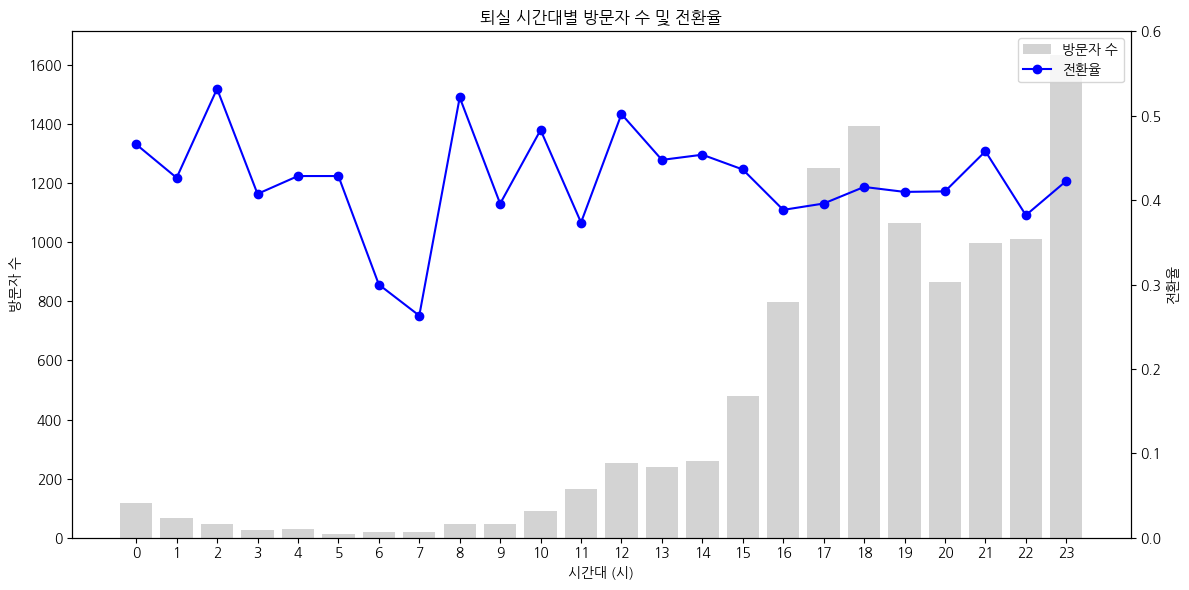

In [ ]:
# 퇴실 시간대
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(leave_stats['leave_hour'], leave_stats['total_users'], color='lightgray', label='방문자 수')
ax1.set_xlabel('시간대 (시)')
ax1.set_ylabel('방문자 수')
ax1.tick_params(axis='y')
ax1.set_xticks(range(0, 24))

ax2 = ax1.twinx()
ax2.plot(leave_stats['leave_hour'], leave_stats['conversion_rate'], color='blue', marker='o', label='전환율')
ax2.set_ylabel('전환율')
ax2.tick_params(axis='y')
ax2.set_ylim(0, 0.6)

plt.title('퇴실 시간대별 방문자 수 및 전환율')

# 범례 합치기
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()

## 시간대/일별 유저 사용흐름 분석(log)

- ✅ 조건
    - 세션 단위로 유저 행동 흐름 묶기
        - 같은 유저의 연속 출입기록을 하나의 '세션'으로 묶어서 분석
        - 유저가 하루에도 여러번 입퇴장 반복할 수 있음 -> 출입 로그부터 세션단위로 묶음
        - 같은 유저가 하루에 여러 번 입퇴장하더라도 독립적인 세션으로 집계됨
    - 입장로그만 있을 경우 NaT 처리
    - 퇴장만 있고 입장이 없는 로그는 제거 (데이터 품질 이슈)

In [ ]:
# user_uuid 기준, 시간 순 정렬
trial_access_log_final = trial_access_log_final.sort_values(by=['user_uuid', 'cdate']).reset_index(drop=True)

# 결과를 담을 리스트
session_records = []

# 유저별 반복
for user, group in trial_access_log_final.groupby('user_uuid'):
    group = group.sort_values(by='cdate')
    session_start = None

    for _, row in group.iterrows():
        if row['checkin'] == 1:
            # 입장 로그 발견 시 세션 시작
            session_start = row['cdate']
        elif row['checkin'] == 2 and session_start is not None:
            # 퇴장 로그가 있고 이전에 입장이 있었을 경우 세션 기록
            session_end = row['cdate']
            duration = (session_end - session_start).total_seconds() / 60
            session_records.append({
                'user_uuid': user,
                'session_start': session_start,
                'session_end': session_end,
                'duration_min': duration,
                'weekday': session_start.strftime('%a'),
                'hour': session_start.hour
            })
            session_start = None  # 세션 종료 → 초기화

    # 세션 시작했지만 퇴장 없이 끝난 경우 (NaT 처리)
    if session_start is not None:
        session_records.append({
            'user_uuid': user,
            'session_start': session_start,
            'session_end': pd.NaT,
            'duration_min': None,
            'weekday': session_start.strftime('%a'),
            'hour': session_start.hour
        })

# 세션 단위 데이터프레임 생성
df_sessions = pd.DataFrame(session_records)

# 결과 확인
print(df_sessions.head())

                              user_uuid       session_start  \
0  000590dc-046f-462b-8225-4c81a97b7166 2023-09-05 02:57:01   
1  000590dc-046f-462b-8225-4c81a97b7166 2023-09-05 04:27:46   
2  000590dc-046f-462b-8225-4c81a97b7166 2023-09-05 07:16:13   
3  000be14f-ba0f-4af6-bc2c-7b00dfcbc98c 2021-09-30 07:31:14   
4  000be14f-ba0f-4af6-bc2c-7b00dfcbc98c 2021-09-30 07:39:34   

          session_end  duration_min weekday  hour  
0 2023-09-05 04:24:05     87.066667     Tue     2  
1 2023-09-05 07:14:07    166.350000     Tue     4  
2 2023-09-05 08:59:45    103.533333     Tue     7  
3 2021-09-30 07:39:16      8.033333     Thu     7  
4 2021-09-30 07:41:07      1.550000     Thu     7  


### 요일+시간대별 세션 수 히트맵

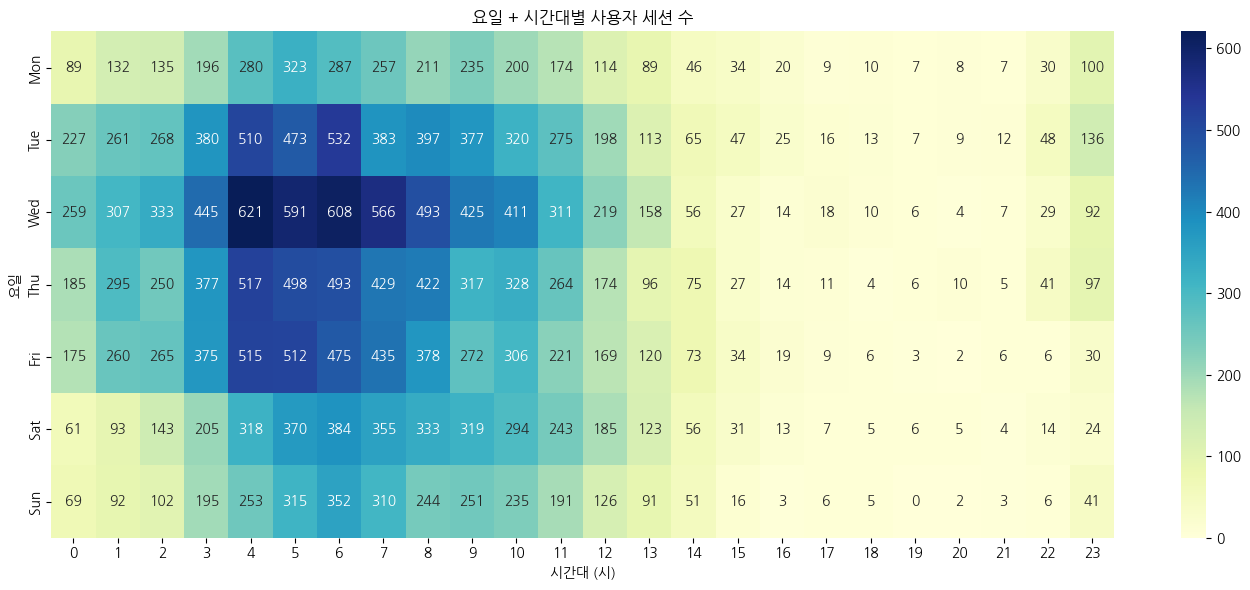

In [ ]:
# 요일 순서 지정 (월~일)
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df_sessions['weekday'] = pd.Categorical(df_sessions['weekday'], categories=weekday_order, ordered=True)

# 피벗 테이블 생성: 요일 x 시간대 → 세션 수
pivot_table = df_sessions.pivot_table(
    index='weekday',
    columns='hour',
    values='user_uuid',
    aggfunc='count',
    fill_value=0
)

# 시각화
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='d')
plt.title('요일 + 시간대별 사용자 세션 수')
plt.xlabel('시간대 (시)')
plt.ylabel('요일')
plt.tight_layout()
plt.show()

- 이용량 밀도 확인
    - 수요일 오전 5~7시에 세션 수가 가장 많음 → 출근 시간대 집중
    - 주말 오전~오후는 상대적으로 고르게 분포

### 요일+평균체류시간

- 출입 시간은 무시하고, 요일별 평균 사용 시간의 차이를 확인
- 퇴장 로그가 없어서 duration이 NaN인 세션은 제외

In [ ]:
# NaN 제거하고 요일별 평균 체류시간 계산
avg_duration = df_sessions.dropna(subset=['duration_min']).groupby('weekday')['duration_min'].mean().reindex(weekday_order)

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_duration.index, y=avg_duration.values, palette='viridis')
plt.title('요일별 평균 체류시간 (분)')
plt.xlabel('요일')
plt.ylabel('평균 체류시간 (분)')
plt.ylim(0, avg_duration.max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 요일+시간대+평균 체류시간

In [ ]:
# NaN 제거 후 피벗 테이블 생성 (요일 x 시간대 조합 평균 체류시간)
pivot_avg_duration = df_sessions.dropna(subset=['duration_min']).pivot_table(
    index='weekday',
    columns='hour',
    values='duration_min',
    aggfunc='mean',
    fill_value=0
)

# 히트맵 시각화
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_avg_duration, cmap='YlOrRd', annot=True, fmt='.1f')
plt.title('요일 + 시간대별 평균 체류시간 (분)')
plt.xlabel('시간대 (시)')
plt.ylabel('요일')
plt.tight_layout()
plt.show()

- 얼마나 오래 머무는지
    - 금요일 19시 평균 체류시간: 168.6분 → 매우 높은 집중 체류
    - 토요일 22시, 일요일 21~22시도 160분대 → 야간 장기 체류 사용자 다수
    - 반대로 주중 낮 시간대는 평균 60~90분대 → 상대적으로 짧은 이용

💡 히트맵 두개 결합 해석
| 구간           | 세션 수   | 평균 체류시간         | 해석                 |
| ------------ | ------ | --------------- | ------------------ |
| 수요일 오전 5\~7시 | 매우 많음  | 80\~95분         | 출근 전 또는 아침 집중 사용   |
| 금요일 19시      | 적당히 많음 | **매우 김 (168분)** | 야간 회의/이벤트/장기 체류    |
| 토\~일 밤       | 적음\~보통 | **높음**          | 심야 개인 활동 중심 공간 가능성 |
| 평일 13\~16시   | 중간\~적음 | 짧음 (40\~70분)    | 업무 외 짧은 체류 패턴      |

## 시간대별 전환율

> - 전환율 정의 \
> `전환율 = 결제자 수 (is_payment == 1) / 실방문자 수 (first_enter_time 존재)`

In [ ]:
# 입실/퇴실 시간 결측값 제거
clean_visit = visit_df .dropna().copy()
clean_visit.head()

site_id       date                  stay_time  stay_time_second  \
0       1 2023-12-23 2025-06-18 01:11:19.983486              4279   
1       1 2023-12-24 2025-06-18 04:35:10.361341             16510   
2       1 2023-12-25 2025-06-18 02:09:54.117163              7794   
3       1 2023-12-23 2025-06-18 04:37:36.134901             16656   
4       3 2023-12-26 2025-06-18 04:32:05.289251             16325   

     first_enter_time     last_leave_time  \
0 2023-12-23 16:11:25 2023-12-23 17:25:32   
1 2023-12-24 16:10:45 2023-12-24 20:53:34   
2 2023-12-25 10:19:47 2023-12-25 12:39:51   
3 2023-12-23 14:49:40 2023-12-23 19:27:39   
4 2023-12-26 14:57:10 2023-12-26 19:34:36   

                              user_uuid  enter_hour  month season  \
0  939fc566-61cd-47f0-a3ce-e2936fdcff73          16     12     겨울   
1  939fc566-61cd-47f0-a3ce-e2936fdcff73          16     12     겨울   
2  939fc566-61cd-47f0-a3ce-e2936fdcff73          10     12     겨울   
3  ba49324f-d317-4053-adf9-2b17b3f07594          14     12     겨울   
4  ba49324f-d317-4053-adf9-2b17b3f07594          14     12     겨울   

   stay_time_hour  leave_hour  
0        1.188611          17  
1        4.586111          20  
2        2.165000          12  
3        4.626667          19  
4        4.534722          19

In [ ]:
print(f'기준유저 : {clean_visit["user_uuid"].nunique()}명')

# 결제여부
payment_df['is_payment'].value_counts()

기준유저 : 6207명


is_payment
0    5972
1    3652
Name: count, dtype: int64

### 입실 시간 기준

> - `df` \
= visit_hourly(유저시간대) + payment_status(결제여부)

In [ ]:
# 1. 시간 정보 전처리
clean_visit['enter_hour'] = clean_visit['first_enter_time'].dt.hour

# 2. 유저-시간대 추출
visit_hourly = clean_visit[['user_uuid', 'enter_hour']].drop_duplicates()

# 3. 결제 여부 정리
payment_status = payment_df[['user_uuid', 'is_payment']].drop_duplicates()

# 4. 병합
df = pd.merge(visit_hourly, payment_status, on='user_uuid', how='left')
df['is_payment'] = df['is_payment'].fillna(0).astype(int)

# 5. 전환율 계산
hourly_summary = df.groupby('enter_hour').agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()

hourly_summary['conversion_rate'] = (
    hourly_summary['payers'] / hourly_summary['visitors']
)

#### 방문자 수 - 전환율 그래프

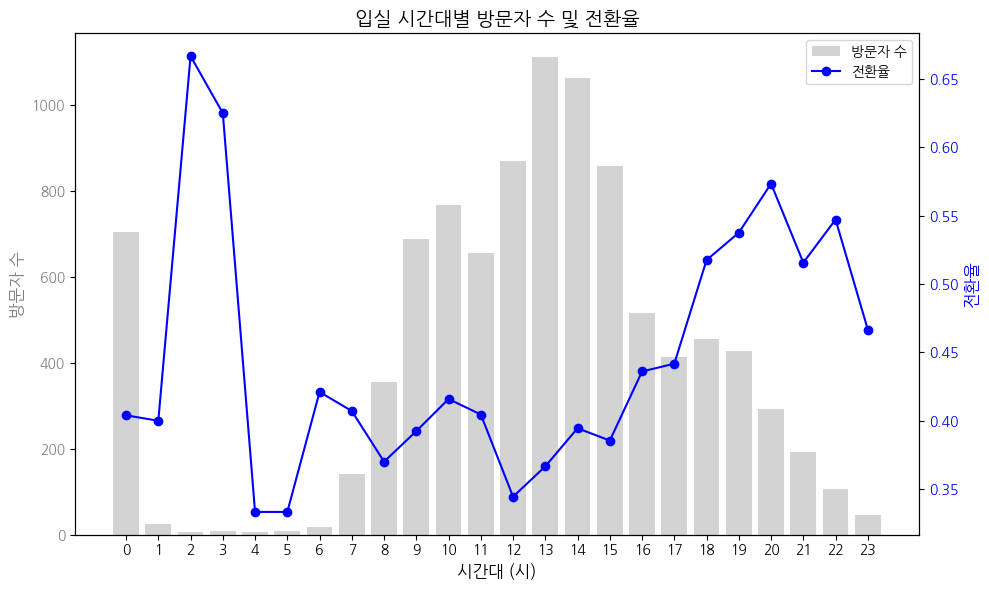

In [ ]:
# Figure 및 축 생성
fig, ax1 = plt.subplots(figsize=(10, 6))

# 막대 그래프: 방문자 수
ax1.bar(hourly_summary['enter_hour'], hourly_summary['visitors'], color='lightgray', label='방문자 수')
ax1.set_xlabel('시간대 (시)', fontsize=12)
ax1.set_ylabel('방문자 수', fontsize=12, color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# 선 그래프: 전환율
ax2 = ax1.twinx()
ax2.plot(hourly_summary['enter_hour'], hourly_summary['conversion_rate'], color='blue', marker='o', label='전환율')
ax2.set_ylabel('전환율', fontsize=12, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# 제목 및 범례
plt.title('입실 시간대별 방문자 수 및 전환율', fontsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.xticks(range(0, 24))  # 시간대 0~23시
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### 방문자 수 - 전환율 그래프 (연도별)

In [ ]:
# 1. 시간 정보 전처리
clean_visit['year'] = clean_visit['first_enter_time'].dt.year

# 2. 유저-시간대-연도 추출
visit_hourly = clean_visit[['user_uuid', 'enter_hour', 'year']].drop_duplicates()

# 3. 결제 여부 정리
payment_status = payment_df[['user_uuid', 'is_payment']].drop_duplicates()

# 4. 병합
df_year = pd.merge(visit_hourly, payment_status, on='user_uuid', how='left')
df_year['is_payment'] = df_year['is_payment'].fillna(0).astype(int)

# 5. 전환율 계산
hourly_summary_by_year = df_year.groupby(['year', 'enter_hour']).agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()

hourly_summary_by_year['conversion_rate'] = (
    hourly_summary_by_year['payers'] / hourly_summary_by_year['visitors']
)

In [ ]:
hourly_summary_by_year

year  enter_hour  visitors  payers  conversion_rate
0   2021           0       130      56         0.430769
1   2021           1         4       1         0.250000
2   2021           3         2       2         1.000000
3   2021           6         3       1         0.333333
4   2021           7        22      13         0.590909
..   ...         ...       ...     ...              ...
71  2024          13         2       0         0.000000
72  2024          14         3       2         0.666667
73  2024          15         2       1         0.500000
74  2024          17         3       3         1.000000
75  2024          19         1       1         1.000000

[76 rows x 5 columns]

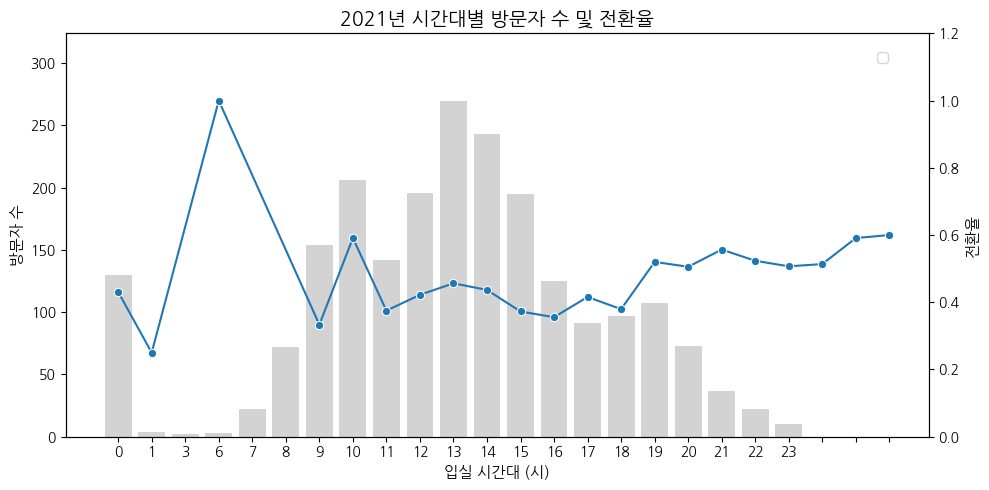

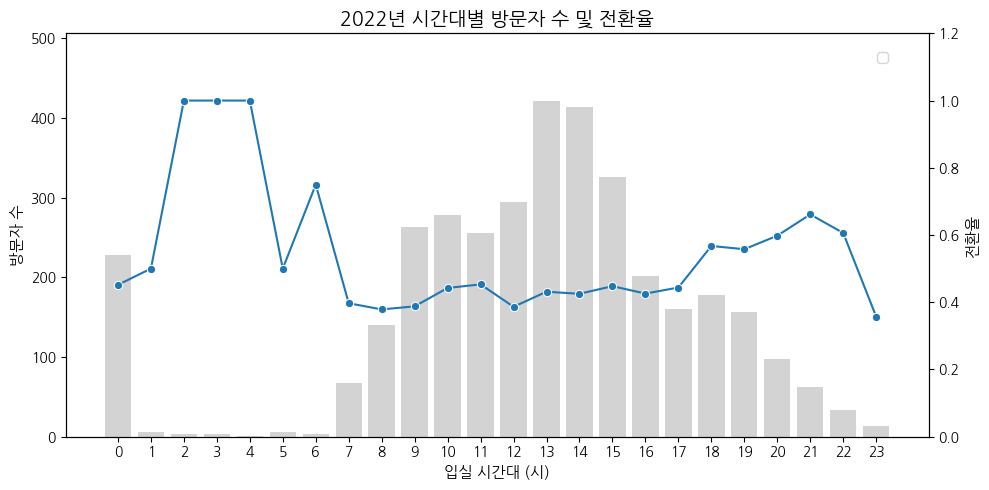

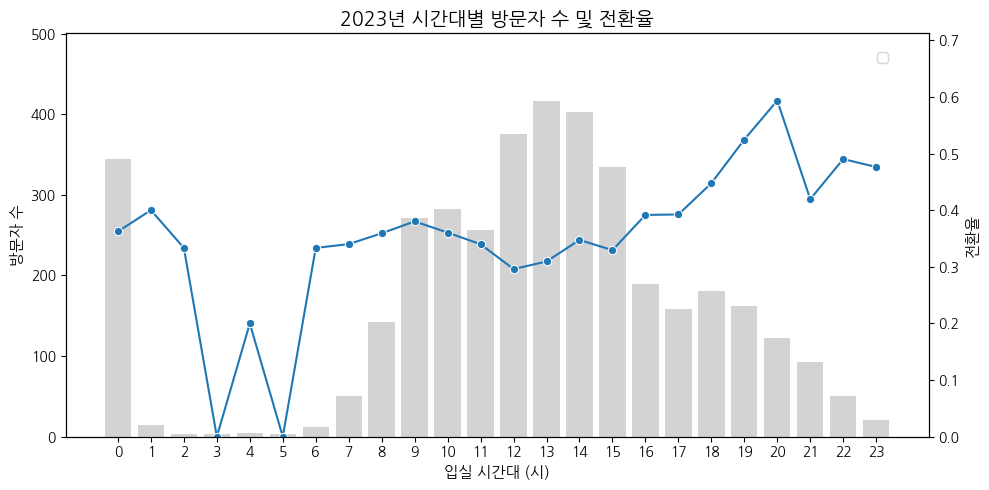

In [ ]:
# 1. 연도 리스트 추출
years = hourly_summary_by_year['year'].unique()

# 2. 연도별 그래프 반복
for y in sorted(years):
    df_year = hourly_summary_by_year[hourly_summary_by_year['year'] == y]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # ▶ 왼쪽 y축: 방문자 수 (bar)
    sns.barplot(data=df_year, x='enter_hour', y='visitors',color='lightgray', ax=ax1)
    ax1.set_ylabel('방문자 수', fontsize=11)
    ax1.set_xlabel('입실 시간대 (시)', fontsize=11)
    ax1.tick_params(axis='y')
    ax1.set_ylim(0, df_year['visitors'].max() * 1.2)

    # ▶ 오른쪽 y축: 전환율 (line)
    ax2 = ax1.twinx()
    sns.lineplot(data=df_year, x='enter_hour', y='conversion_rate', ax=ax2, marker='o')
    ax2.set_ylabel('전환율', fontsize=11)
    ax2.set_ylim(0, df_year['conversion_rate'].max() * 1.2)
    ax2.tick_params(axis='y')

    # ▶ 타이틀 및 범례
    plt.title(f'{y}년 시간대별 방문자 수 및 전환율', fontsize=14)
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

#### 방문자 수 - 전환 명수 (연도별)

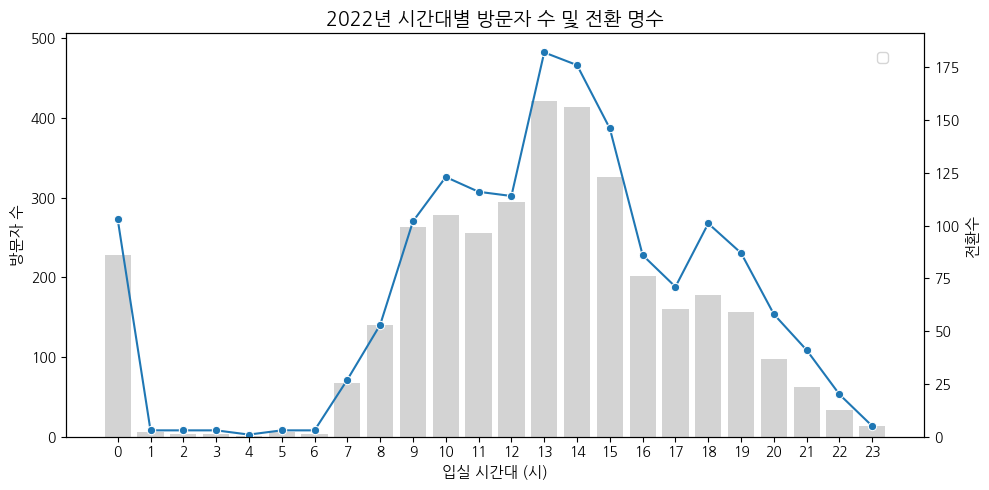

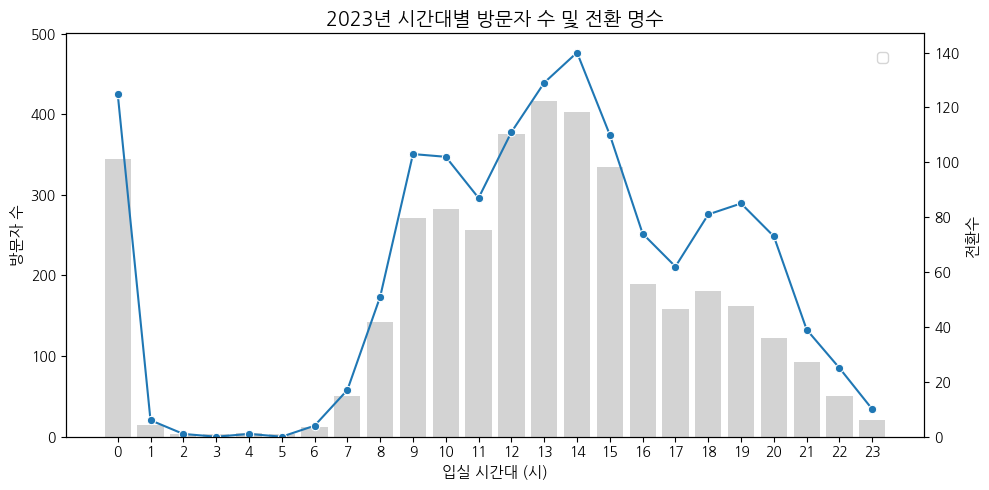

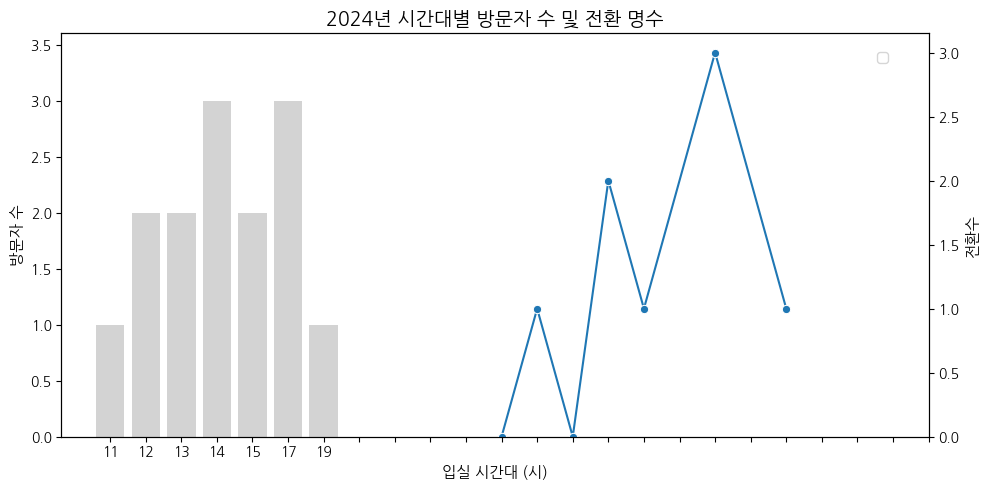

In [ ]:
# 1. 연도 리스트 추출
years = hourly_summary_by_year['year'].unique()

# 2. 연도별 그래프 반복
for y in sorted(years):
    df_year = hourly_summary_by_year[hourly_summary_by_year['year'] == y]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # ▶ 왼쪽 y축: 방문자 수 (bar)
    sns.barplot(data=df_year, x='enter_hour', y='visitors',color='lightgray', ax=ax1)
    ax1.set_ylabel('방문자 수', fontsize=11)
    ax1.set_xlabel('입실 시간대 (시)', fontsize=11)
    ax1.tick_params(axis='y')
    ax1.set_ylim(0, df_year['visitors'].max() * 1.2)

    # ▶ 오른쪽 y축: 전환수 (line)
    ax2 = ax1.twinx()
    sns.lineplot(data=df_year, x='enter_hour', y='payers', ax=ax2, marker='o')
    ax2.set_ylabel('전환수', fontsize=11)
    ax2.set_ylim(0, None)
    ax2.tick_params(axis='y')

    # ▶ 타이틀 및 범례
    plt.title(f'{y}년 시간대별 방문자 수 및 전환 명수', fontsize=14)
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

#### 시간대별 방문자 수 - 전환명수 - 전환율 그래프

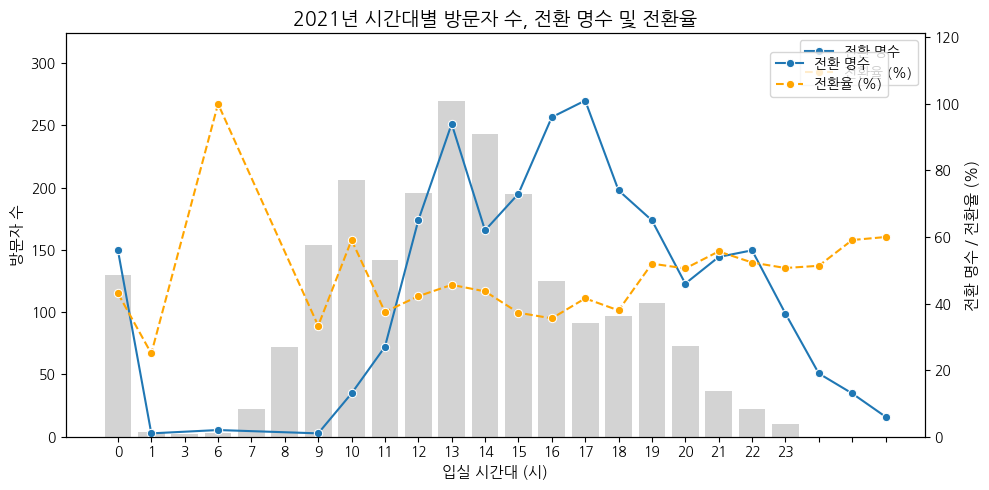

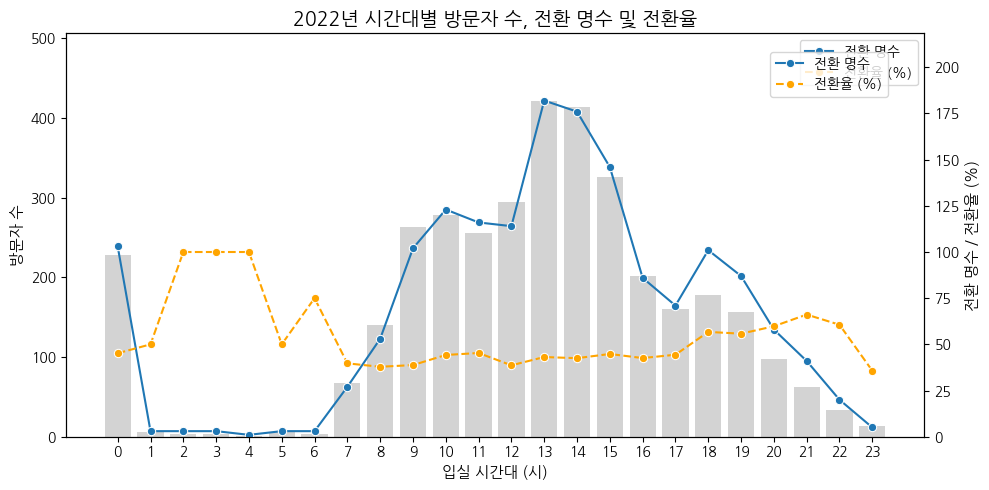

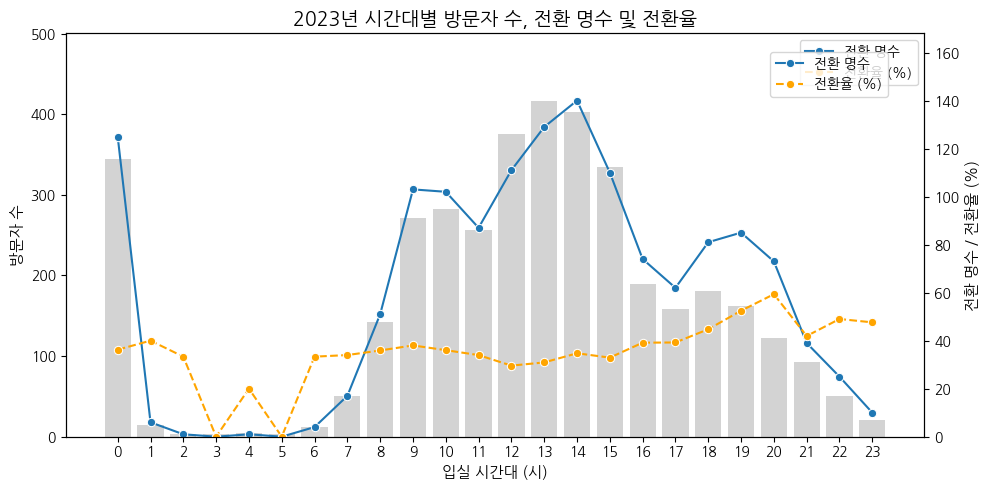

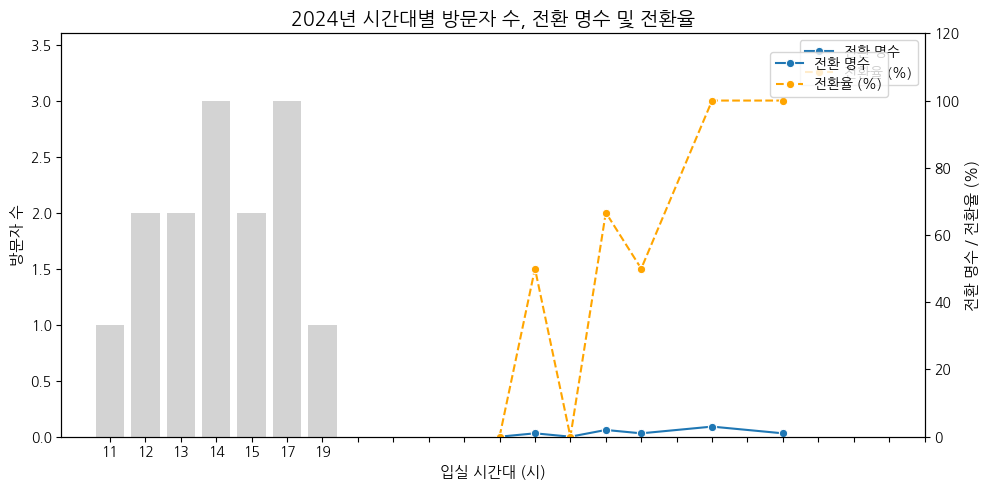

In [ ]:
# 연도 리스트 추출
years = hourly_summary_by_year['year'].unique()

for y in sorted(years):
    df_year = hourly_summary_by_year[hourly_summary_by_year['year'] == y]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # ▶ 왼쪽 y축: 방문자 수 (bar)
    sns.barplot(data=df_year, x='enter_hour', y='visitors', color='lightgray', ax=ax1)
    ax1.set_ylabel('방문자 수', fontsize=11)
    ax1.set_xlabel('입실 시간대 (시)', fontsize=11)
    ax1.tick_params(axis='y')
    ax1.set_ylim(0, df_year['visitors'].max() * 1.2)

    # ▶ 오른쪽 y축: 전환 명수, 전환율 (line)
    ax2 = ax1.twinx()

    # 전환 명수 (파란 선)
    sns.lineplot(data=df_year, x='enter_hour', y='payers', ax=ax2, marker='o', label='전환 명수')

    # 전환율 (주황 점선, % 단위)
    sns.lineplot(data=df_year, x='enter_hour', y=df_year['conversion_rate'] * 100,
                 ax=ax2, marker='o', linestyle='--', color='orange', label='전환율 (%)')

    ax2.set_ylabel('전환 명수 / 전환율 (%)', fontsize=11)
    ax2.set_ylim(0, max(
        df_year['payers'].max() * 1.2,
        (df_year['conversion_rate'] * 100).max() * 1.2
    ))
    ax2.tick_params(axis='y')

    # ▶ 타이틀 및 범례
    plt.title(f'{y}년 시간대별 방문자 수, 전환 명수 및 전환율', fontsize=14)
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()


#### 시간대별 전환율 그래프 (합본)

In [ ]:
hourly_summary_by_year['conversions'] = (hourly_summary_by_year['conversion_rate'] * hourly_summary_by_year['visitors']).round().astype(int)

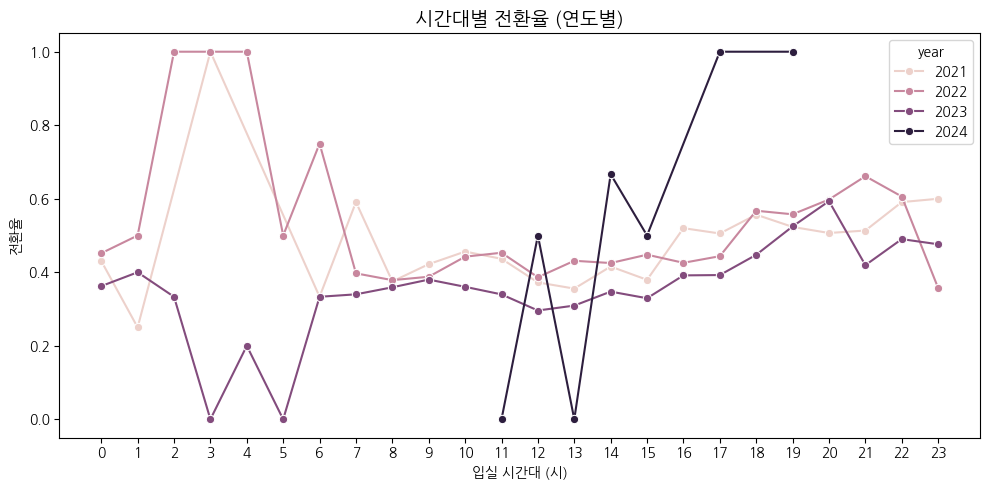

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_summary_by_year, x='enter_hour', y='conversion_rate', hue='year', marker='o')
plt.title('시간대별 전환율 (연도별)', fontsize=14)
plt.xlabel('입실 시간대 (시)')
plt.ylabel('전환율')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

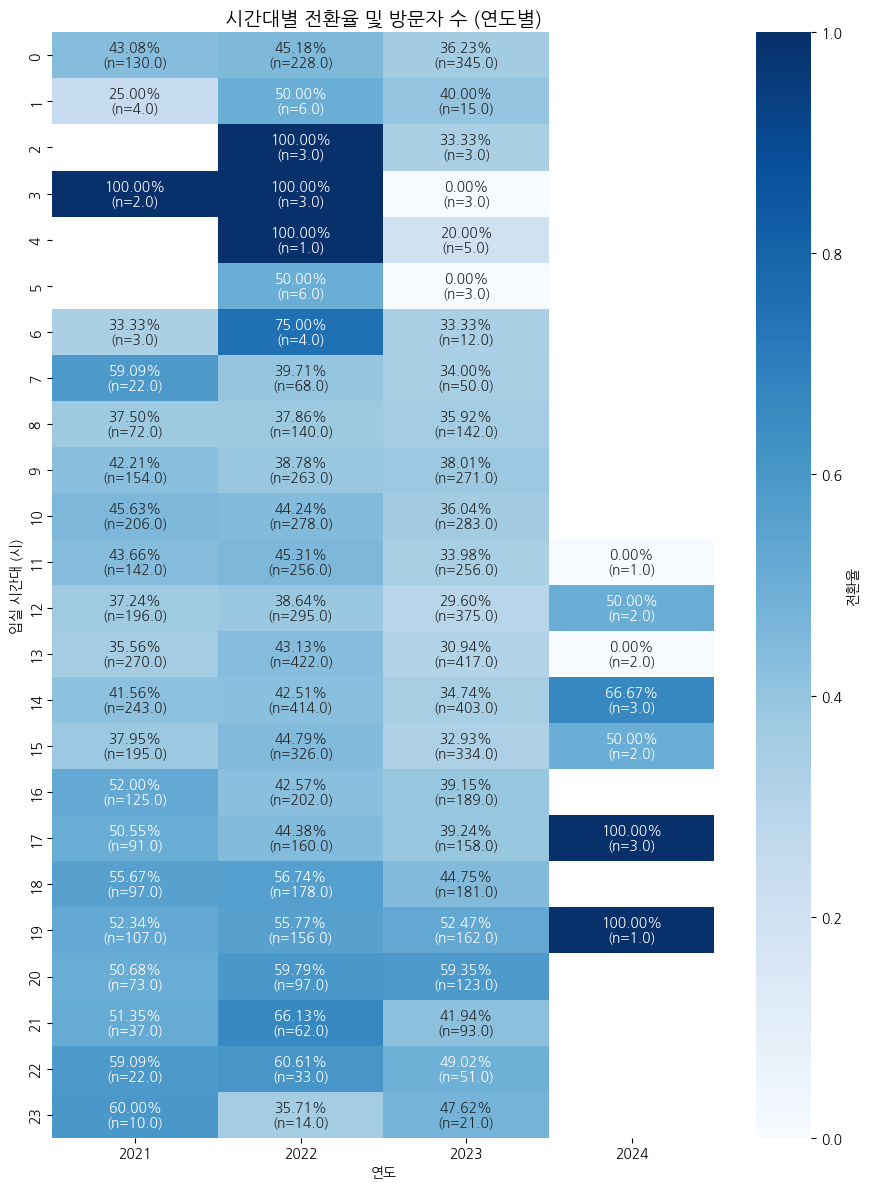

In [ ]:
# 히트맵 표기용 문자열 생성
heatmap_hour = hourly_summary_by_year.copy()
heatmap_hour['label'] = heatmap_hour.apply(
    lambda x: f"{x['conversion_rate']:.2%}\n(n={x['visitors']})", axis=1
)

pivot_hour_val = heatmap_hour.pivot(index='enter_hour', columns='year', values='conversion_rate')
pivot_hour_text = heatmap_hour.pivot(index='enter_hour', columns='year', values='label')

# 시각화
plt.figure(figsize=(9, 12))
sns.heatmap(pivot_hour_val, annot=pivot_hour_text, fmt='', cmap='Blues', cbar_kws={'label': '전환율'})
plt.title('시간대별 전환율 및 방문자 수 (연도별)', fontsize=14)
plt.xlabel('연도')
plt.ylabel('입실 시간대 (시)')
plt.tight_layout()
plt.show()

#### 시간대별 전환명수 그래프 (합본)

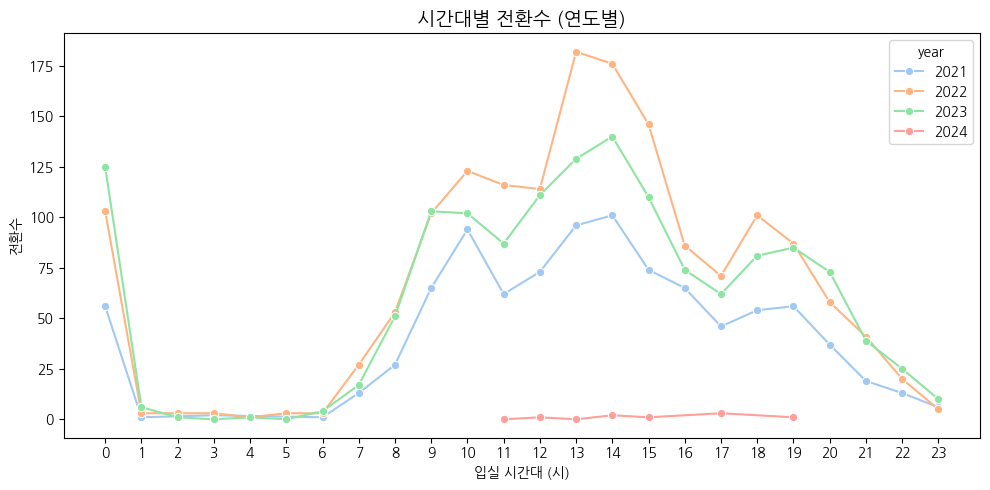

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_summary_by_year, x='enter_hour', y='payers', hue='year', marker='o', palette='pastel')
plt.title('시간대별 전환수 (연도별)', fontsize=14)
plt.xlabel('입실 시간대 (시)')
plt.ylabel('전환수')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

#### 정규화

> - Min-Max 정규화

In [ ]:
# hourly_summary['conversion_rate']를 정규화
hourly_summary['conversion_rate_norm'] = (
    (hourly_summary['conversion_rate'] - hourly_summary['conversion_rate'].min()) /
    (hourly_summary['conversion_rate'].max() - hourly_summary['conversion_rate'].min())
)

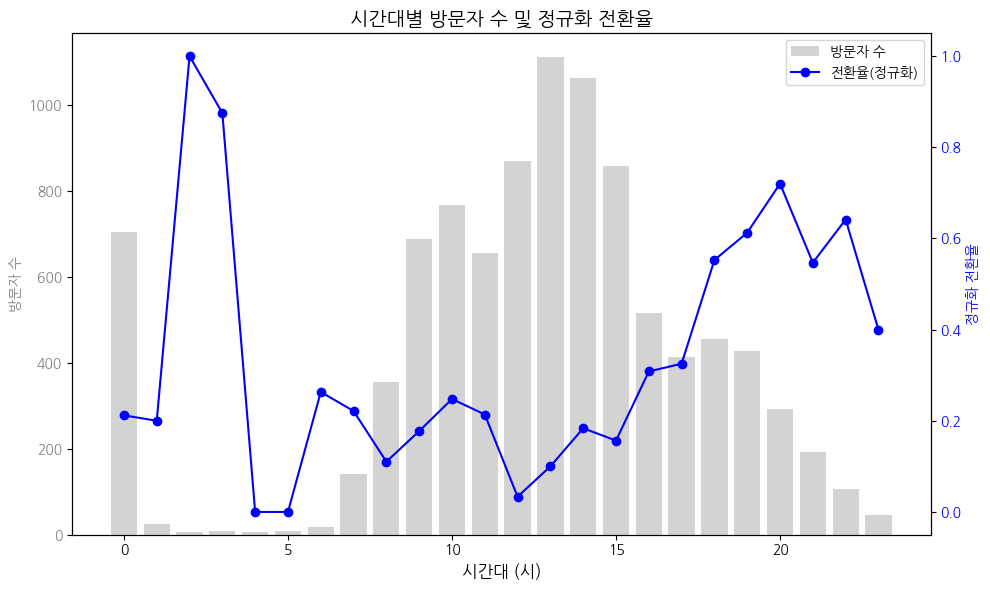

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# 막대: 방문자 수
ax1.bar(hourly_summary['enter_hour'], hourly_summary['visitors'], color='lightgray', label='방문자 수')
ax1.set_xlabel('시간대 (시)', fontsize=12)
ax1.set_ylabel('방문자 수', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# 선: 정규화된 전환율
ax2 = ax1.twinx()
ax2.plot(hourly_summary['enter_hour'], hourly_summary['conversion_rate_norm'], color='blue', marker='o', label='전환율(정규화)')
ax2.set_ylabel('정규화 전환율', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('시간대별 방문자 수 및 정규화 전환율', fontsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 평균과 표준편차 기반 정규화
# Min-Max 와 그래프 같음
hourly_summary['conversion_rate_z'] = (
    (hourly_summary['conversion_rate'] - hourly_summary['conversion_rate'].mean()) /
    hourly_summary['conversion_rate'].std()
)

#### 검정

In [ ]:
# z_test_monthly_all.py
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations

# 2. 결과 저장용 리스트
results = []

# 3. 월 조합별 Z-test 반복
for h1, h2 in combinations(hourly_summary['enter_hour'], 2):
    group1 = hourly_summary[hourly_summary['enter_hour'] == h1].iloc[0]
    group2 = hourly_summary[hourly_summary['enter_hour'] == h2].iloc[0]

    count = [int(group1['payers']), int(group2['payers'])]
    nobs = [int(group1['visitors']), int(group2['visitors'])]

    stat, pval = proportions_ztest(count=count, nobs=nobs)

    results.append({
        'hour_1': h1,
        'hour_2': h2,
        'conversion_rate_1': group1['conversion_rate'],
        'conversion_rate_2': group2['conversion_rate'],
        'z_stat': round(stat, 3),
        'p_value': round(pval, 4),
        'significant': '✅' if pval < 0.05 else ''
    })

# 4. 결과 출력
hour_df = pd.DataFrame(results)
print(hour_df.to_string(index=False))

 hour_1  hour_2  conversion_rate_1  conversion_rate_2  z_stat  p_value significant
      0       1           0.403983           0.400000   0.040   0.9682            
      0       2           0.403983           0.666667  -1.305   0.1920            
      0       3           0.403983           0.625000  -1.266   0.2057            
      0       4           0.403983           0.333333   0.351   0.7254            
      0       5           0.403983           0.333333   0.429   0.6677            
      0       6           0.403983           0.421053  -0.150   0.8811            
      0       7           0.403983           0.407143  -0.070   0.9445            
      0       8           0.403983           0.370056   1.066   0.2864            
      0       9           0.403983           0.392442   0.440   0.6602            
      0      10           0.403983           0.415906  -0.464   0.6425            
      0      11           0.403983           0.404580  -0.022   0.9821            
    

### 퇴실시간 기준

In [ ]:
# 1. 시간 정보 전처리
clean_visit['leave_hour'] = clean_visit['last_leave_time'].dt.hour

# 2. 유저-시간대만 추출
visit_leave_hourly = clean_visit[['user_uuid', 'leave_hour']].drop_duplicates()

# 4. 병합
df_leave = pd.merge(visit_leave_hourly, payment_status, on='user_uuid', how='left')
df_leave['is_payment'] = df_leave['is_payment'].fillna(0).astype(int)

# 5. 전환율 계산
leave_hourly_summary = df_leave.groupby('leave_hour').agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()

leave_hourly_summary['conversion_rate'] = leave_hourly_summary['payers'] / leave_hourly_summary['visitors']

In [ ]:
leave_hourly_summary

leave_hour  visitors  payers  conversion_rate
0            0       113      53         0.469027
1            1        66      27         0.409091
2            2        45      23         0.511111
3            3        26      11         0.423077
4            4        27      11         0.407407
5            5        13       6         0.461538
6            6        18       6         0.333333
7            7        19       5         0.263158
8            8        40      20         0.500000
9            9        44      15         0.340909
10          10        86      40         0.465116
11          11       158      60         0.379747
12          12       234     109         0.465812
13          13       236     104         0.440678
14          14       247     112         0.453441
15          15       456     195         0.427632
16          16       722     281         0.389197
17          17      1114     433         0.388689
18          18      1220     500         0.409836
19          19       954     382         0.400419
20          20       802     330         0.411471
21          21       885     395         0.446328
22          22       864     339         0.392361
23          23      1164     489         0.420103

#### 퇴실시간대별 방문자수-전환율 그래프

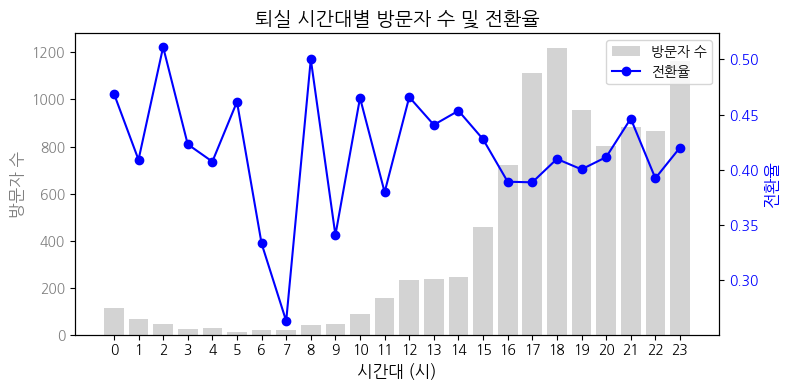

In [ ]:
# Figure 및 축 생성
fig, ax1 = plt.subplots(figsize=(8, 4))

# 막대 그래프: 방문자 수
ax1.bar(leave_hourly_summary['leave_hour'], leave_hourly_summary['visitors'], color='lightgray', label='방문자 수')
ax1.set_xlabel('시간대 (시)', fontsize=12)
ax1.set_ylabel('방문자 수', fontsize=12, color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# 선 그래프: 전환율
ax2 = ax1.twinx()
ax2.plot(leave_hourly_summary['leave_hour'], leave_hourly_summary['conversion_rate'], color='blue', marker='o', label='전환율')
ax2.set_ylabel('전환율', fontsize=12, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# 제목 및 범례
plt.title('퇴실 시간대별 방문자 수 및 전환율', fontsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.xticks(range(0, 24))  # 시간대 0~23시
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### 정규화

In [ ]:
# leave_hourly_summary['conversion_rate']를 정규화
leave_hourly_summary['conversion_rate_norm'] = (
    (leave_hourly_summary['conversion_rate'] - leave_hourly_summary['conversion_rate'].min()) /
    (leave_hourly_summary['conversion_rate'].max() - leave_hourly_summary['conversion_rate'].min())
)

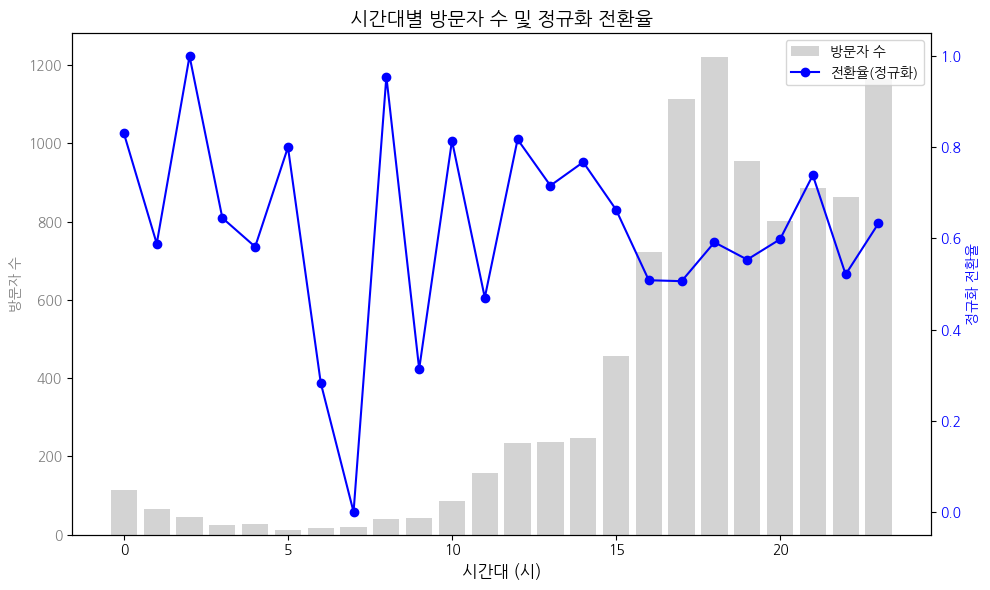

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# 막대: 방문자 수
ax1.bar(leave_hourly_summary['leave_hour'], leave_hourly_summary['visitors'], color='lightgray', label='방문자 수')
ax1.set_xlabel('시간대 (시)', fontsize=12)
ax1.set_ylabel('방문자 수', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# 선: 정규화된 전환율
ax2 = ax1.twinx()
ax2.plot(leave_hourly_summary['leave_hour'], leave_hourly_summary['conversion_rate_norm'], color='blue', marker='o', label='전환율(정규화)')
ax2.set_ylabel('정규화 전환율', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('시간대별 방문자 수 및 정규화 전환율', fontsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 월별 방문자 수 및 전환율

> - 입실시간 기준

In [ ]:
# 1. 날짜형 변환 및 월/시즌 파생
clean_visit['month'] = clean_visit['first_enter_time'].dt.month

# 시즌 매핑 함수 정의
def map_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

clean_visit['season'] = clean_visit['month'].apply(map_season)

# 2. 방문 유저 기준 파생
visit_summary = clean_visit[['user_uuid', 'month', 'season']].drop_duplicates()

# 3. 결제 여부 병합
df = pd.merge(visit_summary, payment_status, on='user_uuid', how='left')
df['is_payment'] = df['is_payment'].fillna(0).astype(int)

# 4. 월별 전환율 계산
monthly_summary = df.groupby('month').agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()
monthly_summary['conversion_rate'] = monthly_summary['payers'] / monthly_summary['visitors']

# 5. 시즌별 전환율 계산
season_summary = df.groupby('season').agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()
season_summary['conversion_rate'] = season_summary['payers'] / season_summary['visitors']

In [ ]:
monthly_summary

month  visitors  payers  conversion_rate
0       1       467     190         0.406852
1       2       430     163         0.379070
2       3       426     161         0.377934
3       4       342     131         0.383041
4       5       316     150         0.474684
5       6       413     176         0.426150
6       7       584     239         0.409247
7       8       652     253         0.388037
8       9       807     307         0.380421
9      10       589     240         0.407470
10     11       598     227         0.379599
11     12       786     267         0.339695

####방문자수-전환율 그래프

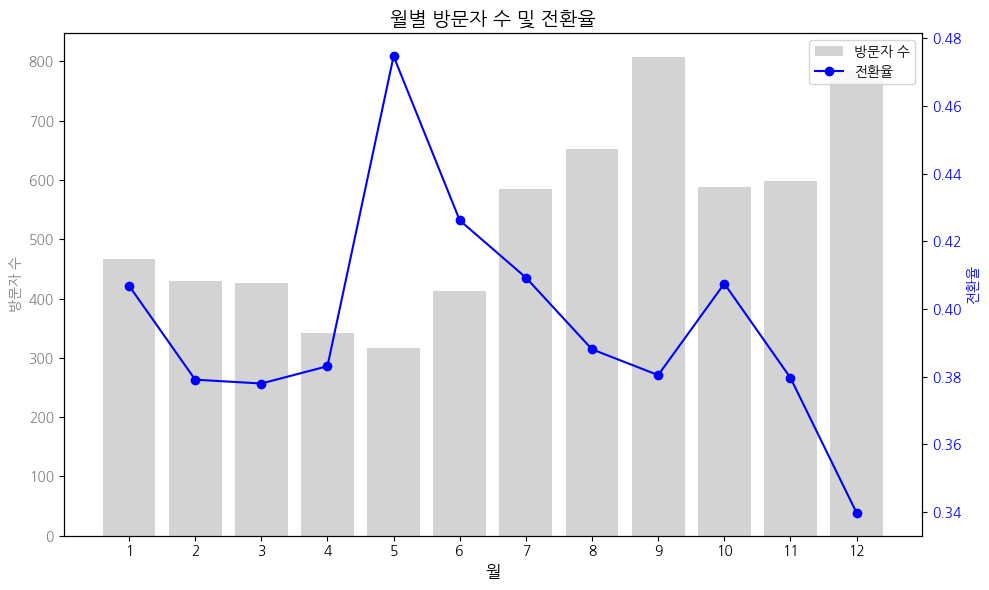

In [ ]:
# 월별 전환율 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 막대: 방문자 수
ax1.bar(monthly_summary['month'], monthly_summary['visitors'], color='lightgray', label='방문자 수')
ax1.set_xlabel('월', fontsize=12)
ax1.set_ylabel('방문자 수', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# 선: 전환율
ax2 = ax1.twinx()
ax2.plot(monthly_summary['month'], monthly_summary['conversion_rate'], color='blue', marker='o', label='전환율')
ax2.set_ylabel('전환율', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('월별 방문자 수 및 전환율', fontsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.xticks(range(1, 13))
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### 방문자 수-전환율 (연도별)

In [ ]:
# 1. 월, 연도 파생
clean_visit['year'] = clean_visit['first_enter_time'].dt.year

# 2. 유저-월-연도 추출
visit_monthly = clean_visit[['user_uuid', 'month', 'year']].drop_duplicates()

# 3. 결제 여부 병합
df_month = pd.merge(visit_monthly, payment_status, on='user_uuid', how='left')
df_month['is_payment'] = df_month['is_payment'].fillna(0).astype(int)

# 4. 전환율 계산
monthly_summary_by_year = df_month.groupby(['year', 'month']).agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()

monthly_summary_by_year['conversion_rate'] = (
    monthly_summary_by_year['payers'] / monthly_summary_by_year['visitors']
)

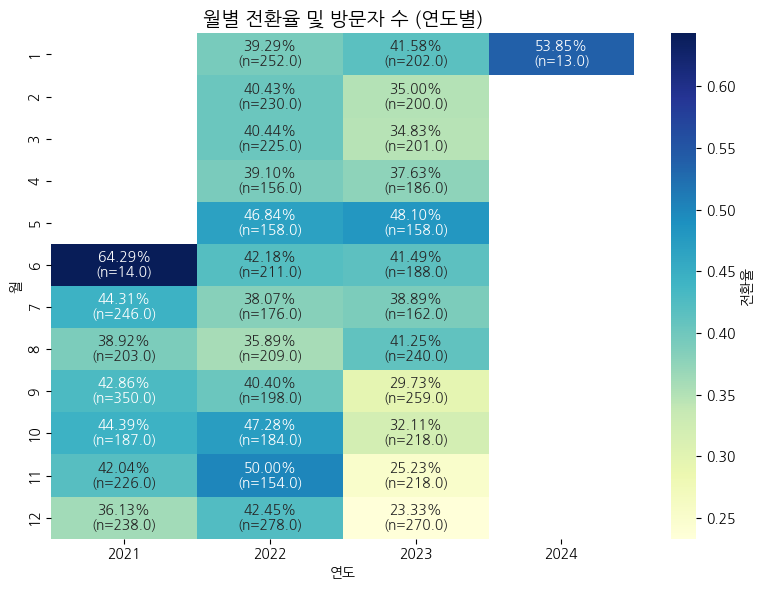

In [ ]:
# 표기 문자열 생성
heatmap_month = monthly_summary_by_year.copy()
heatmap_month['label'] = heatmap_month.apply(
    lambda x: f"{x['conversion_rate']:.2%}\n(n={x['visitors']})", axis=1
)

pivot_month_val = heatmap_month.pivot(index='month', columns='year', values='conversion_rate')
pivot_month_text = heatmap_month.pivot(index='month', columns='year', values='label')

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_month_val, annot=pivot_month_text, fmt='', cmap='YlGnBu', cbar_kws={'label': '전환율'})
plt.title('월별 전환율 및 방문자 수 (연도별)', fontsize=14)
plt.xlabel('연도')
plt.ylabel('월')
plt.tight_layout()
plt.show()

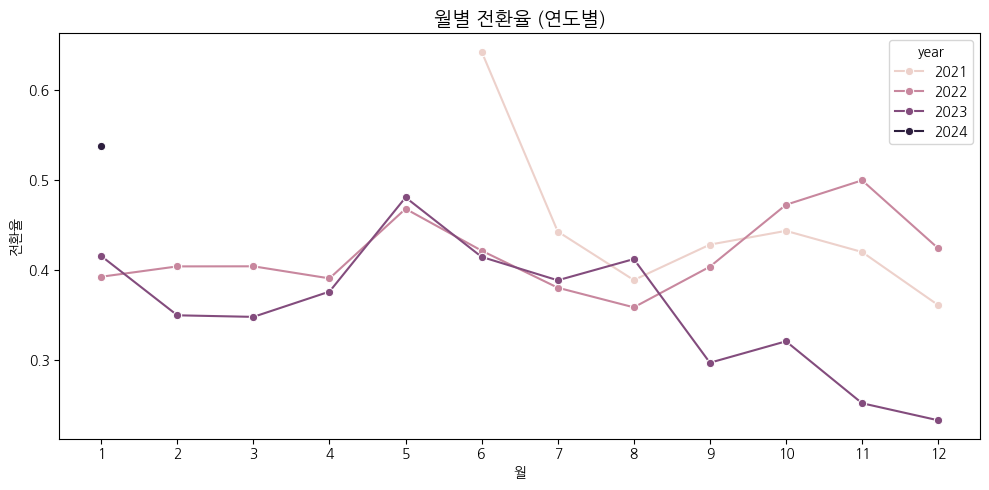

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_summary_by_year, x='month', y='conversion_rate', hue='year', marker='o')
plt.title('월별 전환율 (연도별)', fontsize=14)
plt.xlabel('월')
plt.ylabel('전환율')
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

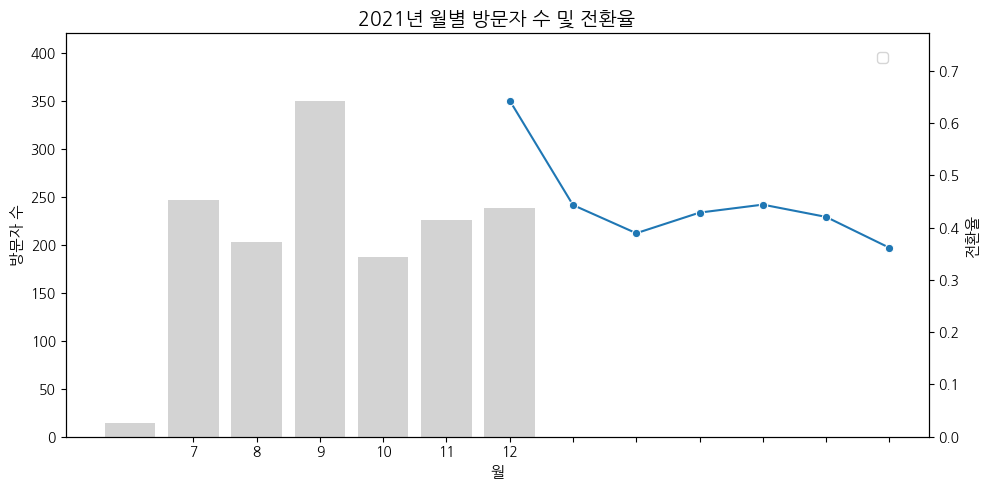

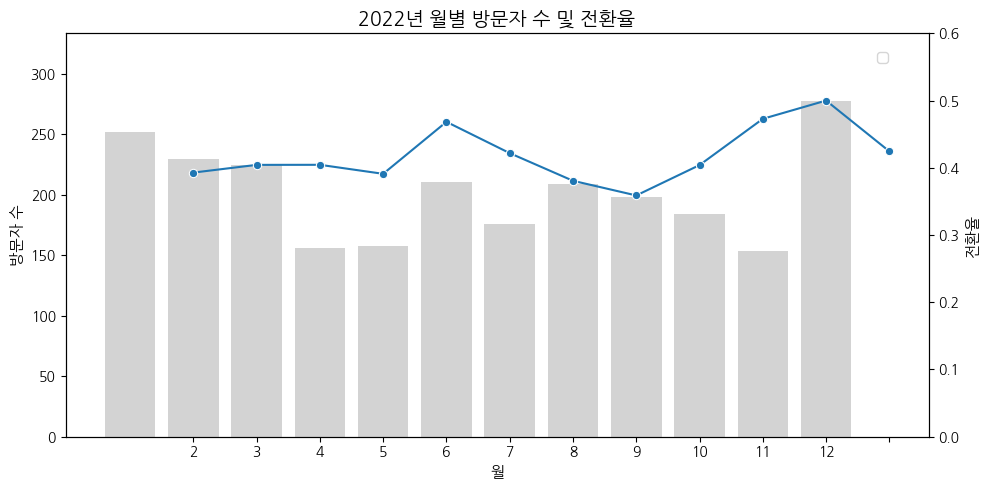

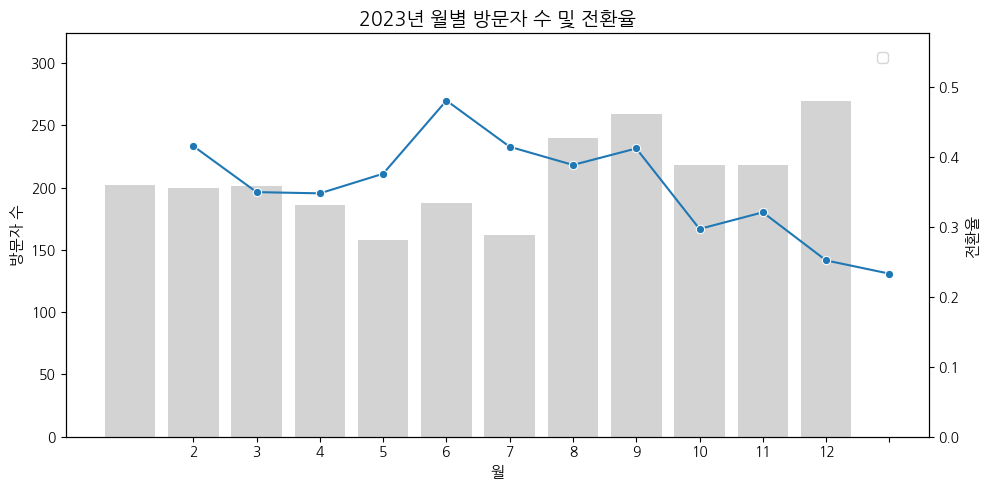

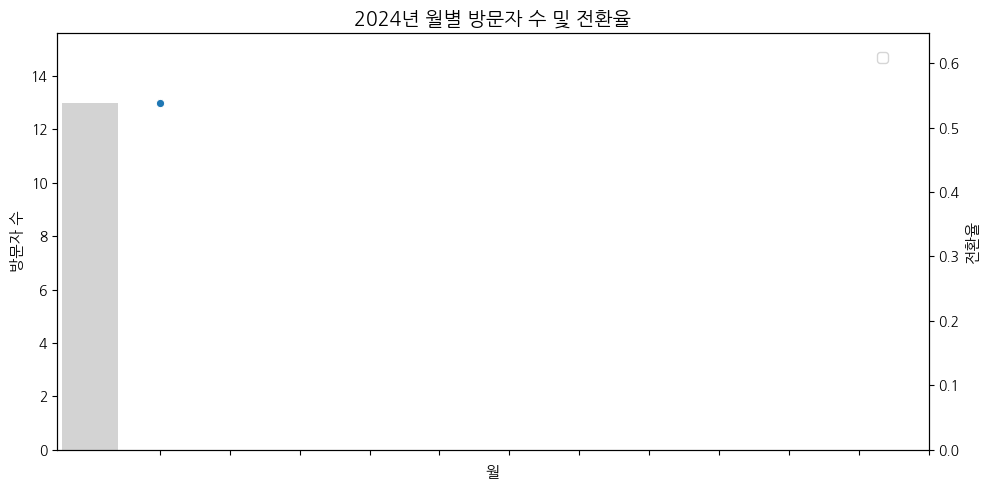

In [ ]:
# 1. 연도 리스트 추출
years = monthly_summary_by_year['year'].unique()

# 2. 연도별 그래프 반복
for y in sorted(years):
    df_year = monthly_summary_by_year[monthly_summary_by_year['year'] == y]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # ▶ 왼쪽 y축: 방문자 수 (bar)
    sns.barplot(data=df_year, x='month', y='visitors',color='lightgray', ax=ax1)
    ax1.set_ylabel('방문자 수', fontsize=11)
    ax1.set_xlabel('월', fontsize=11)
    ax1.tick_params(axis='y')
    ax1.set_ylim(0, df_year['visitors'].max() * 1.2)

    # ▶ 오른쪽 y축: 전환율 (line)
    ax2 = ax1.twinx()
    sns.lineplot(data=df_year, x='month', y='conversion_rate', ax=ax2, marker='o')
    ax2.set_ylabel('전환율', fontsize=11)
    ax2.set_ylim(0, df_year['conversion_rate'].max() * 1.2)
    ax2.tick_params(axis='y')

    # ▶ 타이틀 및 범례
    plt.title(f'{y}년 월별 방문자 수 및 전환율', fontsize=14)
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.xticks(range(1, 13))
    plt.tight_layout()
    plt.show()

#### 정규화 및 시각화

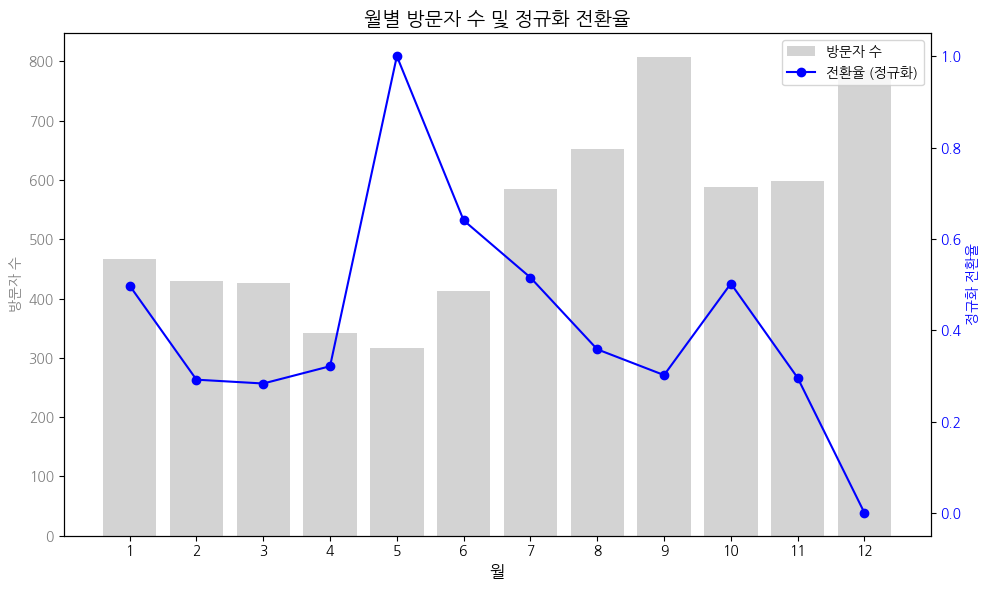

In [ ]:
# 1. 전환율 정규화 (Min-Max Scaling)
monthly_summary['conversion_rate_norm'] = (
    (monthly_summary['conversion_rate'] - monthly_summary['conversion_rate'].min()) /
    (monthly_summary['conversion_rate'].max() - monthly_summary['conversion_rate'].min())
)

# 2. 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 막대: 방문자 수
ax1.bar(monthly_summary['month'], monthly_summary['visitors'], color='lightgray', label='방문자 수')
ax1.set_xlabel('월', fontsize=12)
ax1.set_ylabel('방문자 수', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# 선: 정규화된 전환율
ax2 = ax1.twinx()
ax2.plot(monthly_summary['month'], monthly_summary['conversion_rate_norm'], color='blue', marker='o', label='전환율 (정규화)')
ax2.set_ylabel('정규화 전환율', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('월별 방문자 수 및 정규화 전환율', fontsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.xticks(range(1, 13))
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### 전환율 검정

- 정규화해도 변화가 없어보여, 전환율에 대한 검정 시행

In [ ]:
# z_test_monthly_all.py
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations

# 2. 결과 저장용 리스트
results = []

# 3. 월 조합별 Z-test 반복
for m1, m2 in combinations(monthly_summary['month'], 2):
    group1 = monthly_summary[monthly_summary['month'] == m1].iloc[0]
    group2 = monthly_summary[monthly_summary['month'] == m2].iloc[0]

    count = [int(group1['payers']), int(group2['payers'])]
    nobs = [int(group1['visitors']), int(group2['visitors'])]

    stat, pval = proportions_ztest(count=count, nobs=nobs)

    results.append({
        'month_1': m1,
        'month_2': m2,
        'conversion_rate_1': group1['conversion_rate'],
        'conversion_rate_2': group2['conversion_rate'],
        'z_stat': round(stat, 3),
        'p_value': round(pval, 4),
        'significant': '✅' if pval < 0.05 else ''
    })

# 4. 결과 출력
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 month_1  month_2  conversion_rate_1  conversion_rate_2  z_stat  p_value significant
       1        2           0.406852           0.379070   0.851   0.3948            
       1        3           0.406852           0.377934   0.884   0.3769            
       1        4           0.406852           0.383041   0.684   0.4941            
       1        5           0.406852           0.474684  -1.879   0.0603            
       1        6           0.406852           0.426150  -0.580   0.5622            
       1        7           0.406852           0.409247  -0.078   0.9375            
       1        8           0.406852           0.388037   0.635   0.5257            
       1        9           0.406852           0.380421   0.932   0.3514            
       1       10           0.406852           0.407470  -0.020   0.9838            
       1       11           0.406852           0.379599   0.904   0.3659            
       1       12           0.406852           0.339695   2.388  

### 계절별

In [ ]:
season_summary

season  visitors  payers  conversion_rate
0     가을      1994     774         0.388164
1     겨울      1683     620         0.368390
2      봄      1084     442         0.407749
3     여름      1649     668         0.405094

#### 방문자 수 - 전환율 그래프

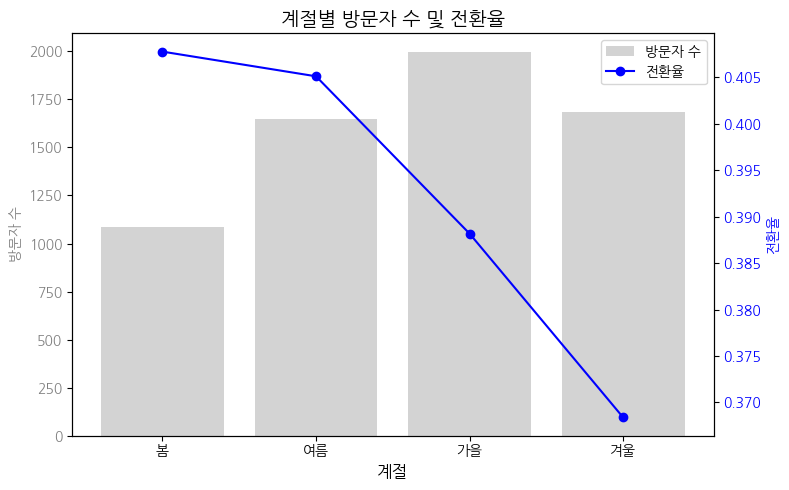

In [ ]:
# 시즌 순서 정렬 (봄 → 여름 → 가을 → 겨울)
season_order = ['봄', '여름', '가을', '겨울']
season_summary['season'] = pd.Categorical(season_summary['season'], categories=season_order, ordered=True)
season_summary = season_summary.sort_values('season')

# 시각화
fig, ax1 = plt.subplots(figsize=(8, 5))

# 막대: 방문자 수
ax1.bar(season_summary['season'], season_summary['visitors'], color='lightgray', label='방문자 수')
ax1.set_xlabel('계절', fontsize=12)
ax1.set_ylabel('방문자 수', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# 선: 전환율
ax2 = ax1.twinx()
ax2.plot(season_summary['season'], season_summary['conversion_rate'], color='blue', marker='o', label='전환율')
ax2.set_ylabel('전환율', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('계절별 방문자 수 및 전환율', fontsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### 방문자수-전환율 (연도별) 그래프 모음

In [ ]:
# 연도-계절별 전환율 계산
# 2. 방문 유저 기준 파생
visit_season = clean_visit[['user_uuid', 'year', 'season']].drop_duplicates()

# 4. 결제 여부 병합
df_season = pd.merge(visit_season, payment_status, on='user_uuid', how='left')
df_season['is_payment'] = df_season['is_payment'].fillna(0).astype(int)

# 5. 그룹별 집계
season_summary_by_year = df_season.groupby(['year', 'season']).agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()

season_summary_by_year['conversion_rate'] = (
    season_summary_by_year['payers'] / season_summary_by_year['visitors']
)

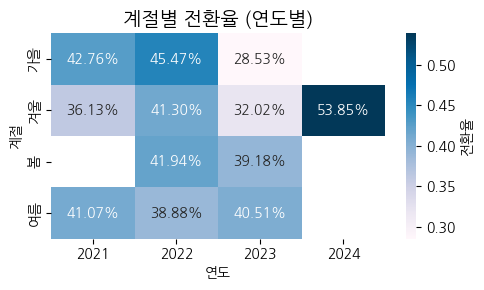

In [ ]:
# 피벗: 행=계절, 열=연도
pivot_season = season_summary_by_year.pivot(index='season', columns='year', values='conversion_rate')

# 시각화
plt.figure(figsize=(5, 3))
sns.heatmap(pivot_season, annot=True, fmt=".2%", cmap="PuBu", cbar_kws={'label': '전환율'})
plt.title("계절별 전환율 (연도별)", fontsize=14)
plt.xlabel("연도")
plt.ylabel("계절")
plt.tight_layout()
plt.show()

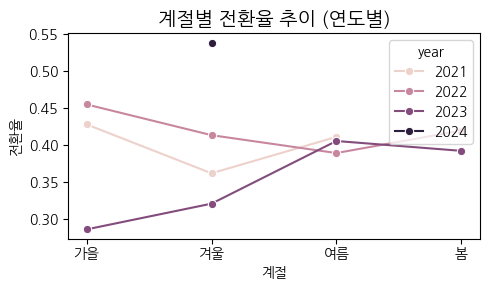

In [ ]:
plt.figure(figsize=(5, 3))
sns.lineplot(data=season_summary_by_year, x='season', y='conversion_rate', hue='year', marker='o')
plt.title("계절별 전환율 추이 (연도별)", fontsize=14)
plt.xlabel("계절")
plt.ylabel("전환율")
plt.tight_layout()
plt.show()

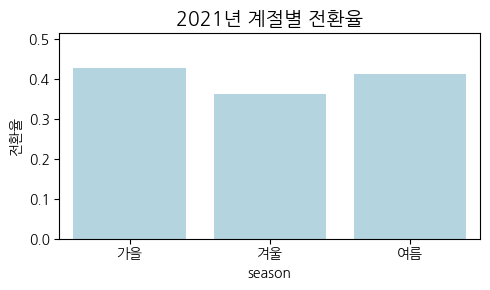

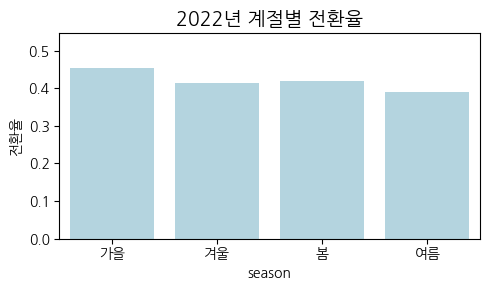

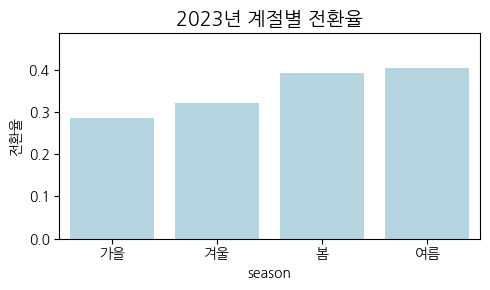

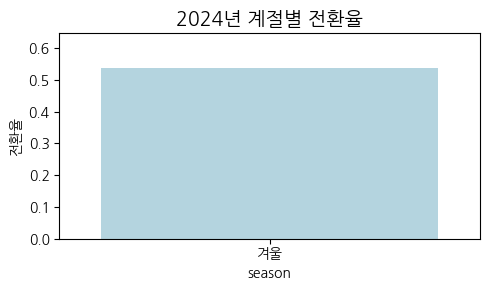

In [ ]:
for y in sorted(season_summary_by_year['year'].unique()):
    df_y = season_summary_by_year[season_summary_by_year['year'] == y]

    plt.figure(figsize=(5, 3))
    sns.barplot(data=df_y, x='season', y='conversion_rate', color='lightblue')

    plt.title(f'{y}년 계절별 전환율', fontsize=14)
    plt.ylim(0, df_y['conversion_rate'].max() * 1.2)
    plt.ylabel('전환율')
    plt.tight_layout()
    plt.show()

#### 정규화 및 시각화

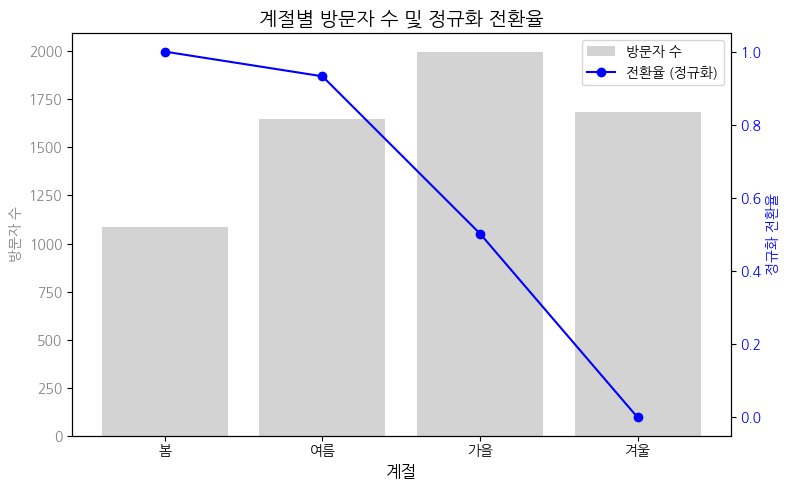

In [ ]:
# 1. 시즌별 전환율 정규화
season_summary['conversion_rate_norm'] = (
    (season_summary['conversion_rate'] - season_summary['conversion_rate'].min()) /
    (season_summary['conversion_rate'].max() - season_summary['conversion_rate'].min())
)

# 시즌 순서 정렬
season_order = ['봄', '여름', '가을', '겨울']
season_summary['season'] = pd.Categorical(season_summary['season'], categories=season_order, ordered=True)
season_summary = season_summary.sort_values('season')

# 2. 시각화
fig, ax1 = plt.subplots(figsize=(8, 5))

# 막대: 방문자 수
ax1.bar(season_summary['season'], season_summary['visitors'], color='lightgray', label='방문자 수')
ax1.set_xlabel('계절', fontsize=12)
ax1.set_ylabel('방문자 수', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# 선: 정규화된 전환율
ax2 = ax1.twinx()
ax2.plot(season_summary['season'], season_summary['conversion_rate_norm'], color='blue', marker='o', label='전환율 (정규화)')
ax2.set_ylabel('정규화 전환율', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('계절별 방문자 수 및 정규화 전환율', fontsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### 검정

In [ ]:
# z-test 자동 비교 함수
def run_ztest_for_proportions(df, group_col, label='그룹'):
    results = []
    for g1, g2 in combinations(df[group_col], 2):
        row1 = df[df[group_col] == g1].iloc[0]
        row2 = df[df[group_col] == g2].iloc[0]

        count = [int(row1['payers']), int(row2['payers'])]
        nobs = [int(row1['visitors']), int(row2['visitors'])]

        stat, pval = proportions_ztest(count=count, nobs=nobs)
        results.append({
            f'{label}1': g1,
            f'{label}2': g2,
            'conversion_rate_1': round(row1['conversion_rate'], 3),
            'conversion_rate_2': round(row2['conversion_rate'], 3),
            'z_stat': round(stat, 3),
            'p_value': round(pval, 4),
            'significant': '✅' if pval < 0.05 else ''
        })

    return pd.DataFrame(results)

In [ ]:
# 실행
df_season_ztest = run_ztest_for_proportions(season_summary, group_col='season', label='시즌')
print(df_season_ztest.to_string(index=False))

시즌1 시즌2  conversion_rate_1  conversion_rate_2  z_stat  p_value significant
  봄  여름              0.408              0.405   0.138   0.8900            
  봄  가을              0.408              0.388   1.062   0.2884            
  봄  겨울              0.408              0.368   2.078   0.0377           ✅
 여름  가을              0.405              0.388   1.040   0.2983            
 여름  겨울              0.405              0.368   2.175   0.0296           ✅
 가을  겨울              0.388              0.368   1.231   0.2182            


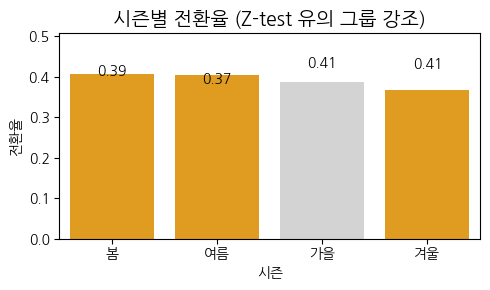

In [ ]:
# 2. 유의한 그룹 조합 추출 (p < 0.05)
significant_pairs = df_season_ztest[df_season_ztest['p_value'] < 0.05][['시즌1', '시즌2']].values.tolist()
highlight_groups = set([g for pair in significant_pairs for g in pair])  # 유의 그룹만 강조

# 3. 시각화
plt.figure(figsize=(5, 3))
colors = ['orange' if season in highlight_groups else 'lightgray' for season in season_summary['season']]

sns.barplot(x='season', y='conversion_rate', data=season_summary, palette=colors)

for i, row in season_summary.iterrows():
    plt.text(i, row['conversion_rate'] + 0.01, f"{row['conversion_rate']:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.title('시즌별 전환율 (Z-test 유의 그룹 강조)', fontsize=14)
plt.ylim(0, max(season_summary['conversion_rate']) + 0.1)
plt.ylabel('전환율')
plt.xlabel('시즌')
plt.tight_layout()
plt.show()

### 체류 시간별 전환율

> - 입실시간 기준

In [ ]:
# 체류 시간 계산 (시간 단위)
clean_visit['first_enter_time'] = pd.to_datetime(clean_visit['first_enter_time'].astype(str).str.split('.').str[0])
clean_visit['last_leave_time'] = pd.to_datetime(clean_visit['last_leave_time'].astype(str).str.split('.').str[0])
clean_visit['duration_hours'] = (clean_visit['last_leave_time'] - clean_visit['first_enter_time']).dt.total_seconds() / 3600

# 체류 시간 구간 나누기 (ex: 1시간 단위 또는 quantile 기준)
clean_visit['duration_group'] = pd.cut(clean_visit['duration_hours'],
                                 bins=[0, 1, 2, 4, 6, 8, 12, 24],
                                 labels=['~1h', '1~2h', '2~4h', '4~6h', '6~8h', '8~12h', '12~24h'],
                                 right=False)

# 결제정보 병합
pay_status = payment_df[['user_uuid', 'is_payment']].drop_duplicates()
df = pd.merge(clean_visit[['user_uuid', 'duration_group']], pay_status, on='user_uuid', how='left')
df['is_payment'] = df['is_payment'].fillna(0).astype(int)

# 전환율 계산
duration_summary = df.groupby('duration_group').agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()
duration_summary['conversion_rate'] = duration_summary['payers'] / duration_summary['visitors']

In [ ]:
duration_summary

duration_group  visitors  payers  conversion_rate
0            ~1h      1158     582         0.502591
1           1~2h      1169     592         0.506416
2           2~4h      2412    1092         0.452736
3           4~6h      1990     761         0.382412
4           6~8h      1500     585         0.390000
5          8~12h      1767     582         0.329372
6         12~24h       926     365         0.394168

#### 체류시간-전환율 그래프

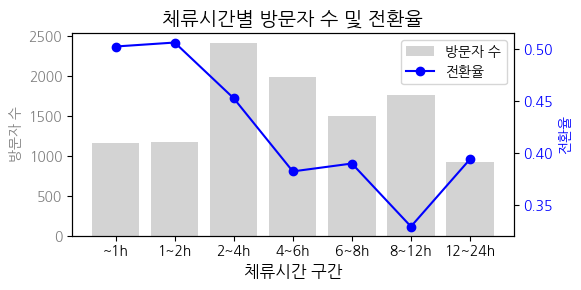

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 3))

# 막대: 방문자 수
ax1.bar(duration_summary['duration_group'], duration_summary['visitors'], color='lightgray', label='방문자 수')
ax1.set_xlabel('체류시간 구간', fontsize=12)
ax1.set_ylabel('방문자 수', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# 선: 전환율
ax2 = ax1.twinx()
ax2.plot(duration_summary['duration_group'], duration_summary['conversion_rate'], color='blue', marker='o', label='전환율')
ax2.set_ylabel('전환율', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('체류시간별 방문자 수 및 전환율', fontsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### 체류시간-전환율 (연도별)

In [ ]:
# 입실/퇴실 시간 기준 체류시간 (분)
clean_visit['duration_minutes'] = (
    (clean_visit['last_leave_time'] - clean_visit['first_enter_time']).dt.total_seconds() / 60
).fillna(0)

# 체류시간을 1시간 단위 구간으로 변환
clean_visit['duration_hour_bin'] = (clean_visit['duration_minutes'] // 60).astype(int)

# 중복 제거 후 결제 병합
visit_duration = clean_visit[['user_uuid', 'year', 'duration_hour_bin']].drop_duplicates()
visit_duration = pd.merge(visit_duration, payment_status, on='user_uuid', how='left')
visit_duration['is_payment'] = visit_duration['is_payment'].fillna(0).astype(int)

In [ ]:
duration_summary_by_year = visit_duration.groupby(['year', 'duration_hour_bin']).agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()

duration_summary_by_year['conversion_rate'] = (
    duration_summary_by_year['payers'] / duration_summary_by_year['visitors']
)

# ▶ 방문자 수 기준 필터링
duration_summary_filtered = duration_summary_by_year[duration_summary_by_year['visitors'] >= 10]

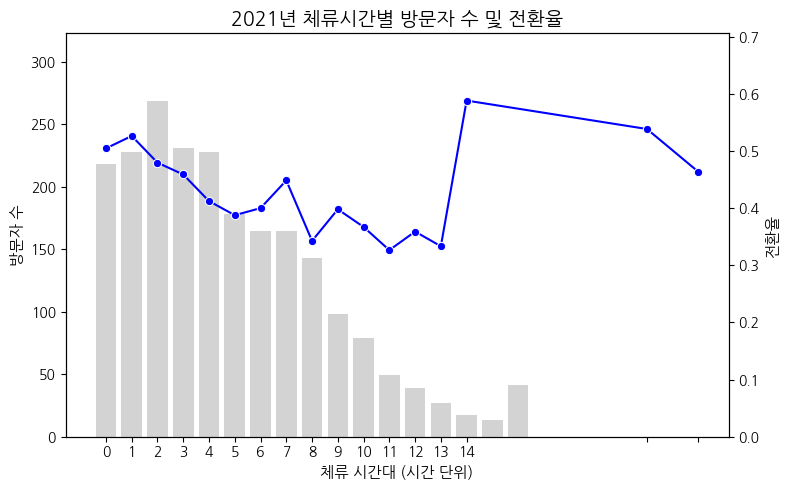

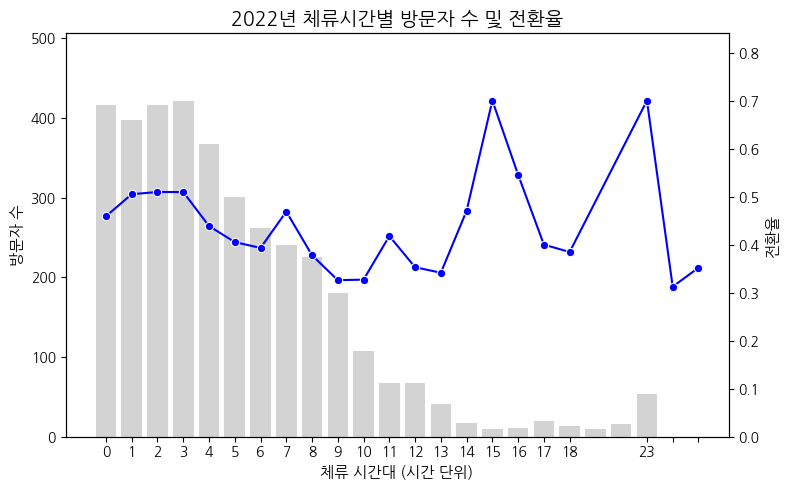

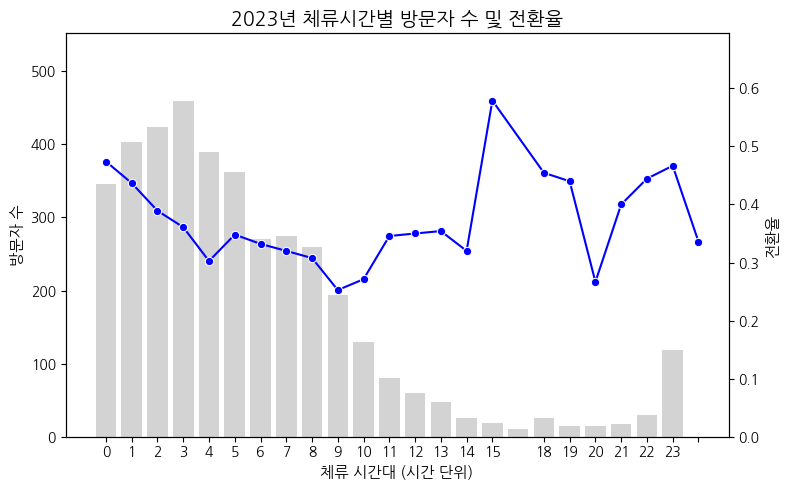

In [ ]:
for y in sorted(duration_summary_filtered['year'].unique()):
    df_y = duration_summary_filtered[duration_summary_filtered['year'] == y]

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # ▶ 왼쪽 y축: 방문자 수
    sns.barplot(data=df_y, x='duration_hour_bin', y='visitors', color='lightgray', ax=ax1)
    ax1.set_ylabel('방문자 수', fontsize=11)
    ax1.set_xlabel('체류 시간대 (시간 단위)', fontsize=11)
    ax1.tick_params(axis='y')
    ax1.set_ylim(0, df_y['visitors'].max() * 1.2)

    # ▶ 오른쪽 y축: 전환율
    ax2 = ax1.twinx()
    sns.lineplot(data=df_y, x='duration_hour_bin', y='conversion_rate', marker='o', color='blue', ax=ax2)
    ax2.set_ylabel('전환율', fontsize=11)
    ax2.set_ylim(0, df_y['conversion_rate'].max() * 1.2)

    plt.title(f"{y}년 체류시간별 방문자 수 및 전환율", fontsize=14)
    plt.xticks(df_y['duration_hour_bin'])
    plt.tight_layout()
    plt.show()

### 방문 세션 단위 전환율

- 한 명의 사용자가 공유오피스를 방문한 "한 번의 실제 출입" 기록 (입실~퇴실)을 1세션으로 간주
- 같은 user_uuid가 여러 번 방문한 경우를 고려해서 visit의 `각 row를 개별 세션으로 보고` 전환율을 계산 (**각 row가 1개의 방문세션**)

> - 입실 시간 기준

In [ ]:
# 세션 단위 분석: visit row 단위로 분석
visit_sessions = visit_df[['user_uuid', 'first_enter_time']].copy()

# session_id 생성 (선택사항)
visit_sessions['session_id'] = visit_sessions.index  # 또는 user_uuid + 날짜 조합으로 만들어도 됨

# 결제 여부 병합 (user_uuid 기준이므로 동일)
df_sessions = pd.merge(visit_sessions, pay_status, on='user_uuid', how='left')
df_sessions['is_payment'] = df_sessions['is_payment'].fillna(0).astype(int)

# 예시: 월별 방문 세션 전환율
df_sessions['month'] = df_sessions['first_enter_time'].dt.month
session_monthly = df_sessions.groupby('month').agg(
    sessions=('session_id', 'count'),
    payers=('is_payment', 'sum')
).reset_index()
session_monthly['conversion_rate'] = session_monthly['payers'] / session_monthly['sessions']

In [ ]:
session_monthly

month  sessions  payers  conversion_rate
0       1       765     337         0.440523
1       2       693     292         0.421356
2       3       737     301         0.408412
3       4       557     221         0.396768
4       5       543     256         0.471455
5       6       697     315         0.451937
6       7      1017     438         0.430678
7       8      1125     463         0.411556
8       9      1325     549         0.414340
9      10      1045     439         0.420096
10     11      1047     421         0.402101
11     12      1371     527         0.384391

#### 방문 세션수-전환율 그래프 (월별)

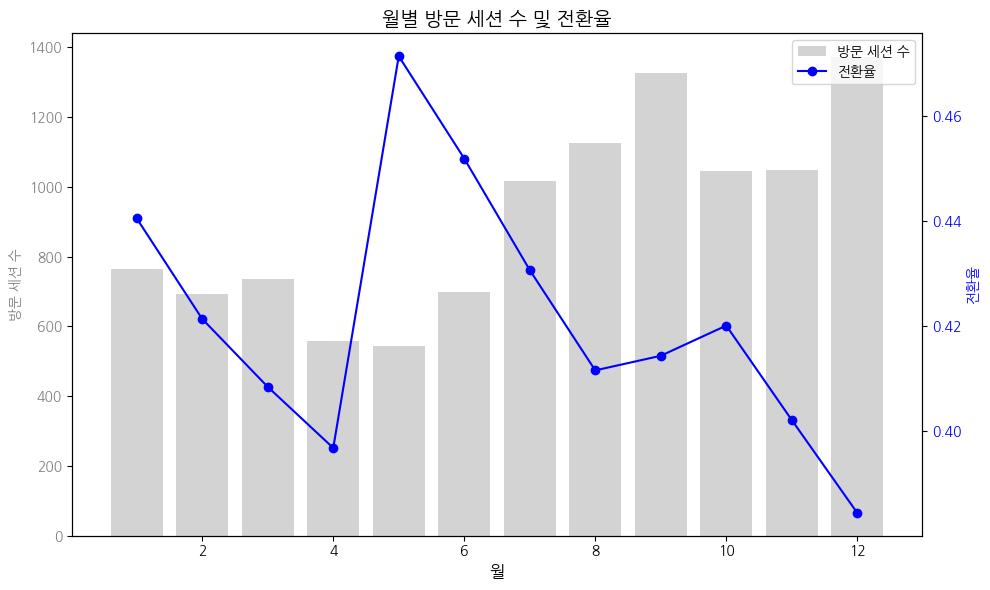

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# 막대: 방문 세션 수
ax1.bar(session_monthly['month'], session_monthly['sessions'], color='lightgray', label='방문 세션 수')
ax1.set_xlabel('월', fontsize=12)
ax1.set_ylabel('방문 세션 수', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# 선: 전환율
ax2 = ax1.twinx()
ax2.plot(session_monthly['month'], session_monthly['conversion_rate'], color='blue', marker='o', label='전환율')
ax2.set_ylabel('전환율', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('월별 방문 세션 수 및 전환율', fontsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 요일-시간대별 전환율 히트맵

> - 입실기준

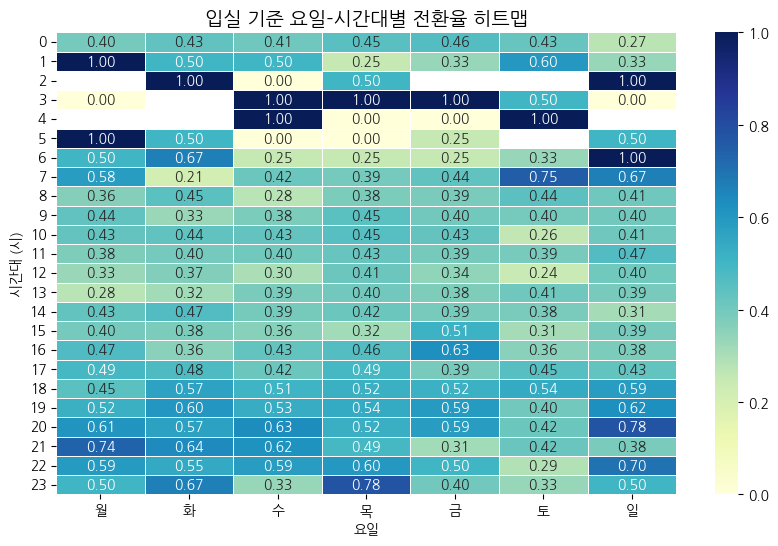

In [ ]:
import seaborn as sns

# 1. 시간 정보 전처리
clean_visit['first_enter_time'] = pd.to_datetime(clean_visit['first_enter_time'].astype(str).str.split('.').str[0])
clean_visit['weekday'] = clean_visit['first_enter_time'].dt.dayofweek   # 0=월요일, 6=일요일
clean_visit['hour'] = clean_visit['first_enter_time'].dt.hour

# 2. 요일 이름 매핑 (선택)
weekday_map = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
clean_visit['weekday_kor'] = clean_visit['weekday'].map(weekday_map)

# 3. 결제 여부 병합
pay_status = payment_df[['user_uuid', 'is_payment']].drop_duplicates()
df = pd.merge(clean_visit[['user_uuid', 'weekday_kor', 'hour']], pay_status, on='user_uuid', how='left')
df['is_payment'] = df['is_payment'].fillna(0).astype(int)

# 4. 피벗 테이블 생성 (전환율 기준)
pivot = df.groupby(['weekday_kor', 'hour']).agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()
pivot['conversion_rate'] = pivot['payers'] / pivot['visitors']

# 요일 정렬 (월~일 순서 유지)
pivot['weekday_kor'] = pd.Categorical(pivot['weekday_kor'],
                                      categories=['월', '화', '수', '목', '금', '토', '일'],
                                      ordered=True)

# 5. 히트맵용 데이터 변환
heatmap_data = pivot.pivot(index='hour', columns='weekday_kor', values='conversion_rate')

# 6. 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.2f', linewidths=0.5)
plt.title('입실 기준 요일-시간대별 전환율 히트맵', fontsize=14)
plt.xlabel('요일')
plt.ylabel('시간대 (시)')
plt.yticks(rotation=0)
plt.show()

- **야간 시간대 (20~23시)**에 전환율 상대적으로 높음
- **심야/새벽 시간대 (0~5시)**는 전화 분석에서 제외하거나 별도 필터링

### 요일-시간대별 전환율 (연도별)

In [ ]:
# 2. 유저별 요일-시간대-연도 추출 & 결제 병합
# 방문 기록 정리
visit_wh = clean_visit[['user_uuid', 'weekday_kor', 'enter_hour', 'year']].drop_duplicates()

# 결제 정보 병합
df_wh = pd.merge(visit_wh, payment_status, on='user_uuid', how='left')
df_wh['is_payment'] = df_wh['is_payment'].fillna(0).astype(int)

# 3. 연도-요일-시간대 전환율 집계
wh_summary = df_wh.groupby(['year', 'weekday_kor', 'enter_hour']).agg(
    visitors=('user_uuid', 'count'),
    payers=('is_payment', 'sum')
).reset_index()

wh_summary['conversion_rate'] = wh_summary['payers'] / wh_summary['visitors']

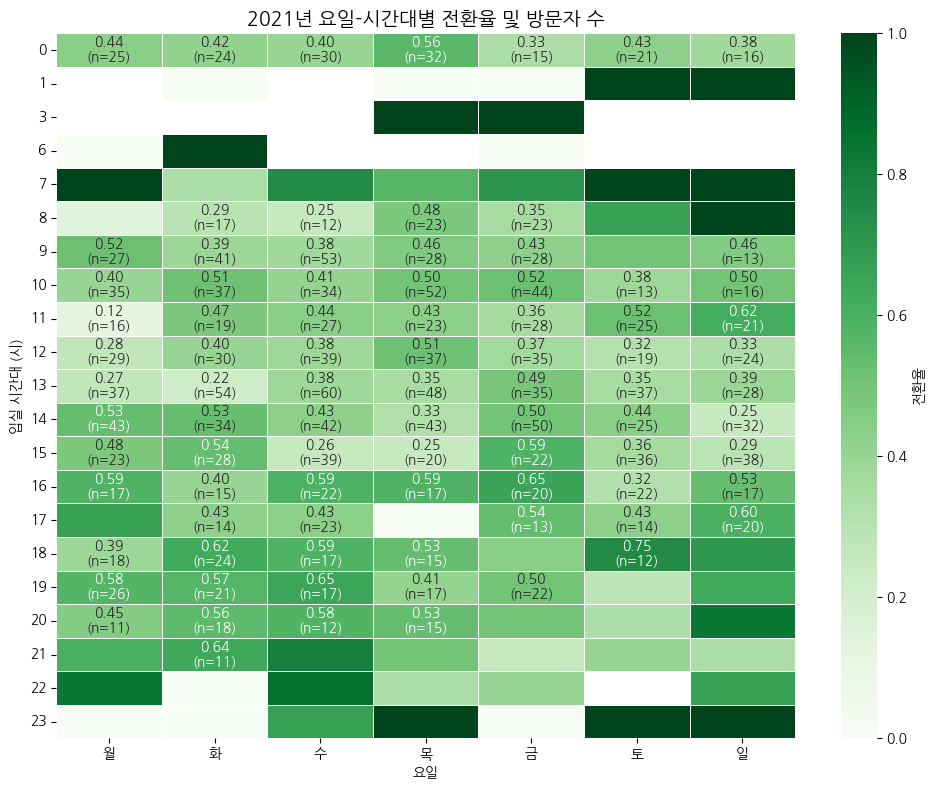

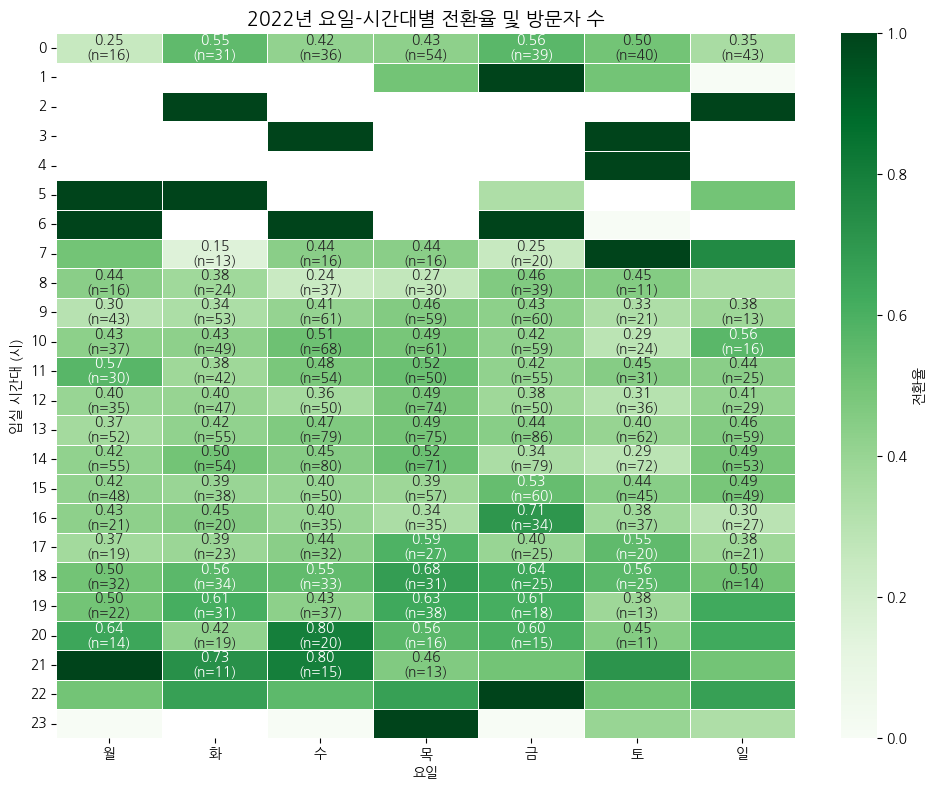

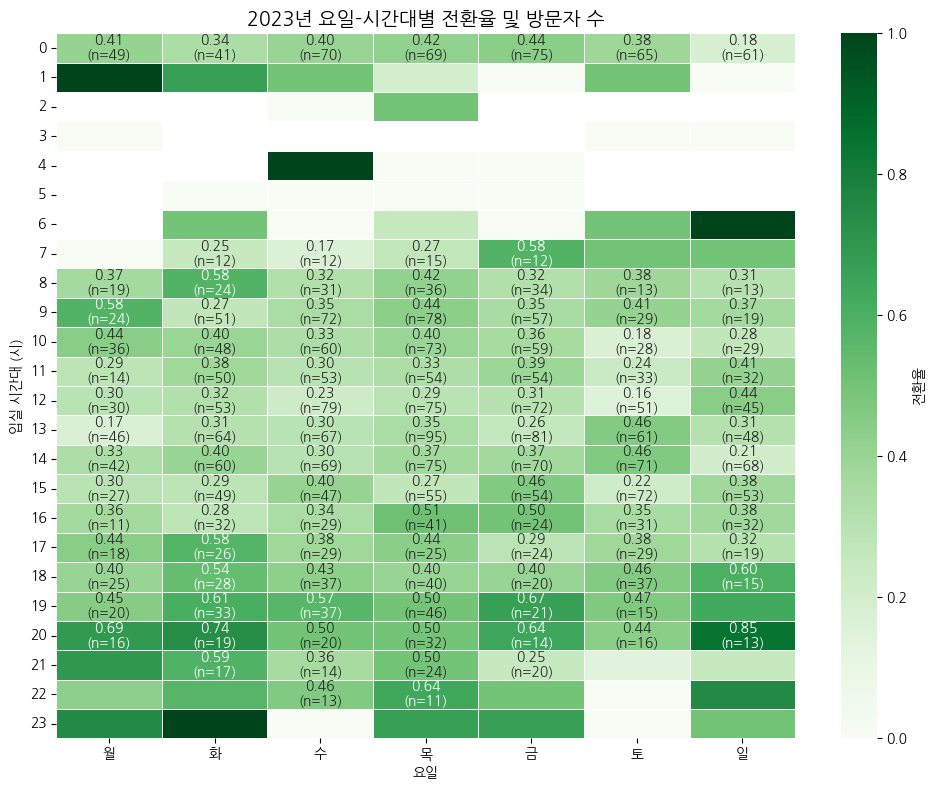

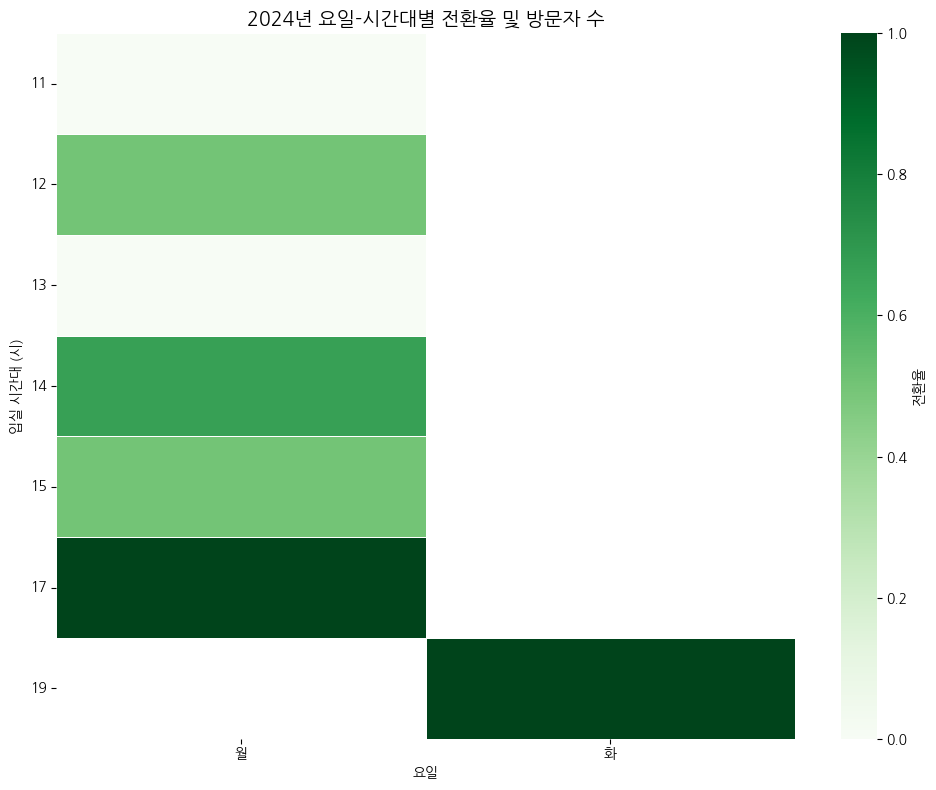

In [ ]:
# 4. 연도별 히트맵 시각화
# 방문자 수 10명이하는 표시 X

# 요일 순서 고정
weekday_order = ['월', '화', '수', '목', '금', '토', '일']
wh_summary['weekday_kor'] = pd.Categorical(wh_summary['weekday_kor'], categories=weekday_order, ordered=True)

# ✅ 방문자 수 조건에 따라 label 생성
wh_summary['label'] = wh_summary.apply(
    lambda x: f"{x['conversion_rate']:.2f}\n(n={x['visitors']})" if x['visitors'] > 10 else '', axis=1
)

# 연도별 히트맵 반복 생성
years = sorted(wh_summary['year'].unique())
for y in years:
    df_y = wh_summary[wh_summary['year'] == y]

    pivot_val = df_y.pivot(index='enter_hour', columns='weekday_kor', values='conversion_rate')
    pivot_text = df_y.pivot(index='enter_hour', columns='weekday_kor', values='label')

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_val, annot=pivot_text, fmt='', cmap='Greens', linewidths=0.5, cbar_kws={'label': '전환율'})
    plt.title(f"{y}년 요일-시간대별 전환율 및 방문자 수", fontsize=14)
    plt.xlabel("요일")
    plt.ylabel("입실 시간대 (시)")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

#### 정규화 및 히트맵

In [ ]:
print(pivot.dtypes)
print(pivot.head())

weekday_kor        category
hour                  int32
visitors              int64
payers                int64
conversion_rate     float64
dtype: object
  weekday_kor  hour  visitors  payers  conversion_rate
0           금     0       130      60         0.461538
1           금     1         3       1         0.333333
2           금     3         1       1         1.000000
3           금     4         1       0         0.000000
4           금     5         4       1         0.250000


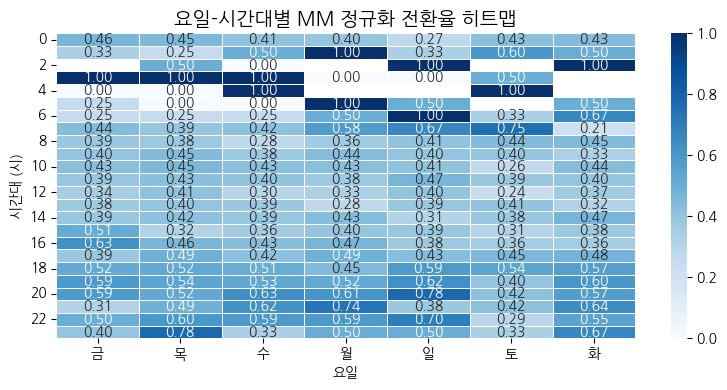

In [ ]:
# 1. 요일을 문자열로 변환
pivot['weekday_kor'] = pivot['weekday_kor'].astype(str)

# 2. 피벗 테이블 생성
pivot_table = pivot.pivot(index='hour', columns='weekday_kor', values='conversion_rate')

# 3. 숫자형 강제 변환
pivot_table = pivot_table.astype(float)

# 4. Min-Max 정규화
pivot_norm = (pivot_table - pivot_table.min().min()) / (pivot_table.max().max() - pivot_table.min().min())

# 5. 히트맵 시각화
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_norm, cmap='Blues', annot=pivot_table, fmt='.2f', linewidths=0.5)
plt.title('요일-시간대별 MM 정규화 전환율 히트맵', fontsize=14)
plt.xlabel('요일')
plt.ylabel('시간대 (시)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

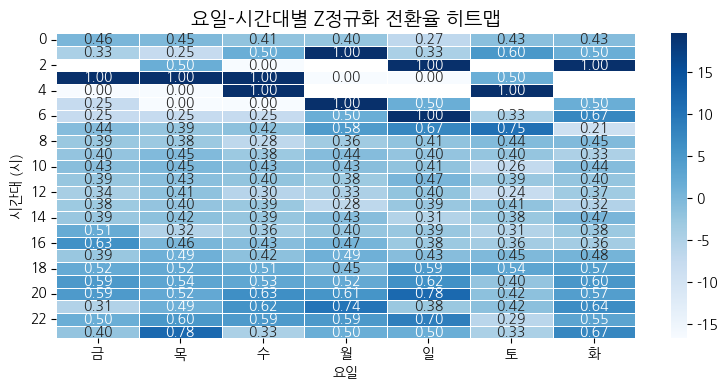

In [ ]:
# 4. Z-score 정규화
pivot_z = (pivot_table - pivot_table.mean().mean()) / pivot_table.std().std()

# 5. 히트맵 시각화
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_z, cmap='Blues', annot=pivot_table, fmt='.2f', linewidths=0.5)
plt.title('요일-시간대별 Z정규화 전환율 히트맵', fontsize=14)
plt.xlabel('요일')
plt.ylabel('시간대 (시)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 월별 평균 체류시간 히트맵

In [ ]:
clean_visit.head()

site_id       date                  stay_time  stay_time_second  \
0       1 2023-12-23 2025-06-18 01:11:19.983486              4279   
1       1 2023-12-24 2025-06-18 04:35:10.361341             16510   
2       1 2023-12-25 2025-06-18 02:09:54.117163              7794   
3       1 2023-12-23 2025-06-18 04:37:36.134901             16656   
4       3 2023-12-26 2025-06-18 04:32:05.289251             16325   

     first_enter_time     last_leave_time  \
0 2023-12-23 16:11:25 2023-12-23 17:25:32   
1 2023-12-24 16:10:45 2023-12-24 20:53:34   
2 2023-12-25 10:19:47 2023-12-25 12:39:51   
3 2023-12-23 14:49:40 2023-12-23 19:27:39   
4 2023-12-26 14:57:10 2023-12-26 19:34:36   

                              user_uuid  enter_hour  month season  \
0  939fc566-61cd-47f0-a3ce-e2936fdcff73          16     12     겨울   
1  939fc566-61cd-47f0-a3ce-e2936fdcff73          16     12     겨울   
2  939fc566-61cd-47f0-a3ce-e2936fdcff73          10     12     겨울   
3  ba49324f-d317-4053-adf9-2b17b3f07594          14     12     겨울   
4  ba49324f-d317-4053-adf9-2b17b3f07594          14     12     겨울   

   stay_time_hour  leave_hour  year  duration_hours duration_group  \
0        1.188611          17  2023        1.235278           1~2h   
1        4.586111          20  2023        4.713611           4~6h   
2        2.165000          12  2023        2.334444           2~4h   
3        4.626667          19  2023        4.633056           4~6h   
4        4.534722          19  2023        4.623889           4~6h   

   duration_minutes  duration_hour_bin  weekday  hour weekday_kor  
0         74.116667                  1        5    16           토  
1        282.816667                  4        6    16           일  
2        140.066667                  2        0    10           월  
3        277.983333                  4        5    14           토  
4        277.433333                  4        1    14           화

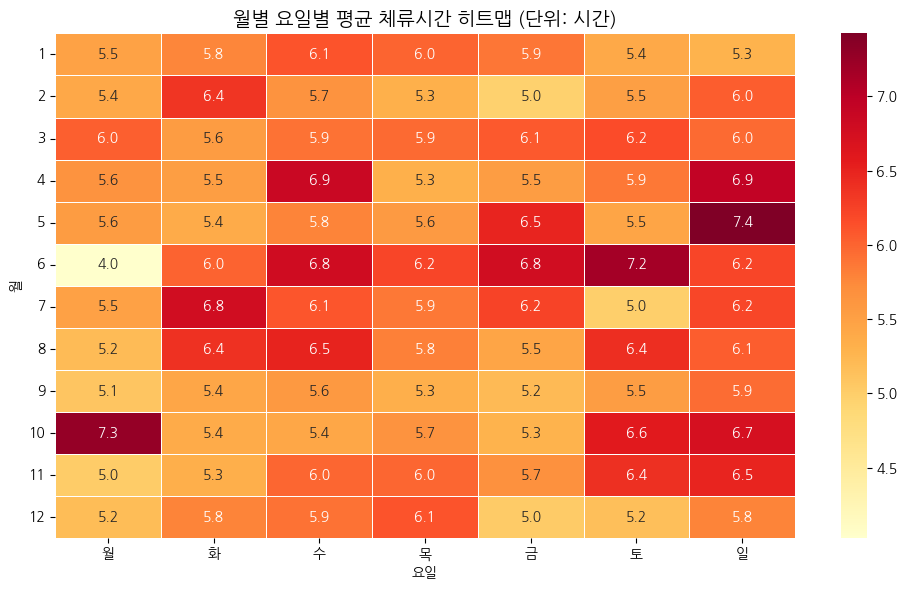

In [ ]:
# 4. 피벗 테이블: 월-요일별 평균 체류시간
pivot_monthly = clean_visit.pivot_table(index='month', columns='weekday_kor', values='duration_hours', aggfunc='mean')

# 5. 요일 순서 지정
pivot_monthly = pivot_monthly[['월', '화', '수', '목', '금', '토', '일']]

# 6. 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_monthly, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5)
plt.title('월별 요일별 평균 체류시간 히트맵 (단위: 시간)', fontsize=14)
plt.xlabel('요일')
plt.ylabel('월')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 지점에 따른 전환율

In [ ]:
total_pay_1['used_sites_count'] = (total_site != 0).sum(axis=1)

In [ ]:
total_pay_1['most_used_count'] = total_site.max(axis=1)
total_pay_1['total_visits'] = total_site.sum(axis=1)

In [ ]:
total_pay_2['most_used_site'] = total_site.idxmax(axis=1)

In [ ]:
# 유저 이용 패턴
total_pay_1

is_payment  used_sites_count  \
user_uuid                                                            
000590dc-046f-462b-8225-4c81a97b7166           0                 1   
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c           3                 1   
0018e22d-a2cc-4e06-bca2-d6a041770f3b           0                 1   
002606d9-38ca-48f3-910c-cbfada9a9109           0                 1   
002a7570-90dd-4cab-b0aa-b0e40f7ef27a           2                 1   
...                                          ...               ...   
ffc79669-ed11-4cde-86d4-8ec232ac7b14           0                 1   
ffcb7950-d150-40ae-a6bf-f85f5c2b9702           0                 1   
ffce32ca-2efc-4485-b685-4b65811c2dcf           0                 1   
ffd287bc-2797-4788-82fa-6268c82e7fa9           0                 1   
fffbf2b3-7853-4c07-bd2a-aae686ac9013           0                 1   

                                      most_used_count  total_visits  
user_uuid                                                            
000590dc-046f-462b-8225-4c81a97b7166              1.0           1.0  
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c              3.0           3.0  
0018e22d-a2cc-4e06-bca2-d6a041770f3b              2.0           2.0  
002606d9-38ca-48f3-910c-cbfada9a9109              2.0           2.0  
002a7570-90dd-4cab-b0aa-b0e40f7ef27a              2.0           2.0  
...                                               ...           ...  
ffc79669-ed11-4cde-86d4-8ec232ac7b14              2.0           2.0  
ffcb7950-d150-40ae-a6bf-f85f5c2b9702              2.0           2.0  
ffce32ca-2efc-4485-b685-4b65811c2dcf              1.0           1.0  
ffd287bc-2797-4788-82fa-6268c82e7fa9              3.0           3.0  
fffbf2b3-7853-4c07-bd2a-aae686ac9013              1.0           1.0  

[6534 rows x 4 columns]

In [ ]:
# 유저별 가장 많이 이용한 지점 정보
total_pay_2

is_payment most_used_site
user_uuid                                                      
000590dc-046f-462b-8225-4c81a97b7166           0         site_6
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c           3         site_3
0018e22d-a2cc-4e06-bca2-d6a041770f3b           0         site_6
002606d9-38ca-48f3-910c-cbfada9a9109           0        site_17
002a7570-90dd-4cab-b0aa-b0e40f7ef27a           2         site_5
...                                          ...            ...
ffc79669-ed11-4cde-86d4-8ec232ac7b14           0         site_1
ffcb7950-d150-40ae-a6bf-f85f5c2b9702           0         site_2
ffce32ca-2efc-4485-b685-4b65811c2dcf           0         site_4
ffd287bc-2797-4788-82fa-6268c82e7fa9           0         site_6
fffbf2b3-7853-4c07-bd2a-aae686ac9013           0         site_6

[6534 rows x 2 columns]

In [ ]:
total_user_site = pd.merge(total_pay_1, total_pay_2, how='left', on='user_uuid')

In [ ]:
total_user_site.reset_index(inplace=True)

In [ ]:
total_user_site.head()

user_uuid  is_payment_x  used_sites_count  \
0  000590dc-046f-462b-8225-4c81a97b7166             0                 1   
1  000be14f-ba0f-4af6-bc2c-7b00dfcbc98c             3                 1   
2  0018e22d-a2cc-4e06-bca2-d6a041770f3b             0                 1   
3  002606d9-38ca-48f3-910c-cbfada9a9109             0                 1   
4  002a7570-90dd-4cab-b0aa-b0e40f7ef27a             2                 1   

   most_used_count  total_visits  is_payment_y most_used_site  
0              1.0           1.0             0         site_6  
1              3.0           3.0             3         site_3  
2              2.0           2.0             0         site_6  
3              2.0           2.0             0        site_17  
4              2.0           2.0             2         site_5

In [ ]:
site_payment_counts = total_pay_2.groupby('most_used_site')['is_payment'].agg(['count', 'sum'])
site_payment_counts.columns = ['user_count', 'payment_user_count']
site_payment_counts['payment_rate'] = site_payment_counts['payment_user_count'] / site_payment_counts['user_count']
site_payment_counts = site_payment_counts.sort_values(by='payment_rate', ascending=False)

In [ ]:
site_payment_counts

user_count  payment_user_count  payment_rate
most_used_site                                              
site_49                135                 121      0.896296
site_5                 598                 502      0.839465
site_3                1335                1098      0.822472
site_1                 869                 663      0.762946
site_4                 497                 371      0.746479
site_2                1095                 793      0.724201
site_17                435                 300      0.689655
site_6                1245                 830      0.666667
site_47                325                 190      0.584615

### 지점별 결제율

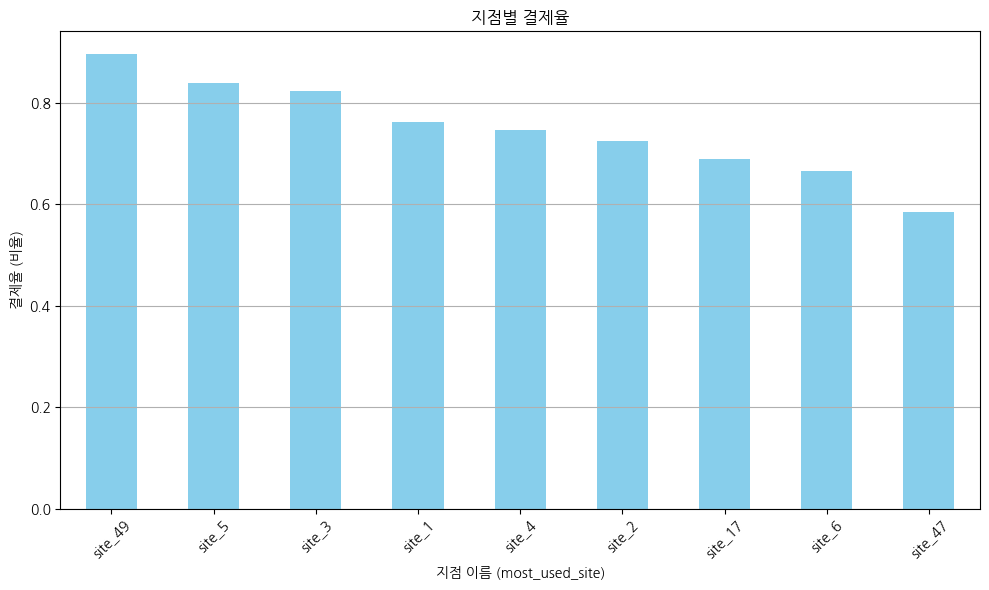

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
site_payment_counts['payment_rate'].plot(kind='bar', color='skyblue')
plt.title('지점별 결제율')
plt.ylabel('결제율 (비율)')
plt.xlabel('지점 이름 (most_used_site)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### 가장 많이 이용한 지점 순위

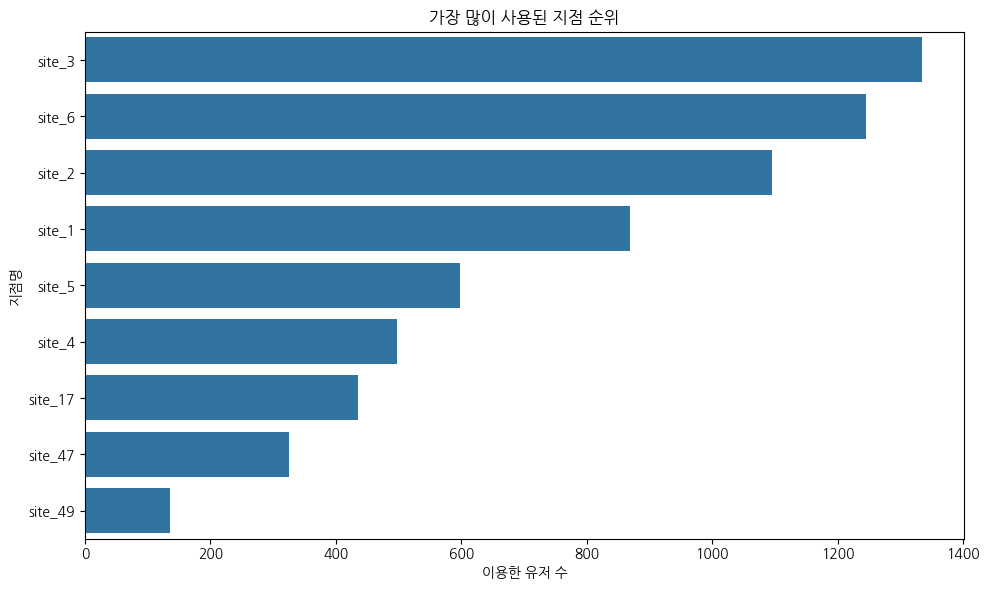

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=total_pay_2, y='most_used_site', order=total_pay_2['most_used_site'].value_counts().index)
plt.title('가장 많이 사용된 지점 순위')
plt.xlabel('이용한 유저 수')
plt.ylabel('지점명')
plt.tight_layout()

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

plt.show()

### 사용한 지점 개수 별 유저 수

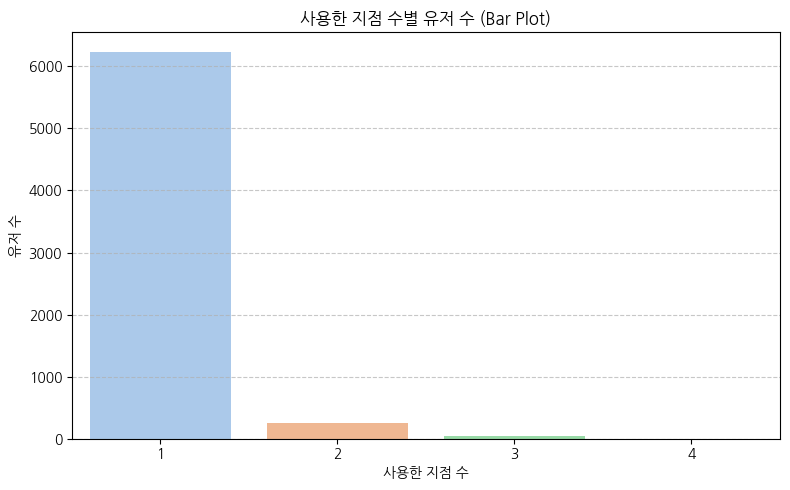

In [ ]:

plt.figure(figsize=(8, 5))
sns.countplot(x='used_sites_count', data=total_pay_1, palette='pastel')
plt.title('사용한 지점 수별 유저 수 (Bar Plot)')
plt.xlabel('사용한 지점 수')
plt.ylabel('유저 수')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 결제 유무에 따른 총 방문 수

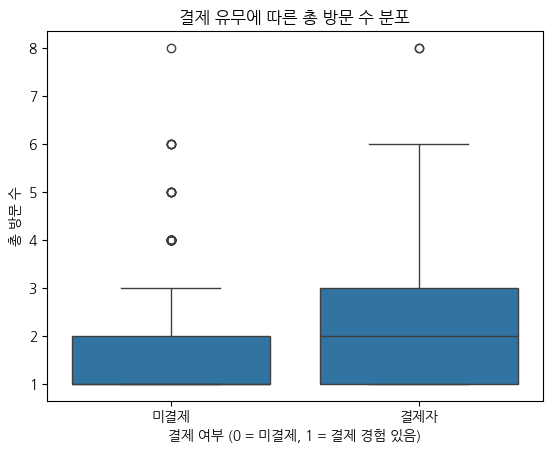

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 이진 컬럼 생성: 0이면 0, 1 이상이면 1
total_pay_1['is_payment_binary'] = (total_pay_1['is_payment'] >= 1).astype(int)

# 2. 박스플롯 시각화
sns.boxplot(x='is_payment_binary', y='total_visits', data=total_pay_1)
plt.title('결제 유무에 따른 총 방문 수 분포')
plt.xlabel('결제 여부 (0 = 미결제, 1 = 결제 경험 있음)')
plt.ylabel('총 방문 수')
plt.xticks([0, 1], ['미결제', '결제자'])  # x축 라벨 명확하게
plt.show()

### 결제 유무별 지점 이용현황

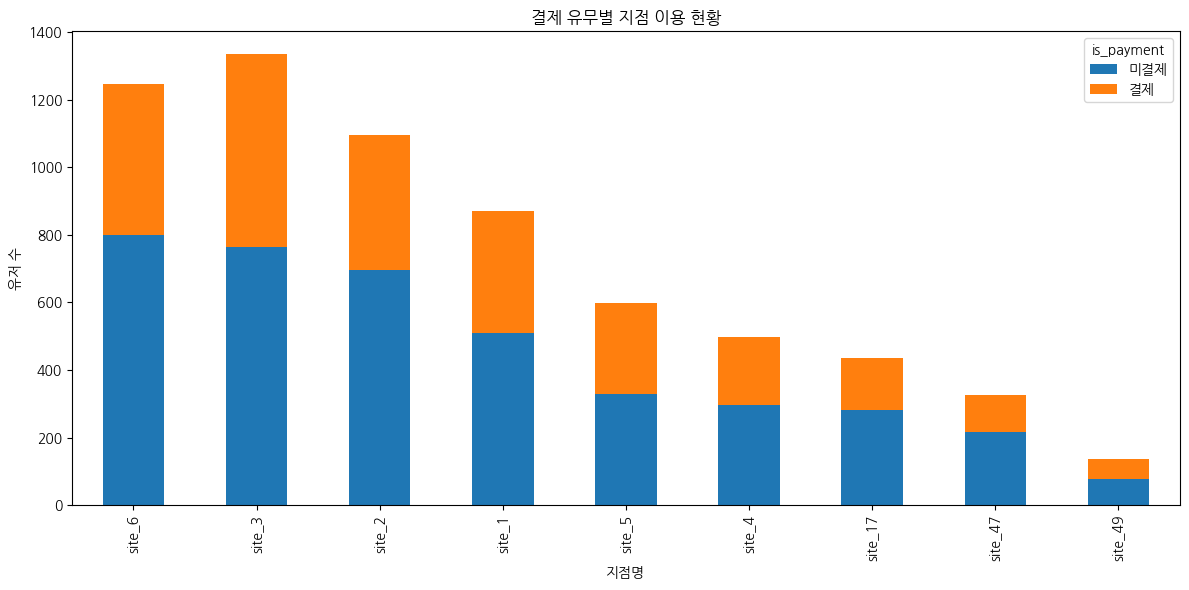

In [ ]:
# 1. 이진 컬럼 생성: 0이면 0, 1 이상이면 1
total_pay_2['is_payment_binary'] = (total_pay_2['is_payment'] >= 1).astype(int)

site_by_payment = total_pay_2.groupby(['most_used_site', 'is_payment_binary']).size().unstack(fill_value=0)

# 시각화
site_by_payment.sort_values(by=0, ascending=False).plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('결제 유무별 지점 이용 현황')
plt.xlabel('지점명')
plt.ylabel('유저 수')
plt.legend(title='is_payment', labels=['미결제', '결제'])
plt.tight_layout()
plt.show()

### 지점(site)별 방문율-재방문율-전환율 그래프

In [ ]:
total_0 = total_g[total_g['is_payment'] == 0]

In [ ]:
total_1 = total_g[total_g['is_payment'] != 0]

In [ ]:
total_0.head()

is_payment  site_1  site_2  site_3  \
user_uuid                                                                  
000590dc-046f-462b-8225-4c81a97b7166           0     0.0     0.0     0.0   
0018e22d-a2cc-4e06-bca2-d6a041770f3b           0     0.0     0.0     0.0   
002606d9-38ca-48f3-910c-cbfada9a9109           0     0.0     0.0     0.0   
0033f84b-2c5b-4a42-a115-80cbbf4fdf80           0     0.0     0.0     0.0   
0038199b-5063-4500-9f5a-f9ad5aed0847           0     0.0     2.0     0.0   

                                      site_4  site_5  site_6  site_17  \
user_uuid                                                               
000590dc-046f-462b-8225-4c81a97b7166     0.0     0.0     1.0      0.0   
0018e22d-a2cc-4e06-bca2-d6a041770f3b     0.0     0.0     2.0      0.0   
002606d9-38ca-48f3-910c-cbfada9a9109     0.0     0.0     0.0      2.0   
0033f84b-2c5b-4a42-a115-80cbbf4fdf80     0.0     0.0     0.0      0.0   
0038199b-5063-4500-9f5a-f9ad5aed0847     0.0     0.0     0.0      0.0   

                                      site_47  site_49  
user_uuid                                               
000590dc-046f-462b-8225-4c81a97b7166      0.0      0.0  
0018e22d-a2cc-4e06-bca2-d6a041770f3b      0.0      0.0  
002606d9-38ca-48f3-910c-cbfada9a9109      0.0      0.0  
0033f84b-2c5b-4a42-a115-80cbbf4fdf80      1.0      0.0  
0038199b-5063-4500-9f5a-f9ad5aed0847      0.0      0.0

In [ ]:
total_1.head()

is_payment  site_1  site_2  site_3  \
user_uuid                                                                  
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c           3     0.0     0.0     3.0   
002a7570-90dd-4cab-b0aa-b0e40f7ef27a           2     0.0     0.0     0.0   
006d1e68-6e56-4ebe-96d5-d0c3452b028e           1     1.0     0.0     0.0   
008211f6-7951-4ca5-837a-76e280aaf829           1     0.0     0.0     0.0   
00a103a4-f03f-444f-a6fd-244809c31d18           2     0.0     0.0     0.0   

                                      site_4  site_5  site_6  site_17  \
user_uuid                                                               
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c     0.0     0.0     0.0      0.0   
002a7570-90dd-4cab-b0aa-b0e40f7ef27a     0.0     2.0     0.0      0.0   
006d1e68-6e56-4ebe-96d5-d0c3452b028e     0.0     0.0     0.0      0.0   
008211f6-7951-4ca5-837a-76e280aaf829     0.0     0.0     0.0      1.0   
00a103a4-f03f-444f-a6fd-244809c31d18     0.0     0.0     2.0      0.0   

                                      site_47  site_49  
user_uuid                                               
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c      0.0      0.0  
002a7570-90dd-4cab-b0aa-b0e40f7ef27a      0.0      0.0  
006d1e68-6e56-4ebe-96d5-d0c3452b028e      0.0      0.0  
008211f6-7951-4ca5-837a-76e280aaf829      0.0      0.0  
00a103a4-f03f-444f-a6fd-244809c31d18      0.0      0.0

In [ ]:
# 지점 리스트
site_columns = ['site_1', 'site_2', 'site_3', 'site_4', 'site_5', 'site_6', 'site_17', 'site_47', 'site_49']

# 전체 사용자 수
total_1_users = total_1.shape[0]

# 결과 저장
site_metrics = []

# 반복
for site in site_columns:
    # 원본 total_1을 매번 복사하여 사용 (site별 컬럼 수정이 전체에 영향 X)
    df = total_1[[site, 'is_payment']].copy()
    df[site] = pd.to_numeric(df[site], errors='coerce').fillna(0)

    # 방문자 (1회 이상)
    visited = df[df[site] >= 1]
    visit_count = visited.shape[0]

    # 재방문자 (2회 이상)
    revisited = df[df[site] >= 2]
    revisit_count = revisited.shape[0]

    # 결제자 중 방문자
    converted = visited[visited['is_payment'] == 1]
    convert_count = converted.shape[0]

    # 계산
    visit_rate = visit_count / total_1_users
    revisit_rate = revisit_count / visit_count if visit_count > 0 else 0
    conversion_rate = convert_count / visit_count if visit_count > 0 else 0

    site_metrics.append({
        'site': site,
        'visit_rate': round(visit_rate, 4),
        'revisit_rate': round(revisit_rate, 4),
        'conversion_rate': round(conversion_rate, 4)
    })

# 결과 데이터프레임
df_site_summary = pd.DataFrame(site_metrics)

In [ ]:
# 데이터프레임 확인
df_site_summary

site  visit_rate  revisit_rate  conversion_rate
0   site_1      0.1521        0.4282           0.3897
1   site_2      0.1607        0.5801           0.3689
2   site_3      0.2340        0.5533           0.3767
3   site_4      0.0831        0.5258           0.4178
4   site_5      0.1088        0.5448           0.4014
5   site_6      0.1880        0.5207           0.4004
6  site_17      0.0690        0.5367           0.3390
7  site_47      0.0441        0.4513           0.5221
8  site_49      0.0242        0.5806           0.3387

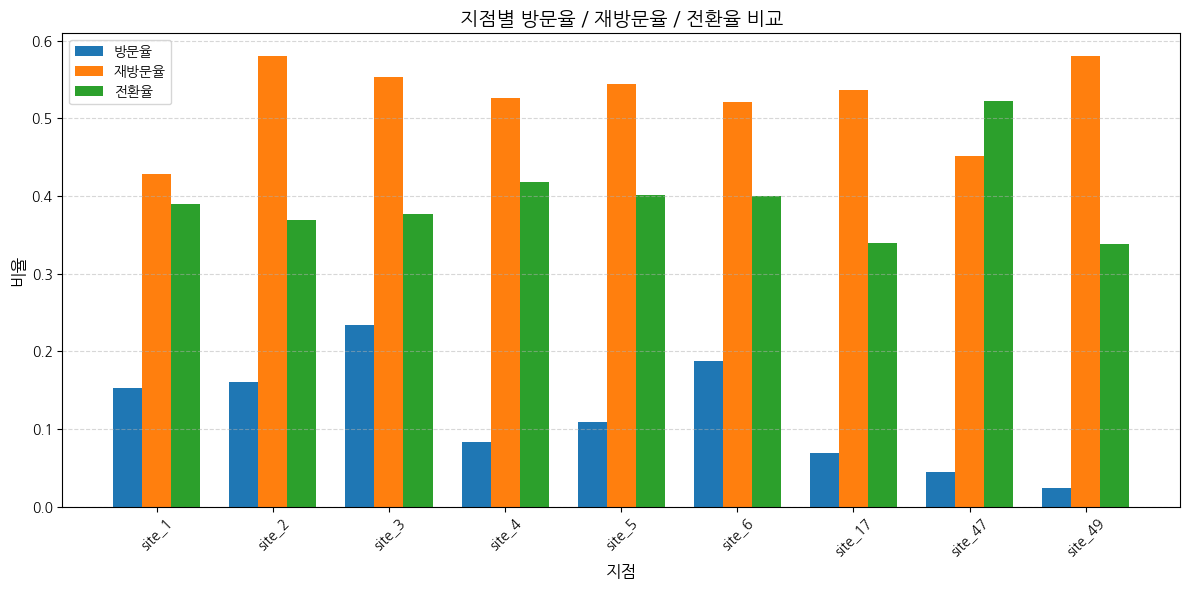

In [ ]:
# X축 위치
x = np.arange(len(df_site_summary))
width = 0.25

# Figure
fig, ax = plt.subplots(figsize=(12, 6))

# 각 막대 그래프
bar1 = ax.bar(x - width, df_site_summary['visit_rate'], width, label='방문율')
bar2 = ax.bar(x, df_site_summary['revisit_rate'], width, label='재방문율')
bar3 = ax.bar(x + width, df_site_summary['conversion_rate'], width, label='전환율')

# 축 설정
ax.set_xlabel('지점', fontsize=12)
ax.set_ylabel('비율', fontsize=12)
ax.set_title('지점별 방문율 / 재방문율 / 전환율 비교', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(df_site_summary['site'], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
total_site.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6534 entries, 000590dc-046f-462b-8225-4c81a97b7166 to fffbf2b3-7853-4c07-bd2a-aae686ac9013
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   site_1   6534 non-null   float64
 1   site_2   6534 non-null   float64
 2   site_3   6534 non-null   float64
 3   site_4   6534 non-null   float64
 4   site_5   6534 non-null   float64
 5   site_6   6534 non-null   float64
 6   site_17  6534 non-null   float64
 7   site_47  6534 non-null   float64
 8   site_49  6534 non-null   float64
dtypes: float64(9)
memory usage: 768.5+ KB


In [ ]:
payment_df

is_payment                             user_uuid
0              0  2b251333-8676-4c11-a736-dcf2350f8821
1              0  e111619a-0975-451b-9a4a-bc8aea7b7b84
2              1  4a184795-b056-4572-a874-644f68609ea3
3              0  2ba8ab19-2d40-4423-ad04-f0f9ca814871
4              0  1d49ba36-6c23-405b-9514-aa7f4aeceff0
...          ...                                   ...
9654           0  d7599df4-1e5a-4f5e-97ce-c42047bfd87c
9655           0  43263092-3b28-4817-9fa9-4205ad3097fe
9656           0  51a40f33-1027-4544-9b95-45bca7c104fb
9657           0  3e649531-bf5b-4b99-84e5-ca3e0e647d0c
9658           0  b7633cc2-bde9-4dff-9c8f-33dac3c976c2

[9624 rows x 2 columns]

In [ ]:
total_site

site_1  site_2  site_3  site_4  site_5  \
user_uuid                                                                      
000590dc-046f-462b-8225-4c81a97b7166     0.0     0.0     0.0     0.0     0.0   
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c     0.0     0.0     3.0     0.0     0.0   
0018e22d-a2cc-4e06-bca2-d6a041770f3b     0.0     0.0     0.0     0.0     0.0   
002606d9-38ca-48f3-910c-cbfada9a9109     0.0     0.0     0.0     0.0     0.0   
002a7570-90dd-4cab-b0aa-b0e40f7ef27a     0.0     0.0     0.0     0.0     2.0   
...                                      ...     ...     ...     ...     ...   
ffc79669-ed11-4cde-86d4-8ec232ac7b14     2.0     0.0     0.0     0.0     0.0   
ffcb7950-d150-40ae-a6bf-f85f5c2b9702     0.0     2.0     0.0     0.0     0.0   
ffce32ca-2efc-4485-b685-4b65811c2dcf     0.0     0.0     0.0     1.0     0.0   
ffd287bc-2797-4788-82fa-6268c82e7fa9     0.0     0.0     0.0     0.0     0.0   
fffbf2b3-7853-4c07-bd2a-aae686ac9013     0.0     0.0     0.0     0.0     0.0   

                                      site_6  site_17  site_47  site_49  
user_uuid                                                                
000590dc-046f-462b-8225-4c81a97b7166     1.0      0.0      0.0      0.0  
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c     0.0      0.0      0.0      0.0  
0018e22d-a2cc-4e06-bca2-d6a041770f3b     2.0      0.0      0.0      0.0  
002606d9-38ca-48f3-910c-cbfada9a9109     0.0      2.0      0.0      0.0  
002a7570-90dd-4cab-b0aa-b0e40f7ef27a     0.0      0.0      0.0      0.0  
...                                      ...      ...      ...      ...  
ffc79669-ed11-4cde-86d4-8ec232ac7b14     0.0      0.0      0.0      0.0  
ffcb7950-d150-40ae-a6bf-f85f5c2b9702     0.0      0.0      0.0      0.0  
ffce32ca-2efc-4485-b685-4b65811c2dcf     0.0      0.0      0.0      0.0  
ffd287bc-2797-4788-82fa-6268c82e7fa9     3.0      0.0      0.0      0.0  
fffbf2b3-7853-4c07-bd2a-aae686ac9013     1.0      0.0      0.0      0.0  

[6534 rows x 9 columns]

In [ ]:
visited

site_49  is_payment
user_uuid                                                
049ca369-e2bc-45ee-acd3-5b186ec13e90      1.0           3
0686327f-6485-4e25-9402-34bac5ce50d9      1.0           1
0a52d0fd-e411-4437-b6fb-a75bc0ff6ed2      2.0           3
0ab5d66b-dd2b-4d76-bd53-290d28dc8126      1.0           1
0fd76963-48a7-4dcd-be84-5f3a23f4ecfe      3.0           3
...                                       ...         ...
e149e8a4-5606-45b3-ac47-a2131cb2a998      3.0           3
e5342efd-4d7d-4521-a274-0bacdaed7932      1.0           1
fbd3a1d2-7a8f-4dc6-b5c2-277f3b19c434      1.0           1
fbe20442-74e6-4a06-9b1c-1d4f1bff84b8      3.0           3
fea5ff57-9427-4f4b-861b-5a13e27c2a5b      2.0           2

[62 rows x 2 columns]

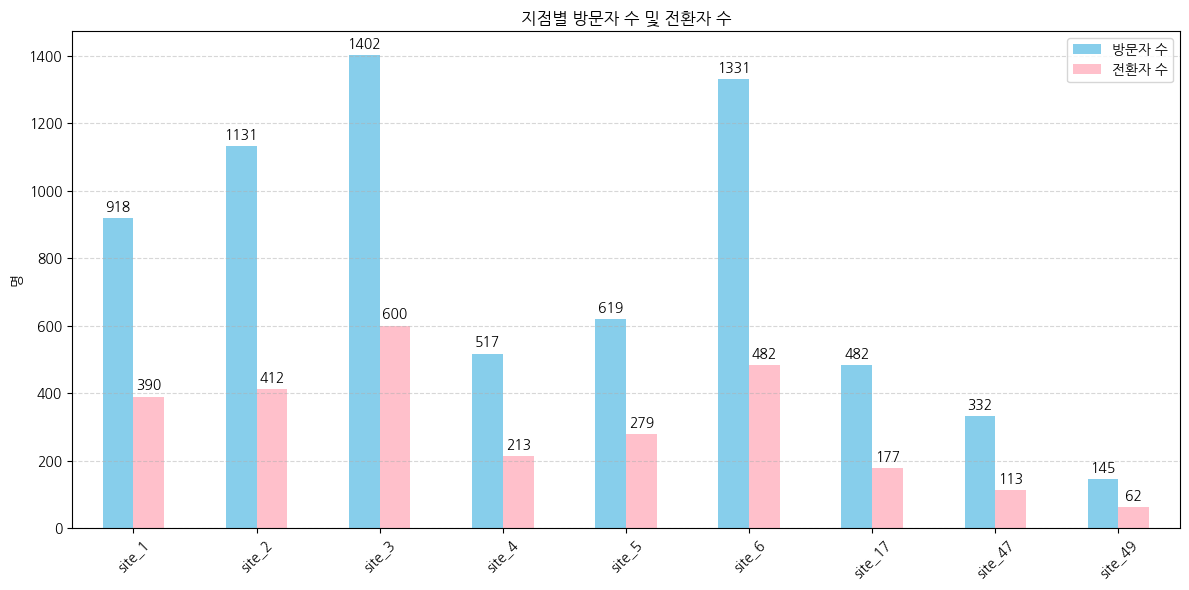

In [ ]:
# 1. 방문 여부
visited = (total_site) > 0

# 2. 결제 여부
# user_uuid가 이미 payment_df의 인덱스이므로 set_index를 호출할 필요가 없습니다.
payment_df = payment_df.set_index('user_uuid')
payment_map = payment_df['is_payment'].reindex(total_site.index).fillna(0).astype(int)

# 3. 전환자 수 = 방문 AND 결제
converted_user = visited.multiply(payment_map, axis=0)  # element-wise 곱
converted_user_count = converted_user.sum(axis=0)       # 지점별 전환자 수

# 4. 데이터프레임 생성
summary_df = pd.DataFrame({
    '방문자 수': visited.sum(axis=0),
    '전환자 수': converted_user_count
})

# 5. 시각화
ax = summary_df.plot(kind='bar', figsize=(12, 6), color = ('skyblue', 'pink'))
plt.title('지점별 방문자 수 및 전환자 수')
plt.ylabel('명')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# 레이블 추가
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=10)

plt.show()

# 예측모델 모델링

In [ ]:
merge_total = pd.read_csv('/content/병합완료.csv')

In [ ]:
merge_total.head()

user_uuid  total_stay_time  visit_count  \
0  000590dc-046f-462b-8225-4c81a97b7166            21417            1   
1  000be14f-ba0f-4af6-bc2c-7b00dfcbc98c            45569            3   
2  000be14f-ba0f-4af6-bc2c-7b00dfcbc98c            45569            3   
3  000be14f-ba0f-4af6-bc2c-7b00dfcbc98c            45569            3   
4  0018e22d-a2cc-4e06-bca2-d6a041770f3b            77372            2   

   active_days first_visit_date last_visit_date  avg_stay_time  \
0            1       2023-09-05      2023-09-05   21417.000000   
1            3       2021-09-30      2021-10-02   15189.666667   
2            3       2021-09-30      2021-10-02   15189.666667   
3            3       2021-09-30      2021-10-02   15189.666667   
4            2       2023-11-15      2023-11-16   38686.000000   

   trial_days_span  total_stay_hours  is_payment  ... weekend_ratio  \
0                1          5.949167           0  ...           0.0   
1                3         12.658056           1  ...           0.0   
2                3         12.658056           1  ...           0.0   
3                3         12.658056           1  ...           0.0   
4                2         21.492222           0  ...           0.0   

   long_session_ratio early_bird_ratio evening_ratio  weekday_diversity  \
0            0.666667         0.333333           0.0                  1   
1            0.111111         0.555556           0.0                  2   
2            0.111111         0.555556           0.0                  2   
3            0.111111         0.555556           0.0                  2   
4            0.500000         0.125000           0.0                  2   

  is_payment.1 used_sites_count  most_used_count  total_visits  most_used_site  
0            0                1              1.0           1.0          site_6  
1            1                1              3.0           3.0          site_3  
2            1                1              3.0           3.0          site_3  
3            1                1              3.0           3.0          site_3  
4            0                1              2.0           2.0          site_6  

[5 rows x 37 columns]

##importance 전체

📊 정확도: 0.8588531821045998

📄 분류 리포트:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       914
           1       0.92      0.73      0.81       673

    accuracy                           0.86      1587
   macro avg       0.88      0.84      0.85      1587
weighted avg       0.87      0.86      0.86      1587



<ipython-input-4-3419319395>:75: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


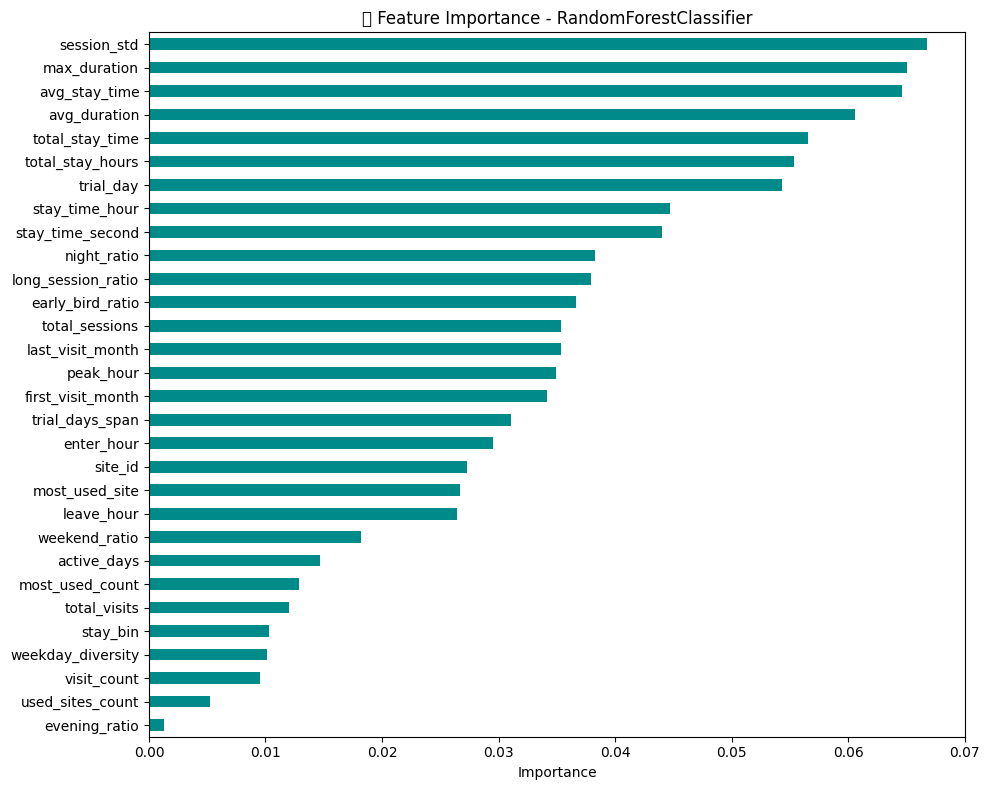

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = merge_total

# 2. 날짜형 변환
date_cols = ['first_visit_date', 'last_visit_date', 'date', 'first_enter_time', 'last_leave_time', 'trial_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# 3. 날짜형 파생 피처 생성
df['first_visit_month'] = df['first_visit_date'].dt.month
df['last_visit_month'] = df['last_visit_date'].dt.month
df['trial_day'] = df['trial_date'].dt.day
df['enter_hour'] = df['first_enter_time'].dt.hour
df['leave_hour'] = df['last_leave_time'].dt.hour

# 4. 문자열 범주형 변수 인코딩
label_cols = ['stay_bin', 'most_used_site']
for col in label_cols:
    df[col] = df[col].astype(str)  # NaN 방지
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 5. 사용할 피처 정의
feature_cols = [
    'total_sessions', 'avg_duration', 'max_duration', 'session_std',
    'peak_hour', 'night_ratio', 'weekend_ratio', 'long_session_ratio',
    'early_bird_ratio', 'evening_ratio', 'weekday_diversity',
    'total_stay_time', 'visit_count', 'active_days', 'avg_stay_time',
    'trial_days_span', 'total_stay_hours', 'stay_time_second',
    'stay_time_hour', 'enter_hour', 'leave_hour', 'site_id',
    'used_sites_count', 'most_used_count', 'total_visits',
    'first_visit_month', 'last_visit_month', 'trial_day',
    'stay_bin', 'most_used_site'
]

# 6. 결측치 제거
selected_cols = feature_cols + ['is_payment']
df_clean = df[selected_cols].dropna()

# 7. X, y 분리
X = df_clean[feature_cols]
y = df_clean['is_payment']

# 8. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 9. 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 10. 예측 및 평가
y_pred = model.predict(X_test)

print("📊 정확도:", accuracy_score(y_test, y_pred))
print("\n📄 분류 리포트:")
print(classification_report(y_test, y_pred))

# 11. 피처 중요도 시각화
importances = model.feature_importances_
importances_series = pd.Series(importances, index=feature_cols).sort_values()

plt.figure(figsize=(10, 8))
importances_series.plot(kind='barh', color='darkcyan')
plt.title("🎯 Feature Importance - RandomForestClassifier")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
importances_series

evening_ratio         0.001286
used_sites_count      0.005258
visit_count           0.009521
weekday_diversity     0.010134
stay_bin              0.010328
total_visits          0.011998
most_used_count       0.012869
active_days           0.014644
weekend_ratio         0.018233
leave_hour            0.026433
most_used_site        0.026696
site_id               0.027263
enter_hour            0.029532
trial_days_span       0.031109
first_visit_month     0.034178
peak_hour             0.034927
last_visit_month      0.035321
total_sessions        0.035348
early_bird_ratio      0.036686
long_session_ratio    0.037920
night_ratio           0.038248
stay_time_second      0.044060
stay_time_hour        0.044728
trial_day             0.054365
total_stay_hours      0.055316
total_stay_time       0.056582
avg_duration          0.060615
avg_stay_time         0.064606
max_duration          0.065065
session_std           0.066732
dtype: float64

##importance >=0.06

✅ 중요도 ≥ 0.06인 피처 목록:
['avg_duration', 'max_duration', 'session_std', 'avg_stay_time']

📊 정확도: 0.8771266540642723

📄 분류 리포트:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       914
           1       0.89      0.81      0.85       673

    accuracy                           0.88      1587
   macro avg       0.88      0.87      0.87      1587
weighted avg       0.88      0.88      0.88      1587



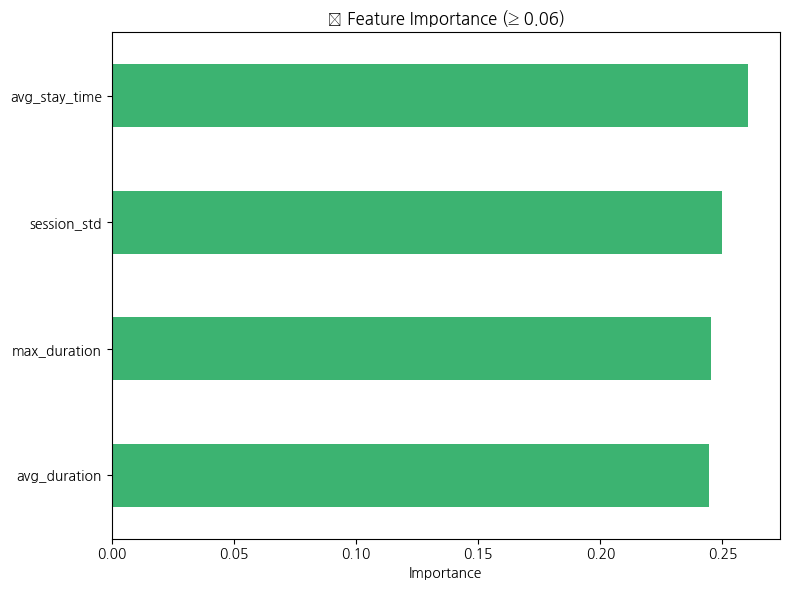

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# 1. 데이터 복사
df = merge_total

# 2. 날짜형 컬럼 변환
date_cols = ['first_visit_date', 'last_visit_date', 'date', 'first_enter_time', 'last_leave_time', 'trial_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# 3. 날짜 파생 컬럼
df['first_visit_month'] = df['first_visit_date'].dt.month
df['last_visit_month'] = df['last_visit_date'].dt.month
df['trial_day'] = df['trial_date'].dt.day
df['enter_hour'] = df['first_enter_time'].dt.hour
df['leave_hour'] = df['last_leave_time'].dt.hour

# 4. 범주형 인코딩
for col in ['stay_bin', 'most_used_site']:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 5. 전체 feature 후보 리스트
feature_cols = [
    'total_sessions', 'avg_duration', 'max_duration', 'session_std',
    'peak_hour', 'night_ratio', 'weekend_ratio', 'long_session_ratio',
    'early_bird_ratio', 'evening_ratio', 'weekday_diversity',
    'total_stay_time', 'visit_count', 'active_days', 'avg_stay_time',
    'trial_days_span', 'total_stay_hours', 'stay_time_second',
    'stay_time_hour', 'enter_hour', 'leave_hour', 'site_id',
    'used_sites_count', 'most_used_count', 'total_visits',
    'first_visit_month', 'last_visit_month', 'trial_day',
    'stay_bin', 'most_used_site'
]

# 6. 결측치 제거
selected_cols = feature_cols + ['is_payment']
df_clean = df[selected_cols].dropna()

X_full = df_clean[feature_cols]
y = df_clean['is_payment']

# 7. 랜덤포레스트로 중요도 계산
temp_model = RandomForestClassifier(n_estimators=100, random_state=42)
temp_model.fit(X_full, y)
importances = pd.Series(temp_model.feature_importances_, index=feature_cols)
important_features = importances[importances >= 0.06].index.tolist()

print("✅ 중요도 ≥ 0.06인 피처 목록:")
print(important_features)

# 8. 중요 피처만 선택해 모델 재학습
X_selected = df_clean[important_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 9. 평가 출력
print("\n📊 정확도:", accuracy_score(y_test, y_pred))
print("\n📄 분류 리포트:")
print(classification_report(y_test, y_pred))

# 10. 중요도 시각화
final_importances = pd.Series(model.feature_importances_, index=important_features).sort_values()

plt.figure(figsize=(8, 6))
final_importances.plot(kind='barh', color='mediumseagreen')
plt.title("🎯 Feature Importance (≥ 0.06)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
final_importances

avg_duration     0.244420
max_duration     0.245347
session_std      0.249722
avg_stay_time    0.260511
dtype: float64

##importance >= 0.05

🎯 중요도 0.05 이상 선택된 피처: ['avg_duration', 'max_duration', 'session_std', 'total_stay_time', 'avg_stay_time', 'total_stay_hours', 'stay_time_second', 'stay_time_hour']
📊 [모델 평가 결과]
정확도 (Accuracy): 0.7712665406427222

[분류 리포트]
              precision    recall  f1-score   support

           0       0.76      0.88      0.82       914
           1       0.79      0.62      0.70       673

    accuracy                           0.77      1587
   macro avg       0.78      0.75      0.76      1587
weighted avg       0.77      0.77      0.77      1587


[혼동 행렬]
[[806 108]
 [255 418]]


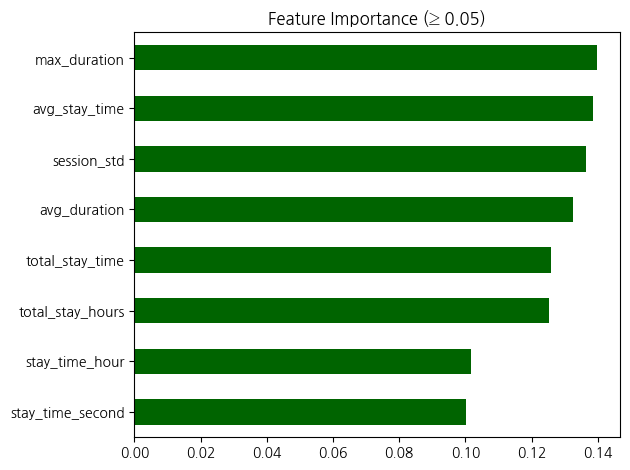

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# 1. 데이터프레임 불러오기 (예시: total_user_merge_3)
df = merge_total

# 2. 사용할 전체 피처 목록
feature_cols = [
    'total_sessions', 'avg_duration', 'max_duration', 'session_std',
    'peak_hour', 'night_ratio', 'weekend_ratio', 'long_session_ratio',
    'early_bird_ratio', 'evening_ratio', 'weekday_diversity', 'total_stay_time',
    'visit_count', 'active_days', 'avg_stay_time', 'trial_days_span',
    'total_stay_hours', 'stay_time_second', 'stay_time_hour',
    'enter_hour', 'leave_hour', 'used_sites_count', 'most_used_count',
    'total_visits'
]

# 3. 결측치 제거
selected_cols = feature_cols + ['is_payment']
df_clean = df[selected_cols].dropna()

# 4. X, y 분리
X = df_clean[feature_cols]
y = df_clean['is_payment']

# 5. 임시로 전체 피처로 학습 → 중요도 확인용
model_temp = RandomForestClassifier(n_estimators=100, random_state=42)
model_temp.fit(X, y)
importances = model_temp.feature_importances_

# 6. 중요도 0.05 이상인 피처만 선택
importance_series = pd.Series(importances, index=feature_cols)
selected_features = importance_series[importance_series >= 0.05].index.tolist()

print("🎯 중요도 0.05 이상 선택된 피처:", selected_features)

# 7. 선택된 피처로 다시 데이터 분리
X_selected = df_clean[selected_features]
y_selected = df_clean['is_payment']

# 8. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_selected, test_size=0.2, random_state=42
)

# 9. 모델 재학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 10. 예측 및 평가
y_pred = model.predict(X_test)

print("📊 [모델 평가 결과]")
print("정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("\n[분류 리포트]")
print(classification_report(y_test, y_pred))
print("\n[혼동 행렬]")
print(confusion_matrix(y_test, y_pred))

# 11. 피처 중요도 시각화
importance_final = model.feature_importances_
pd.Series(importance_final, index=selected_features).sort_values().plot(kind='barh', color='darkgreen')
plt.title("Feature Importance (≥ 0.05)")
plt.tight_layout()
plt.show()

## importance >= 0.04

✅ 중요도 ≥ 0.04인 피처 목록:
['avg_duration', 'max_duration', 'session_std', 'total_stay_time', 'avg_stay_time', 'total_stay_hours', 'stay_time_second', 'stay_time_hour', 'trial_day']

📊 정확도: 0.8052930056710775

📄 분류 리포트:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       914
           1       0.85      0.65      0.74       673

    accuracy                           0.81      1587
   macro avg       0.82      0.79      0.79      1587
weighted avg       0.81      0.81      0.80      1587



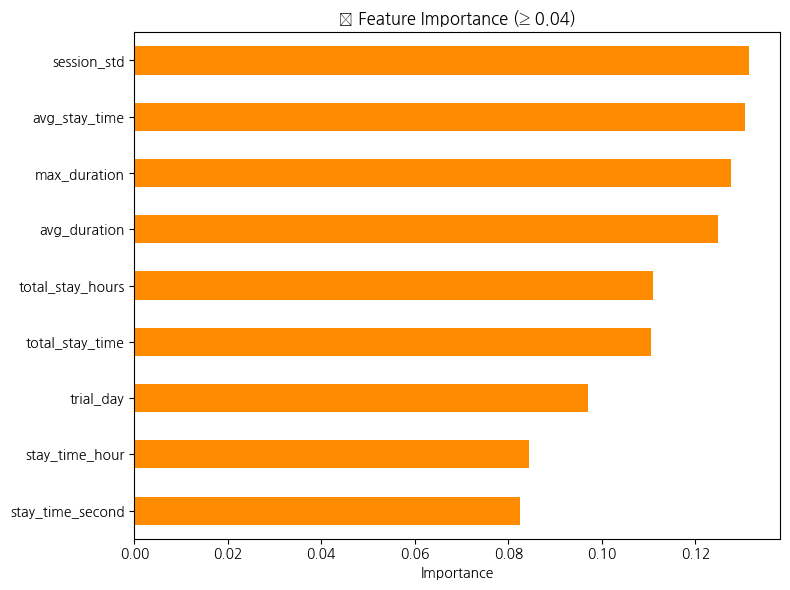

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# 1. 데이터 복사
df = merge_total

# 2. 날짜형 컬럼 변환
date_cols = ['first_visit_date', 'last_visit_date', 'date', 'first_enter_time', 'last_leave_time', 'trial_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# 3. 날짜형 파생 컬럼 생성
df['first_visit_month'] = df['first_visit_date'].dt.month
df['last_visit_month'] = df['last_visit_date'].dt.month
df['trial_day'] = df['trial_date'].dt.day
df['enter_hour'] = df['first_enter_time'].dt.hour
df['leave_hour'] = df['last_leave_time'].dt.hour

# 4. 범주형 인코딩
label_cols = ['stay_bin', 'most_used_site']
for col in label_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 5. 전체 피처 목록
feature_cols = [
    'total_sessions', 'avg_duration', 'max_duration', 'session_std',
    'peak_hour', 'night_ratio', 'weekend_ratio', 'long_session_ratio',
    'early_bird_ratio', 'evening_ratio', 'weekday_diversity',
    'total_stay_time', 'visit_count', 'active_days', 'avg_stay_time',
    'trial_days_span', 'total_stay_hours', 'stay_time_second',
    'stay_time_hour', 'enter_hour', 'leave_hour', 'site_id',
    'used_sites_count', 'most_used_count', 'total_visits',
    'first_visit_month', 'last_visit_month', 'trial_day',
    'stay_bin', 'most_used_site'
]

# 6. 결측치 제거
selected_cols = feature_cols + ['is_payment']
df_clean = df[selected_cols].dropna()

X_full = df_clean[feature_cols]
y = df_clean['is_payment']

# 7. 랜덤포레스트로 중요도 계산
temp_model = RandomForestClassifier(n_estimators=100, random_state=42)
temp_model.fit(X_full, y)
importances = pd.Series(temp_model.feature_importances_, index=feature_cols)
important_features = importances[importances >= 0.04].index.tolist()

print("✅ 중요도 ≥ 0.04인 피처 목록:")
print(important_features)

# 8. 중요 피처만 선택해 모델 재학습
X_selected = df_clean[important_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 9. 평가 결과 출력
print("\n📊 정확도:", accuracy_score(y_test, y_pred))
print("\n📄 분류 리포트:")
print(classification_report(y_test, y_pred))

# 10. 중요도 시각화
final_importances = pd.Series(model.feature_importances_, index=important_features).sort_values()

plt.figure(figsize=(8, 6))
final_importances.plot(kind='barh', color='darkorange')
plt.title("🎯 Feature Importance (≥ 0.04)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## importance >= 0.03

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# 1. 데이터프레임 불러오기 (예시: total_user_merge_3)
df = merge_total

# 2. 사용할 전체 피처 목록
feature_cols = [
    'total_sessions', 'avg_duration', 'max_duration', 'session_std',
    'peak_hour', 'night_ratio', 'weekend_ratio', 'long_session_ratio',
    'early_bird_ratio', 'evening_ratio', 'weekday_diversity', 'total_stay_time',
    'visit_count', 'active_days', 'avg_stay_time', 'trial_days_span',
    'total_stay_hours', 'stay_time_second', 'stay_time_hour',
    'enter_hour', 'leave_hour', 'used_sites_count', 'most_used_count',
    'total_visits'
]

# 3. 결측치 제거
selected_cols = feature_cols + ['is_payment']
df_clean = df[selected_cols].dropna()

# 4. X, y 분리
X = df_clean[feature_cols]
y = df_clean['is_payment']

# 5. 임시로 전체 피처로 학습 → 중요도 확인용
model_temp = RandomForestClassifier(n_estimators=100, random_state=42)
model_temp.fit(X, y)
importances = model_temp.feature_importances_

# 6. 중요도 0.03 이상인 피처만 선택
importance_series = pd.Series(importances, index=feature_cols)
selected_features = importance_series[importance_series >= 0.03].index.tolist()

print("🎯 중요도 0.03 이상 선택된 피처:", selected_features)

# 7. 선택된 피처로 다시 데이터 분리
X_selected = df_clean[selected_features]
y_selected = df_clean['is_payment']

# 8. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_selected, test_size=0.2, random_state=42
)

# 9. 모델 재학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 10. 예측 및 평가
y_pred = model.predict(X_test)

print("📊 [모델 평가 결과]")
print("정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("\n[분류 리포트]")
print(classification_report(y_test, y_pred))
print("\n[혼동 행렬]")
print(confusion_matrix(y_test, y_pred))

# 11. 피처 중요도 시각화
importance_final = model.feature_importances_
pd.Series(importance_final, index=selected_features).sort_values().plot(kind='barh', color='darkgreen')
plt.title("Feature Importance (≥ 0.03)")
plt.tight_layout()
plt.show()

🎯 중요도 0.03 이상 선택된 피처: ['total_sessions', 'avg_duration', 'max_duration', 'session_std', 'peak_hour', 'night_ratio', 'long_session_ratio', 'early_bird_ratio', 'total_stay_time', 'avg_stay_time', 'trial_days_span', 'total_stay_hours', 'stay_time_second', 'stay_time_hour', 'enter_hour', 'leave_hour']
📊 [모델 평가 결과]
정확도 (Accuracy): 0.8229363579080026

[분류 리포트]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       914
           1       0.87      0.69      0.77       673

    accuracy                           0.82      1587
   macro avg       0.83      0.80      0.81      1587
weighted avg       0.83      0.82      0.82      1587


[혼동 행렬]
[[844  70]
 [211 462]]


## importance >= 0.02

📌 선택된 중요 피처 목록 (importance ≥ 0.02):
['total_sessions', 'avg_duration', 'max_duration', 'session_std', 'peak_hour', 'night_ratio', 'long_session_ratio', 'early_bird_ratio', 'total_stay_time', 'avg_stay_time', 'trial_days_span', 'total_stay_hours', 'stay_time_second', 'stay_time_hour', 'enter_hour', 'leave_hour', 'site_id', 'first_visit_month', 'last_visit_month', 'trial_day', 'most_used_site']

📊 정확도: 0.8412098298676749

📄 분류 리포트:
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       914
           1       0.89      0.71      0.79       673

    accuracy                           0.84      1587
   macro avg       0.85      0.82      0.83      1587
weighted avg       0.85      0.84      0.84      1587



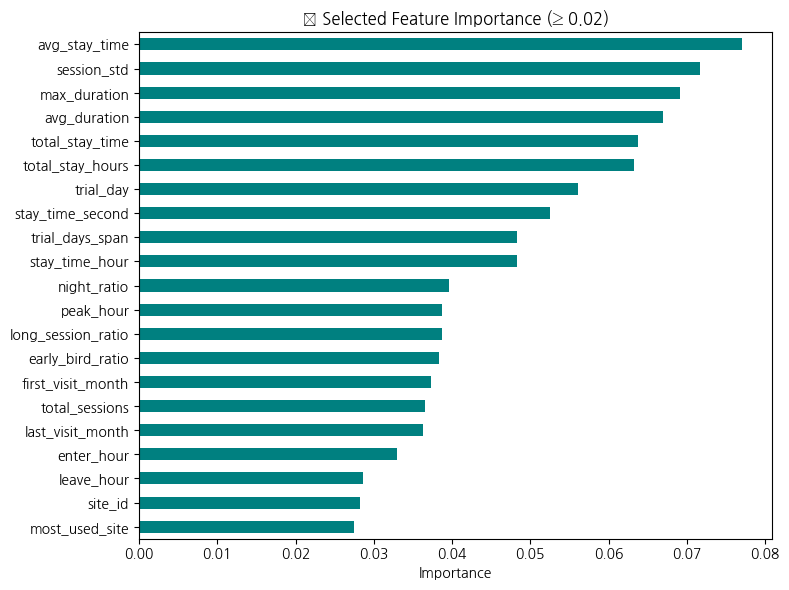

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = merge_total

# 2. 날짜형 변환
date_cols = ['first_visit_date', 'last_visit_date', 'date', 'first_enter_time', 'last_leave_time', 'trial_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# 3. 날짜형 파생 피처 생성
df['first_visit_month'] = df['first_visit_date'].dt.month
df['last_visit_month'] = df['last_visit_date'].dt.month
df['trial_day'] = df['trial_date'].dt.day
df['enter_hour'] = df['first_enter_time'].dt.hour
df['leave_hour'] = df['last_leave_time'].dt.hour

# 4. 문자열 범주형 인코딩
label_cols = ['stay_bin', 'most_used_site']
for col in label_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 5. 전체 피처 목록
feature_cols = [
    'total_sessions', 'avg_duration', 'max_duration', 'session_std',
    'peak_hour', 'night_ratio', 'weekend_ratio', 'long_session_ratio',
    'early_bird_ratio', 'evening_ratio', 'weekday_diversity',
    'total_stay_time', 'visit_count', 'active_days', 'avg_stay_time',
    'trial_days_span', 'total_stay_hours', 'stay_time_second',
    'stay_time_hour', 'enter_hour', 'leave_hour', 'site_id',
    'used_sites_count', 'most_used_count', 'total_visits',
    'first_visit_month', 'last_visit_month', 'trial_day',
    'stay_bin', 'most_used_site'
]

# 6. 결측치 제거
selected_cols = feature_cols + ['is_payment']
df_clean = df[selected_cols].dropna()

X_full = df_clean[feature_cols]
y = df_clean['is_payment']

# 7. 임시 모델 학습 → 중요 피처 추출
temp_model = RandomForestClassifier(n_estimators=100, random_state=42)
temp_model.fit(X_full, y)
importances = pd.Series(temp_model.feature_importances_, index=feature_cols)
important_features = importances[importances >= 0.02].index.tolist()

print("📌 선택된 중요 피처 목록 (importance ≥ 0.02):")
print(important_features)

# 8. 선택된 피처로 모델 재학습
X_selected = df_clean[important_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 9. 평가 결과 출력
print("\n📊 정확도:", accuracy_score(y_test, y_pred))
print("\n📄 분류 리포트:")
print(classification_report(y_test, y_pred))

# 10. 선택된 피처 중요도 시각화
final_importances = pd.Series(model.feature_importances_, index=important_features).sort_values()

plt.figure(figsize=(8, 6))
final_importances.plot(kind='barh', color='teal')
plt.title("🎯 Selected Feature Importance (≥ 0.02)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## importance >= 0.01

🎯 중요도 0.01 이상 선택된 피처: ['total_sessions', 'avg_duration', 'max_duration', 'session_std', 'peak_hour', 'night_ratio', 'weekend_ratio', 'long_session_ratio', 'early_bird_ratio', 'weekday_diversity', 'total_stay_time', 'active_days', 'avg_stay_time', 'trial_days_span', 'total_stay_hours', 'stay_time_second', 'stay_time_hour', 'enter_hour', 'leave_hour', 'most_used_count', 'total_visits']
📊 [모델 평가 결과]
정확도 (Accuracy): 0.8399495904221802

[분류 리포트]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       914
           1       0.90      0.70      0.79       673

    accuracy                           0.84      1587
   macro avg       0.85      0.82      0.83      1587
weighted avg       0.85      0.84      0.84      1587


[혼동 행렬]
[[859  55]
 [199 474]]


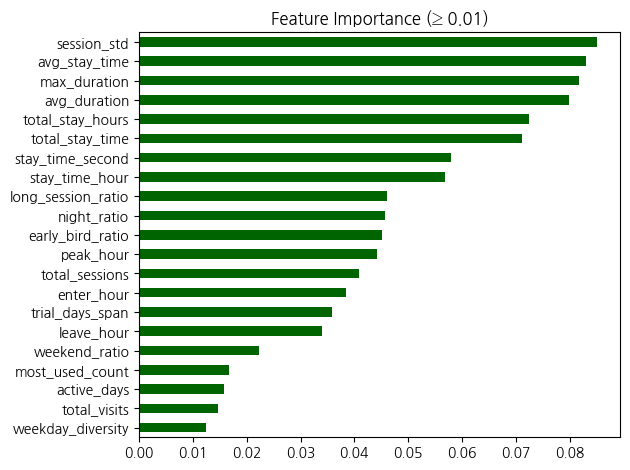

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# 1. 데이터프레임 불러오기 (예시: total_user_merge_3)
df = merge_total

# 2. 사용할 전체 피처 목록
feature_cols = [
    'total_sessions', 'avg_duration', 'max_duration', 'session_std',
    'peak_hour', 'night_ratio', 'weekend_ratio', 'long_session_ratio',
    'early_bird_ratio', 'evening_ratio', 'weekday_diversity', 'total_stay_time',
    'visit_count', 'active_days', 'avg_stay_time', 'trial_days_span',
    'total_stay_hours', 'stay_time_second', 'stay_time_hour',
    'enter_hour', 'leave_hour', 'used_sites_count', 'most_used_count',
    'total_visits'
]

# 3. 결측치 제거
selected_cols = feature_cols + ['is_payment']
df_clean = df[selected_cols].dropna()

# 4. X, y 분리
X = df_clean[feature_cols]
y = df_clean['is_payment']

# 5. 임시로 전체 피처로 학습 → 중요도 확인용
model_temp = RandomForestClassifier(n_estimators=100, random_state=42)
model_temp.fit(X, y)
importances = model_temp.feature_importances_

# 6. 중요도 0.01 이상인 피처만 선택
importance_series = pd.Series(importances, index=feature_cols)
selected_features = importance_series[importance_series >= 0.01].index.tolist()

print("🎯 중요도 0.01 이상 선택된 피처:", selected_features)

# 7. 선택된 피처로 다시 데이터 분리
X_selected = df_clean[selected_features]
y_selected = df_clean['is_payment']

# 8. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_selected, test_size=0.2, random_state=42
)

# 9. 모델 재학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 10. 예측 및 평가
y_pred = model.predict(X_test)

print("📊 [모델 평가 결과]")
print("정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("\n[분류 리포트]")
print(classification_report(y_test, y_pred))
print("\n[혼동 행렬]")
print(confusion_matrix(y_test, y_pred))

# 11. 피처 중요도 시각화
importance_final = model.feature_importances_
pd.Series(importance_final, index=selected_features).sort_values().plot(kind='barh', color='darkgreen')
plt.title("Feature Importance (≥ 0.01)")
plt.tight_layout()
plt.show()

## importance 최저2개 제거

📊 정확도: 0.853182104599874

📄 분류 리포트:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       914
           1       0.91      0.73      0.81       673

    accuracy                           0.85      1587
   macro avg       0.87      0.84      0.84      1587
weighted avg       0.86      0.85      0.85      1587



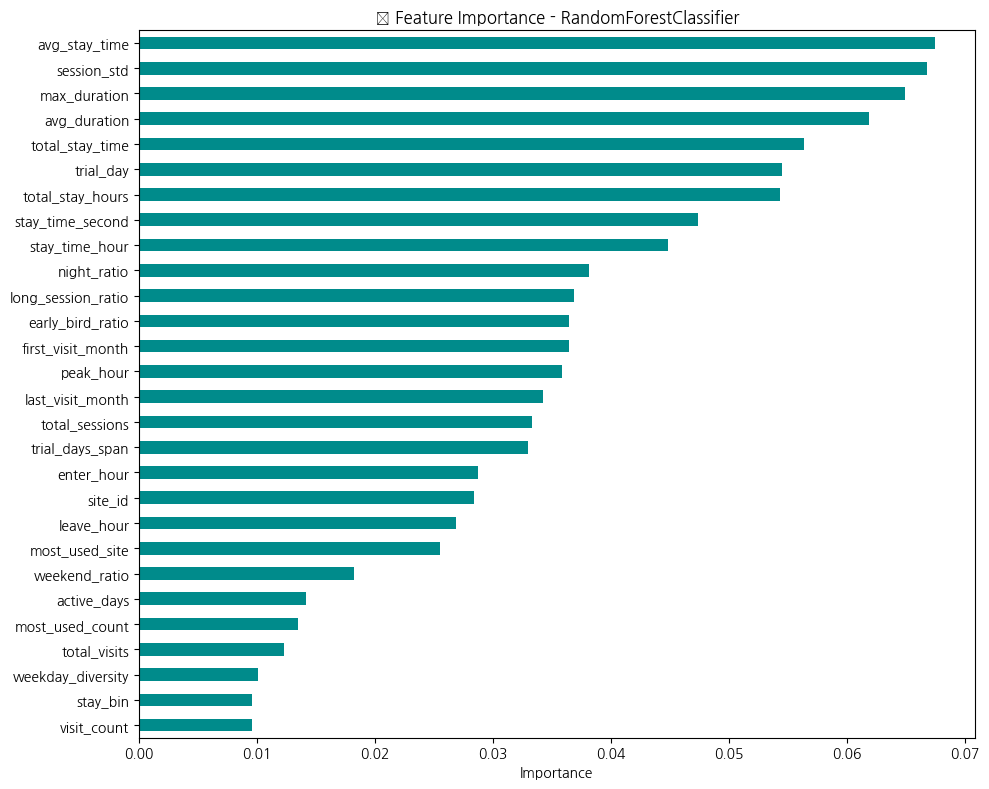

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = merge_total

# 2. 날짜형 변환
date_cols = ['first_visit_date', 'last_visit_date', 'date', 'first_enter_time', 'last_leave_time', 'trial_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# 3. 날짜형 파생 피처 생성
df['first_visit_month'] = df['first_visit_date'].dt.month
df['last_visit_month'] = df['last_visit_date'].dt.month
df['trial_day'] = df['trial_date'].dt.day
df['enter_hour'] = df['first_enter_time'].dt.hour
df['leave_hour'] = df['last_leave_time'].dt.hour

# 4. 문자열 범주형 변수 인코딩
label_cols = ['stay_bin', 'most_used_site']
for col in label_cols:
    df[col] = df[col].astype(str)  # NaN 방지
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 5. 사용할 피처 정의
feature_cols = [
    'total_sessions', 'avg_duration', 'max_duration', 'session_std',
    'peak_hour', 'night_ratio', 'weekend_ratio', 'long_session_ratio',
    'early_bird_ratio', 'weekday_diversity',
    'total_stay_time', 'visit_count', 'active_days', 'avg_stay_time',
    'trial_days_span', 'total_stay_hours', 'stay_time_second',
    'stay_time_hour', 'enter_hour', 'leave_hour', 'site_id',
    'most_used_count', 'total_visits',
    'first_visit_month', 'last_visit_month', 'trial_day',
    'stay_bin', 'most_used_site'
]

# 6. 결측치 제거
selected_cols = feature_cols + ['is_payment']
df_clean = df[selected_cols].dropna()

# 7. X, y 분리
X = df_clean[feature_cols]
y = df_clean['is_payment']

# 8. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 9. 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 10. 예측 및 평가
y_pred = model.predict(X_test)

print("📊 정확도:", accuracy_score(y_test, y_pred))
print("\n📄 분류 리포트:")
print(classification_report(y_test, y_pred))

# 11. 피처 중요도 시각화
importances = model.feature_importances_
importances_series = pd.Series(importances, index=feature_cols).sort_values()

plt.figure(figsize=(10, 8))
importances_series.plot(kind='barh', color='darkcyan')
plt.title("🎯 Feature Importance - RandomForestClassifier")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()